In [1]:
import importlib
%reload_ext autoreload
%autoreload
%matplotlib inline

import sys
sys.path.append('/disk/bifrost/yuanze/software/KcwiKit/py')
sys.path.append('/disk/bifrost/yuanze/KBSS/CubEx_run/scripts')
import run_cubetools_v1 as ctools
import os
import kcwi
import pdb


import kcwi_tools
import common_tools_yd
import numpy as np
import glob

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import SymLogNorm
import scienceplots
from matplotlib import gridspec
import matplotlib.patches as mpatches
import cmcrameri as SCM7

import astropy.units as u
from astropy import constants
from astropy.table import Table
from astropy.coordinates import SkyCoord,FK5,ICRS
from astropy.io import fits,ascii
from astropy.wcs import WCS, utils as wcsutils
from astropy.stats import sigma_clipped_stats
import astropy.visualization as vis
from astropy.cosmology import Planck18
from astropy.modeling import models, fitting
from astropy.nddata import StdDevUncertainty, Cutout2D
from astropy.convolution import Gaussian2DKernel,Gaussian1DKernel


from spectral_cube import SpectralCube
from reproject import reproject_interp
from regions import Regions
import linetools

from scipy import interpolate
def imshow_astro(img, wcsinfo = None, figsize = (10,10), colorbar =True,
               cblabel="", cbfrac = 0.035, norm = None,
               stretch = vis.LinearStretch(), cmap = "hot",
               vrange = (None, None)):
    
    _, med, std = sigma_clipped_stats(img.data)
    
    fig =  plt.figure(figsize = figsize)
    if wcsinfo:
        ax = plt.subplot(projection = wcsinfo)
    else:
        ax = plt.subplot()
    
    vmin, vmax = vrange
    
    if not vmin:
        vmin = med
    if not vmax:
        vmax = med + 10*std
    if not norm:
        norm = vis.ImageNormalize(vmin = vmin, vmax = vmax, stretch = stretch)
    im = ax.imshow(img, norm = norm, cmap = cmap)
    if colorbar:
        cb = plt.colorbar(im, label = cblabel, fraction =cbfrac)
    return fig, ax, im

def imshow_ifu(img, wcsinfo=None,pix_scale=[0.3,0.3], redshift=0. , figsize = (10,10), colorbar =True,
               cblabel="", cbfrac = 0.035, norm = None,
               stretch = vis.LinearStretch(), cmap = matplotlib.cm.hot,direction=False,
               vrange = (None, None),dpi=300):
    scale_kpc_per_arcsec = Planck18.kpc_proper_per_arcmin(redshift).value / 60.0
    _, med, std = sigma_clipped_stats(img.data)

    fig =  plt.figure(figsize = figsize,dpi=dpi)
    
    if wcsinfo is not None:
        
        ax = plt.subplot(projection=wcsinfo)
    else:
        ax = plt.subplot()
    
    
    vmin, vmax = vrange
    
    if not vmin:
        vmin = med
    if not vmax:
        vmax = med + 6*std
    if not norm:
        norm = vis.ImageNormalize(vmin = vmin, vmax = vmax, stretch = stretch)
    #cmap = matplotlib.cm.spring  # Can be any colormap that you want after the cm
    cmap.set_bad(color='none')

    im = ax.imshow(img, origin='lower', norm = norm, cmap = cmap)
    # Determine pixel scales in arcseconds
    if wcsinfo is not None:
        pix_scale_ra = np.abs(wcsinfo.pixel_scale_matrix[0,0]) * 3600.0  # RA scale in arcsec/pixel
        pix_scale_dec = np.abs(wcsinfo.pixel_scale_matrix[1,1]) * 3600.0  # Dec scale in arcsec/pixel
    elif pix_scale is not None:
        pix_scale_ra=pix_scale[0]
        pix_scale_dec=pix_scale[1]
    else:
        pix_scale_ra=None
        pix_scale_dec=None

    # Convert to physical scales
    #pix_scale_ra_kpc = pix_scale_ra * scale_kpc_per_arcsec
    #pix_scale_dec_kpc = pix_scale_dec * scale_kpc_per_arcsec
    if colorbar:
        cb = plt.colorbar(im, label = cblabel, fraction =cbfrac)
    x = np.linspace(0, img.shape[1], 8)
    y = np.linspace(0, img.shape[0], 8)
#    x_labels_kpc = x * pix_scale_ra_kpc
#    y_labels_kpc = y * pix_scale_dec_kpc
    x_labels_arcsec = x * pix_scale_ra
    y_labels_arcsec = y * pix_scale_dec
    # Setting direction arrows
    x0, y0 = 85, 85
    arrow_length = 10
    if direction:
        # North arrow goes upward in y-direction (positive Dec)
        ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='white', label='North')
        ax.text(x0-2, y0+1, 'N', color='white', ha='center', va='bottom')
        # East arrow goes to the right in x-direction (negative RA)
        ax.quiver(x0, y0, arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='white', label='East')
        ax.text(x0+2, y0-1, 'E', color='white', ha='center', va='top')

#    print(ra,dec)
    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels(np.round(x_labels_arcsec-np.mean(x_labels_arcsec),decimals=1))
    ax.set_yticklabels(np.round(y_labels_arcsec-np.mean(y_labels_arcsec),decimals=1))
    ax.set_xlabel(r"$\Delta$arcsec")
    ax.set_ylabel(r"$\Delta$arcsec")
    return fig, ax


KBSSpath="/disk/bifrost/yuanze/KBSS"

In [80]:
hdu_test=fits.open("/disk/bifrost/yuanze/KBSS/LyC22/M15/kcwir/LyC22-M15-red_vcubes.fits")

In [86]:
hdu_test[0].data.max()

2.957266850786541e+78

In [419]:
time=40**2*u.kpc/(constants.c)#(2000*u.km/u.s)

In [420]:
time.to(u.year).value/1e6

5.218502043467893

## Testing different implementation of radial profile 

In [128]:
#cubename="Q1217"
#sourcename="BX172"
psname="BX160"

#redshift=2.6347
#RA=184.91584
#DEC=49.66657


qsos = ascii.read(KBSSpath+"/KCWI/qsos.kcwi",format="ipac")
sentry=qsos[qsos["Name"]==psname]
sourcename=sentry["Cube"].value[0]
cubename=sentry["Field"].value[0]
Type=sentry["Type"][0]
if sentry["zneb"]>0:
    redshift=sentry["zneb"].value[0]
elif sentry["zabs"]>0:
    redshift=sentry["zabs"].value[0]
else:
    redshift=sentry["zlya"].value[0]
RA = sentry["RA"].value[0]
DEC = sentry["Dec"].value[0]
xpix = sentry["x"].value[0]
ypix = sentry["y"].value[0]

datapath=KBSSpath+"/"+cubename+"/"+sourcename
subdapath=KBSSpath+"/"+cubename+"/"+psname

cubefile = datapath+"/kcwi_oned/{}-{}_icubes_wcs.fits".format(cubename.lower(),sourcename)

if Type=='QSO' or Type=='AGN/QSO':
    Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(cubename.lower(),psname)
else:
    Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.CONTSub.fits".format(cubename.lower(),psname)


#

interpolating with grid:  (2602,) (50,) on (2602, 50)


/disk/bifrost/yuanze/anaconda3/envs/kcwidrp/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


Text(0, 0.5, 'SB $\\rm (10^{-16}~erg~s^{-1}~cm^{-2}~arcsec^{-2})$')

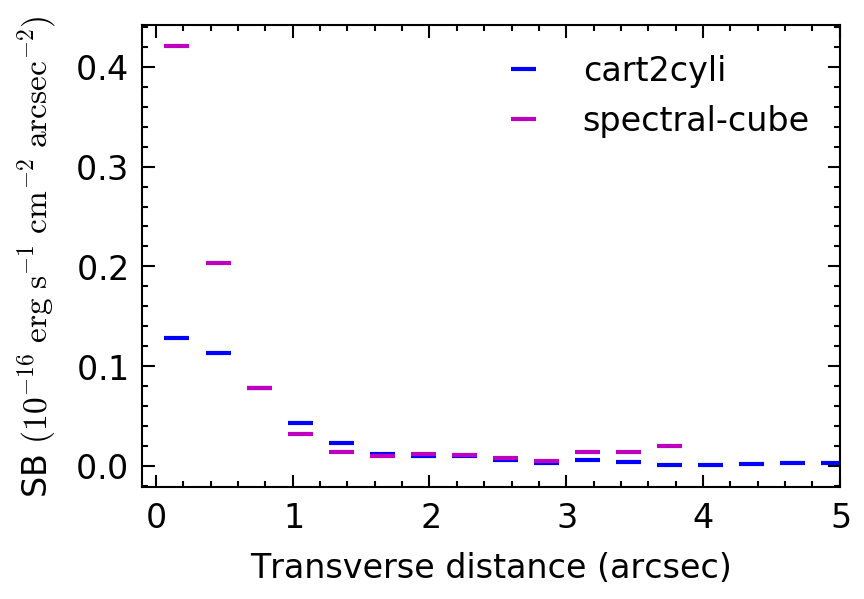

In [129]:
from scipy import interpolate

fn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.sat.cyli.fits".format(cubename.lower(),psname)
afn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.sat.cyli_area.fits".format(cubename.lower(),psname)
hdu = fits.open(fn)[0]
hdr = hdu.header

#adata = fits.open(afn)[0].data
cw=1216.9 # central wavelength
wc = (np.arange(hdr['NAXIS3']) - hdr['CRPIX3'] + 1) * hdr['CD3_3'] + hdr['CRVAL3']
vc = (wc / (1 + redshift) - cw) / cw *3e5
dc = (np.arange(hdr['NAXIS2']) - hdr['CRPIX2'] + 1) * hdr['CD2_2'] + hdr['CRVAL2']

#am2d=np.nansum(adata,axis=2)
m2d=np.nanmean(hdu.data,axis=2)
print("interpolating with grid: ",vc.shape,dc.shape,"on",m2d.shape)
#interpfunc = interpolate.interp2d(vc, dc, np.nan_to_num(m2d.T), kind='cubic')
#r = interpolate.RectBivariateSpline(vc, dc, np.nan_to_num(m2d))

#interpfunc = lambda xnew, ynew: r(xnew, ynew).T

#interpfunc = interpolate.interp2d(vc, dc, np.nan_to_num(m2d.T), kind='cubic')
#xstack = np.arange(-1600, 2000, 50)
#ystack = np.arange(0, 25., 0.1)


#cp2d_new = interpfunc(xstack,ystack)




index_b = (vc > -1000) & (vc <= 0)
index_r = (vc > 0) & (vc <= 1200)
index_a = (vc > -1000) & (vc <= 1200)

sb_b0 = np.sum(m2d[index_b, :], axis=0) * (vc[1] - vc[0]) / 3e5 * cw * (redshift + 1)
sb_r0 = np.sum(m2d[index_r, :], axis=0) * (vc[1] - vc[0]) / 3e5 * cw * (redshift + 1)
sb_a0 = np.sum(m2d[index_a, :], axis=0) * (vc[1] - vc[0]) / 3e5 * cw * (redshift + 1)

#asb_a0 = np.sum(am2d[index_a, :], axis=0) * (vc[1] - vc[0]) / 3e5 * cw * (redshift + 1)

fig, ax = plt.subplots(figsize=(3,2),dpi=300)

ax.errorbar(dc,sb_b0
            ,fmt="_",
        label="cart2cyli",
        color="b",
        capsize=0.0,
        ls="None",
        lw=1)
ty=np.array([42.11899788, 20.3189102 ,  7.77915837,  3.14462739,  1.38252179,
        1.00454077,  1.1575351 ,  1.10231811,  0.79644328,  0.46233536,
        1.36576262,  1.39187972,  1.94364115,         np.nan,         np.nan,
               np.nan,         np.nan,         np.nan,         np.nan])
rbin=np.array([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6, 3.9,
       4.2, 4.5, 4.8, 5.1, 5.4, 5.7])
ax.errorbar(rbin-0.15,ty*0.01
            ,fmt="_",
        label="spectral-cube",
        color='m',
        capsize=0.0,
        ls="None",
        lw=1)
#ax.plot(rbin[:-1]*kpc_per_arcsec+rx/2,np.array(annulus_value[sourcename][1])*2,color="k")

#ax.fill_between(rbin[:-1]*kpc_per_arcsec+rx/2,0,np.array(annulus_value[sourcename][1])*2,color="k",alpha=0.3)

#x_fit = np.linspace(3, 20, 100)
#y_fit=fitted_model(x_fit)
#ax.plot(x_fit,y_fit,"g")
ax.legend()
#ax.set_title("{}-{}".format(field,sourcename))
ax.set_xlim([-0.1,5])
#ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel("Transverse distance (arcsec)")
ax.set_ylabel(r"SB $\rm (10^{-16}~erg~s^{-1}~cm^{-2}~arcsec^{-2})$")
#fig.savefig(KBSSpath+"/"+field+"/"+sourcename+"/kcwi_oned/SB_profile.pdf")


# 1. reproject PSF subtracted cube onto cylindrical system

In [ ]:
### all_directories,qsotab,data_dir = ctools.find_directories_from_ascii(source_table, root_directory,filters=filters,KBSS=(dtype=="KBSS"))

In [10]:
Subfile_red

'/disk/bifrost/yuanze/KBSS/LyC22/M15/kcwir/LyC22-M15-red_icubes.CONTSub.fits'

In [9]:
os.path.exists(Subfile_red)

False

In [47]:
from importlib import reload
reload(kcwi_tools)

root_directory="/disk/bifrost/yuanze/KBSS"
ascii_file_path = root_directory+'/KCWI/KBSS_faint_AGN.list'  # Path to the ASCII file
save_to_path=root_directory+"/faint_qsos/result"  # Path to save the output files
source_table = ascii.read(ascii_file_path, format='ipac')
dtype="KBSS"
filters = ["table['KCWI'] == 'yes'","table['Name'] == 'MD77'","table['Name'] != 'FSzP1170'","table['Name'] != 'Lab5'"]

all_directories,qsotab,data_dir = ctools.find_directories_from_ascii(source_table, root_directory,filters=filters,KBSS=(dtype=="KBSS"))
all_directories_red,_,data_dir_red = ctools.find_directories_from_ascii(source_table, root_directory,filters=filters,KBSS=(dtype=="KBSS"),channel="red")
overwrite=True
dryrun=False
for ind,sentry in enumerate(qsotab):
    #sentry=qsos_bright[qsos_bright["Field"]==field]
    #cubename=sentry["Field"].value[0]
    Field=sentry["Field"]
    Type=sentry["Type"]
    psname=sentry["Name"]
    csname=sentry["CName"]
    dapath=data_dir[ind]
    dapath_red=data_dir_red[ind]
    subdapath=all_directories[ind]
    subdapath_red=all_directories_red[ind]
    xpix = sentry["x"]
    ypix = sentry["y"]
    if Type<1.9: 
        Subfile = subdapath+"/{}-{}_icubes.PSFCONTSub.fits".format(Field ,psname)
        Subfile_red = subdapath_red+"/{}-{}-red_icubes.PSFCONTSub.fits".format(Field ,psname)
        maskfn=subdapath+"/{}-{}_icubes.PSFSub.mask.fits".format(Field ,psname)
        #maskfn_red=subdapath+"/{}-{}-red_icubes.PSFSub.mask.fits".format(Field ,psname)
        if not os.path.exists(Subfile):
            Subfile = subdapath+"/{}-{}_icubes_wcs.PSFCONTSub.fits".format(Field ,psname)
            Subfile_red = subdapath_red+"/{}-{}-red_icubes.PSFCONTSub.fits".format(Field ,psname)
    else:
        Subfile = subdapath+"/{}-{}_icubes_wcs.CONTSub.fits".format(Field ,psname)
        Subfile_red = subdapath_red+"/{}-{}-red_icubes_wcs.CONTSub.fits".format(Field ,psname)
        maskfn=subdapath+"/{}-{}_icubes.CONTSub.mask.fits".format(Field ,psname)
        #maskfn_red=subdapath+"/{}-{}-red_icubes.CONTSub.mask.fits".format(Field ,psname)
        if not os.path.exists(Subfile):
            Subfile = subdapath+"/{}-{}_icubes.CONTSub.fits".format(Field ,psname)
            Subfile_red = subdapath_red+"/{}-{}-red_icubes.CONTSub.fits".format(Field ,psname)
    writefn=subdapath+"/{}-{}_icubes.cyli.fits".format(Field ,psname)
    writefn_red=subdapath_red+"/{}-{}-red_icubes.cyli.fits".format(Field ,psname)
    if not os.path.exists(writefn) or overwrite == True:
        print("reprojecting",Field,psname,"to cylindrical system...")
        print("reading:",Subfile)
        print("writing result to ",writefn)
        if dryrun:
            continue
        hdu=fits.open(Subfile)
        hdu[0].header["CNAME3"]='KCWI Wavelength'
        hdr=hdu[0].header
        status=kcwi_tools.cart2cyli(Subfile,[xpix,ypix],hdr=hdr,masktype='direct',cos=Planck18,r_range=[0,10],dr=0.3,maskfn=maskfn,writefn=writefn,montage=True)
        hdu.close()
    else:
        print("reprojected blue cube existed and overwrite == False: no stacking performed ")
        
    if os.path.exists(Subfile_red) and (not os.path.exists(writefn_red) or overwrite == True):
        print("reading:",Subfile_red)
        print("writing result to ",writefn_red)
        hdu=fits.open(Subfile_red)
        hdu[0].header["CNAME3"]='KCWI Wavelength'
        hdr=hdu[0].header
    #status=kcwi_tools.cart2cyli(Subfile,[xpix,ypix],hdr=hdr,masktype='direct',cos=Planck18,r_range=[0,10],dr=binwidth/kpc_per_arcsec,maskfn=maskfn,writefn=writefn,montage=True)
        status=kcwi_tools.cart2cyli(Subfile_red,[xpix,ypix],hdr=hdr,masktype='direct',cos=Planck18,r_range=[0,10],dr=0.3,maskfn=maskfn,writefn=writefn_red,montage=True)
        hdu.close()
        #nhdu=kcwi_tools.cart2cyli(hdu[0],[xpix,ypix],r_range=[0,15],writefn=writefn_red)
    else:
        print("No red channel data for",Field,psname, " or file exists and overwrite == False")
    

"""
faintqsos=ascii.read()
dkind=".PSFCONTSub"
overwrite=True
#dkind=""
for psname in enumerate(qsos['Name']):
    sentry=qsos[qsos["Name"]==psname]
    cubename=sentry["Field"].value[0]
    Type=sentry["Type"][0]
    if True:#Type=='QSO' or Type=='AGN/QSO':
        subdapath=KBSSpath+"/"+cubename+"/"+psname
        Subfile = subdapath+"/kcwib/{}-{}_icubes_wcs{}.fits".format(cubename.lower(),psname,dkind)
        xpix = sentry["x"].value[0]
        ypix = sentry["y"].value[0]
    else:
        print(psname,"is not type-1, skipping...")
        continue
    writefn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.sat.cyli.fits".format(cubename.lower(),psname)
    if overwrite==True or (not os.path.exists(writefn)):
        print("reprojecting",psname,"to cylindrical system...")
        hdu=fits.open(Subfile)
        hdu2=fits.open(cubefile)
        hdu[0].header["CNAME3"]=hdu2[0].header["CNAME3"]
        nhdu=kcwi_tools.cart2cyli(hdu[0],[xpix,ypix],r_range=[0,15],writefn=writefn,montage=False,montagepy=False,clean=False)
    else:
        print("reprojected cube existed: no stacking performed ")
"""

reprojecting Q2343 MD77 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q2343/MD77/kcwib/Q2343-MD77_icubes.PSFCONTSub.fits
writing result to  /disk/bifrost/yuanze/KBSS/Q2343/MD77/kcwib/Q2343-MD77_icubes.cyli.fits
reading HDU
updating hdr
Using direct mask
Projecting FITS mask to mask_3d...
{'status': '0', 'time': 4.0}
reading: /disk/bifrost/yuanze/KBSS/Q2343/MD77/kcwir/Q2343-MD77-red_icubes.PSFCONTSub.fits
writing result to  /disk/bifrost/yuanze/KBSS/Q2343/MD77/kcwir/Q2343-MD77-red_icubes.cyli.fits
reading HDU
updating hdr
Using direct mask
Projecting FITS mask to mask_3d...
{'status': '0', 'time': 5.0}


'\nfaintqsos=ascii.read()\ndkind=".PSFCONTSub"\noverwrite=True\n#dkind=""\nfor psname in enumerate(qsos[\'Name\']):\n    sentry=qsos[qsos["Name"]==psname]\n    cubename=sentry["Field"].value[0]\n    Type=sentry["Type"][0]\n    if True:#Type==\'QSO\' or Type==\'AGN/QSO\':\n        subdapath=KBSSpath+"/"+cubename+"/"+psname\n        Subfile = subdapath+"/kcwib/{}-{}_icubes_wcs{}.fits".format(cubename.lower(),psname,dkind)\n        xpix = sentry["x"].value[0]\n        ypix = sentry["y"].value[0]\n    else:\n        print(psname,"is not type-1, skipping...")\n        continue\n    writefn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.sat.cyli.fits".format(cubename.lower(),psname)\n    if overwrite==True or (not os.path.exists(writefn)):\n        print("reprojecting",psname,"to cylindrical system...")\n        hdu=fits.open(Subfile)\n        hdu2=fits.open(cubefile)\n        hdu[0].header["CNAME3"]=hdu2[0].header["CNAME3"]\n        nhdu=kcwi_tools.cart2cyli(hdu[0],[xpix,ypix],r_range=[0,15],writef

### Do the same for HL QSOs

In [697]:
qsos_bright=ascii.read(KBSSpath+"/KCWI/qsos_bright.kcwi",format="ipac")
i=0
dryrun=False
for ind,field in enumerate(qsos_bright['Field']):
    sentry=qsos_bright[qsos_bright["Field"]==field]
    #cubename=sentry["Field"].value[0]
    #Type=sentry["Type"][0]
    if field=="1623":
        psname=sentry["Name"][i].split("-")[1]
        i+=1
        sentry=qsos_bright[(qsos_bright["Field"]==field) & (qsos_bright["Name"]==field+"-"+psname)]
        ssentry=qsos[qsos["Name"]==psname]
        csname=ssentry["Cube"][0]
        dapath=KBSSpath+"/"+field+"/"+csname+"/kcwi_oned"
        subdapath=KBSSpath+"/"+field+"/"+psname+"/kcwi_oned"
        Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.fits".format(field.lower(),psname)
        xpix = sentry["x"].value[0]
        ypix = sentry["y"].value[0]
        writefn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.sat.cyli.fits".format(field.lower(),psname)
    else:
        subdapath=KBSSpath+"/"+field+"/QSO"
        Subfile = subdapath+"/{}-qso_icubes_wcs.fits".format(field.lower())
        xpix = sentry["x"].value[0]
        ypix = sentry["y"].value[0]
        writefn=subdapath+"/{}-qso_icubes_wcs.sat.cyli.fits".format(field.lower())
    if not os.path.exists(writefn):
        print("reprojecting",sentry["Name"][0],"to cylindrical system...")
        print("reading:",Subfile)
        print("writing result to ",writefn)
        if dryrun:
            continue
        hdu=fits.open(Subfile)
        hdu[0].header["CNAME3"]='KCWI Wavelength'
        nhdu=kcwi_tools.cart2cyli(hdu[0],[xpix,ypix],r_range=[0,15],writefn=writefn)
    else:
        print("reprojected cube existed: no stacking performed ")


reprojecting Q0100+13 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q0100/QSO/q0100-qso_icubes_wcs.fits
writing result to  /disk/bifrost/yuanze/KBSS/Q0100/QSO/q0100-qso_icubes_wcs.sat.cyli.fits
reprojecting HS0105+1619 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q0105/QSO/q0105-qso_icubes_wcs.fits
writing result to  /disk/bifrost/yuanze/KBSS/Q0105/QSO/q0105-qso_icubes_wcs.sat.cyli.fits
reprojecting Q0142-10 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q0142/QSO/q0142-qso_icubes_wcs.fits
writing result to  /disk/bifrost/yuanze/KBSS/Q0142/QSO/q0142-qso_icubes_wcs.sat.cyli.fits
reprojecting Q0207-003 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q0207/QSO/q0207-qso_icubes_wcs.fits
writing result to  /disk/bifrost/yuanze/KBSS/Q0207/QSO/q0207-qso_icubes_wcs.sat.cyli.fits
reprojecting Q0821+3107 to cylindrical system...
reading: /disk/bifrost/yuanze/KBSS/Q0821/QSO/q0821-qso_icubes_wcs.fits
writing result to  /disk/bifrost/yuanze/KBSS

FileNotFoundError: [Errno 2] No such file or directory: '/disk/bifrost/yuanze/KBSS/Q1623/QSO/q1623-qso_icubes_wcs.fits'

In [241]:
hdu=fits.open(Subfile)
hdu2=fits.open(cubefile)
hdu[0].header["CNAME3"]=hdu2[0].header["CNAME3"]
nhdu=kcwi_tools.cart2cyli(hdu2[0],[xpix,ypix],r_range=[0,10],clean=False,montage=True,montagepy=True)

maximum of data5: nan


In [234]:
testhdr=fits.open("/disk/bifrost/yuanze/KBSS/stack_analysis/kcwi_tools/cart2cyli_cube3_3.fits")

In [417]:
print(np.nanmax(testhdr[0].data))
print(np.nanmax(nhdu[0].data))

2.7166420655036454
49.22491697470347


In [231]:

hdu3_1=fits.open("/disk/bifrost/yuanze/KBSS/stack_analysis/kcwi_tools/cart2cyli_cube3_1.fits")[0]
hdu3_2=fits.open("/disk/bifrost/yuanze/KBSS/stack_analysis/kcwi_tools/cart2cyli_cube3_2.fits")[0]
hdu3_3=fits.open("/disk/bifrost/yuanze/KBSS/stack_analysis/kcwi_tools/cart2cyli_cube3_3.fits")[0]

data4=np.zeros((hdu3_1.shape[0],hdu3_1.shape[1],
                hdu3_1.shape[2]+hdu3_2.shape[2]+hdu3_3.shape[2]-30))
data4[:,:,0:hdu3_1.shape[2]-10]=hdu3_1.data[:,:,5:hdu3_1.shape[2]-5]
data4[:,:,hdu3_1.shape[2]-10:
        hdu3_1.shape[2]+hdu3_2.shape[2]-20]=hdu3_2.data[:,:,5:hdu3_2.shape[2]-5]
data4[:,:,hdu3_1.shape[2]+hdu3_2.shape[2]-20:
        hdu3_1.shape[2]+hdu3_2.shape[2]+hdu3_3.shape[2]-30]=hdu3_3.data[:,:,5:hdu3_3.shape[2]-5]
data4[data4==0]=np.nan

In [239]:
hdu3_3.shape[2]

130

In [233]:
dx=-hdu3_1.header['CD1_1']
dx0=-nhdu[0].header['CD1_1']
print(int(dx0/dx))
print(nhdu[0].header['CRVAL2'])

1
0


# 2. Stack cube together 

In [2]:
for ind,psname in enumerate(qsos['Name']):
    sentry=qsos[qsos["Name"]==psname]
    cubename=sentry["Field"].value[0]
    Type=sentry["Type"][0]
    if Type=='QSO' or Type=='AGN/QSO':

SyntaxError: unexpected EOF while parsing (2507708774.py, line 5)

In [3]:
sourcename="BX172"
psname="BX164"

qsos = ascii.read(KBSSpath+"/KCWI/qsos.kcwi",format="ipac")
sentry=qsos[qsos["Name"]==psname]
cubename=sentry["Field"].value[0]
Type=sentry["Type"][0]
if sentry["zneb"]>0:
    redshift=sentry["zneb"].value[0]
elif sentry["zabs"]>0:
    redshift=sentry["zabs"].value[0]
else:
    redshift=sentry["zlya"].value[0]
RA = sentry["RA"].value[0]
DEC = sentry["Dec"].value[0]
xpix = sentry["x"].value[0]
ypix = sentry["y"].value[0]

datapath=KBSSpath+"/"+cubename+"/"+sourcename
subdapath=KBSSpath+"/"+cubename+"/"+psname

cyli_cube=fits.open(subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(cubename.lower(),psname))

In [319]:
def create_axis(header, crval, cdelt, naxis):
    return np.arange(header[crval], header[crval] + cdelt * header[naxis], cdelt)


PA_axis=np.arange(cyli_cube[0].header['CRVAL1A'],cyli_cube[0].header['CRVAL1A']+cyli_cube[0].header['CD1_1A']*(cyli_cube[0].header['NAXIS1']),cyli_cube[0].header['CD1_1A'])
r_axis=np.arange(cyli_cube[0].header['CRVAL2A'],cyli_cube[0].header['CRVAL2A']+cyli_cube[0].header['CD2_2A']*(cyli_cube[0].header['NAXIS2']),cyli_cube[0].header['CD2_2A'])
spec_axis=np.arange(cyli_cube[0].header['CRVAL3A'],cyli_cube[0].header['CRVAL3A']+cyli_cube[0].header['CD3_3A']*(cyli_cube[0].header['NAXIS3']),cyli_cube[0].header['CD3_3A'])

In [352]:
coord=["01 03 11.27 +13 16 18.2",\
      "01 08 06.4  +16 35 50.0",\
       "01 45 16.6  -09 45 17.0",\
       "02 09 50.71 -00 05 06.5",\
       "04 52 14.3  -16 40 16.2",\
       "08 21 07.62 +31 07 51.17",\
       "10 11 55.60 +29 41 41.7",\
       "12 19 30.85 +49 40 51.2",\
       "14 44 53.67 +29 19 05.6",\
       "15 51 52.5  +19 11 04.3",\
       "16 04 55.38 +38 12 01.8",\
       "16 25 48.83 +26 46 58.8",\
       "16 25 48.1  +26 44 32.9",\
       "16 25 57.4  +26 44 48.5",\
       "17 01 00.6  +64 12 09.4",\
       "22 08 52.1  -19 43 59.7",\
       "23 46 28.30 +12 48 57.8"
      ]
for pos in coord:
    s=SkyCoord(pos,unit=(u.hourangle, u.deg))
    print(s)

<SkyCoord (ICRS): (ra, dec) in deg
    (15.79695833, 13.27172222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (17.02666667, 16.59722222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (26.31916667, -9.75472222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (32.46129167, -0.08513889)>
<SkyCoord (ICRS): (ra, dec) in deg
    (73.05958333, -16.67116667)>
<SkyCoord (ICRS): (ra, dec) in deg
    (125.28175, 31.13088056)>
<SkyCoord (ICRS): (ra, dec) in deg
    (152.98166667, 29.69491667)>
<SkyCoord (ICRS): (ra, dec) in deg
    (184.87854167, 49.68088889)>
<SkyCoord (ICRS): (ra, dec) in deg
    (221.223625, 29.31822222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (237.96875, 19.18452778)>
<SkyCoord (ICRS): (ra, dec) in deg
    (241.23075, 38.2005)>
<SkyCoord (ICRS): (ra, dec) in deg
    (246.45345833, 26.783)>
<SkyCoord (ICRS): (ra, dec) in deg
    (246.45041667, 26.74247222)>
<SkyCoord (ICRS): (ra, dec) in deg
    (246.48916667, 26.74680556)>
<SkyCoord (ICRS): (ra, dec) in deg
    (255.2525, 64.20261111)>
<SkyCoor

In [99]:
wdir=f"{KBSSpath}/stack_analysis"
flist=[]
for ind,psname in enumerate(qsos['Name']):
    sentry=qsos[qsos["Name"]==psname]
    cubename=sentry["Field"].value[0]
    Type=sentry["Type"][0]
    if Type=='QSO' or Type=='AGN/QSO':
        subdapath=KBSSpath+"/"+cubename+"/"+psname
#        Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(cubename.lower(),psname)
        cyli_cube_name=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(cubename.lower(),psname)
        flist.append(cyli_cube_name)
#np.savetxt(wdir+"/source.list",np.array(flist).T,fmt='%s')

In [65]:
Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(cubename.lower(),psname)
Sub_cube = SpectralCube.read(Subfile)

In [75]:
QSOtab=qsos[((qsos['Type']=="QSO")|(qsos['Type']=="AGN/QSO"))& (qsos['R']>21)&(qsos['ext']=="True")]#&

KeyError: 'Type'

In [253]:
xnew = np.arange(-4000, 4000, 40)
ynew = np.arange(0.3, 6., 0.6)
ynew_qso = np.arange(0.3, 3.0, 0.1)

kpc_per_arcsec = Planck18.kpc_proper_per_arcmin(2.65).value/60
ynew_rh = np.arange(0,60/kpc_per_arcsec,20/kpc_per_arcsec)
xcorner = np.append(xnew, xnew[-1]+50) - 25
ycorner = np.append(ynew, ynew[-1]+0.1) - 0.05
xmesh, ymesh = np.meshgrid(xcorner, ycorner)
xcmesh, ycmesh = np.meshgrid(xnew, ynew)

xcont_new = np.arange(-20000, 20000, 100)
ycont_new = np.arange(0, 10, 0.1)
xcont_corner = np.append(xcont_new, xcont_new[-1] + 100) - 50
ycont_corner = np.append(ycont_new, ycont_new[-1] + 0.1) - 0.05
xcont_mesh, ycont_mesh = np.meshgrid(xcont_corner, ycont_corner)
xccont_mesh, yccont_mesh = np.meshgrid(xcont_new, ycont_new)

wcont_full = np.arange(1000, 1700, 0.5)
xcont_full = (wcont_full - 1215.67) / 1215.67 * 3e5 + 1215.67
ycont_full = np.arange(0, 10, 0.1)
dxcont = xcont_full[1] - xcont_full[0]
xcont_full_corner = np.append(xcont_full, xcont_full[-1] + dxcont) - dxcont / 2
ycont_full_corner = np.append(ycont_full, ycont_full[-1] + 0.1) - 0.05
xcont_full_mesh, ycont_full_mesh = np.meshgrid(xcont_full_corner, ycont_full_corner)
xccont_full_mesh, yccont_full_mesh = np.meshgrid(xcont_full, ycont_full)

In [237]:
#+qsotab["Name"].to_list()

['Q0100', 'Q0142', 'Q0207', 'Q0821', 'Q1549', 'Q1700', 'GWS', 'LyC22']

In [289]:

importlib.reload(common_tools_yd)
root_directory="/disk/bifrost/yuanze/KBSS"
ascii_file_path = root_directory+'/KCWI/KBSS_faint_AGN_short_updated_2.list'  # Path to the ASCII file
save_to_path=root_directory+"/faint_qsos/result"  # Path to save the output files
source_table = ascii.read(ascii_file_path, format='ipac')
dtype="KBSS"
sourcetype="unobscured_detected" #must be among "unobscured_detected", "obscured_detected", "nondetections"

if sourcetype=="obscured_detected":
    typefilter="table['Type']>=1.9"
    extended_emission_filter="table['UpperLim']<1"
elif sourcetype=="unobscured_detected":
    typefilter="table['Type']<1.9"
    extended_emission_filter="table['UpperLim']<1"
elif sourcetype=="unobscured_undetected":
    typefilter="table['Type']<1.9"
    extended_emission_filter="table['UpperLim']>0"
else:
    raise("Error:sourcetype must be among unobscured_detected, unobscured_undetected, obscured_detected")
filters = ["table['KCWI'] == 'yes'",typefilter,"table['R']>20",extended_emission_filter,"table['Name'] != 'BX415'","table['Name'] != 'MD90'","table['Name'] != 'BX101'","table['Name'] != 'GNB4950'","table['Name'] != 'FSzP1170'","table['Name'] != 'Lab5'"]
#,"table['Name'] != 'BX101'"
all_directories,qsotab,data_dir = ctools.find_directories_from_ascii(source_table, root_directory,filters=filters,KBSS=(dtype=="KBSS"))

result=common_tools_yd.stack_cp2d(qsotab,refz="best",channel="blue",faintAGN=True,
                                  notest=True,dgauss=True,interpR=True,return_cube=True,nboot=50,
                                  get_vlyas=False,stackgrid=(xnew,ynew),correct_cos_dimming=True,
                                 correct_extinction=True,return_weights=True)
#result_var=common_tools_yd.stack_cp2d(qsotab,refz="best",channel="blue",faintAGN=True,
#                                  notest=True,dgauss=True,interpR=True,return_cube=True,nboot=0,
#                                  get_vlyas=False,stackgrid=(xnew,ynew),correct_cos_dimming=True,variance=True,
#                                 correct_extinction=True)

stacking on grid with shape: (200,) (10,)
Using zneb =  2.5351
Using faint AGN datacube:  /disk/bifrost/yuanze/KBSS/Q0105/BX58
Correcting Galactic Extinction with G23 model and EBV =  0.06577014 Av =  0.1803417287617922
Correcting for cosmological dimming, with source z =  2.5351
the correction factor is  [724.341483   724.28833863 724.23522436 ... 640.40073602 640.3827373
 640.36474762]
interpolating with grid:  (2594,) (33,) on (2594, 33)
Using zneb =  3.0856
Using faint AGN datacube:  /disk/bifrost/yuanze/KBSS/Q0256/c31
Correcting Galactic Extinction with G23 model and EBV =  0.076771826 Av =  0.2105083456635475
Correcting for cosmological dimming, with source z =  3.0856
the correction factor is  [1562.93740505 1562.80355273 1562.66977786 ... 1353.637155   1353.59274669
 1353.54836091]
interpolating with grid:  (2594,) (33,) on (2594, 33)
Using zneb =  2.1831
Using faint AGN datacube:  /disk/bifrost/yuanze/KBSS/Q0821/RK5
Correcting Galactic Extinction with G23 model and EBV =  0.04

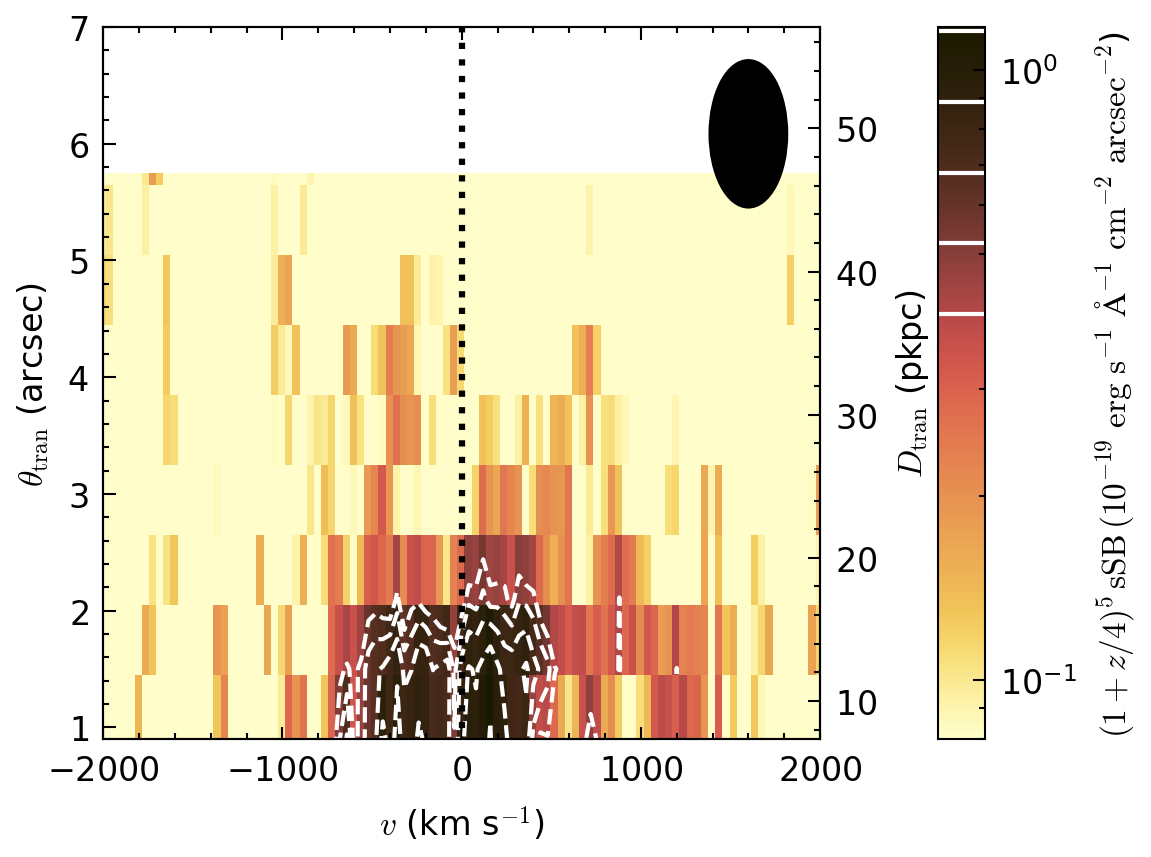

In [290]:
#import common_tools
importlib.reload(common_tools_yd)
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

fig, ax = plt.subplots(figsize=(4,3),dpi=300)
#4**4 is a factor to scale everything back to z=3
common_tools_yd.plot_cp2d(result[0]*1000/4**5,fig,ax,norm=True,log=True,PSFSub=True,faint=True,cosmo=Planck18,stackgrid=(xnew,ynew))
fig.tight_layout()
#fig.savefig(KBSSpath+f"/faint_qsos/result/stacking/{sourcetype}/stack_ps_faintQSOs_{sourcetype}.pdf")



  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_2974250/4001807672.py:164: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("tab20", N_show + (1 if len(other_idx) > 0 else 0))
100%|██████████| 10/10 [00:00<00:00, 34.55it/s]


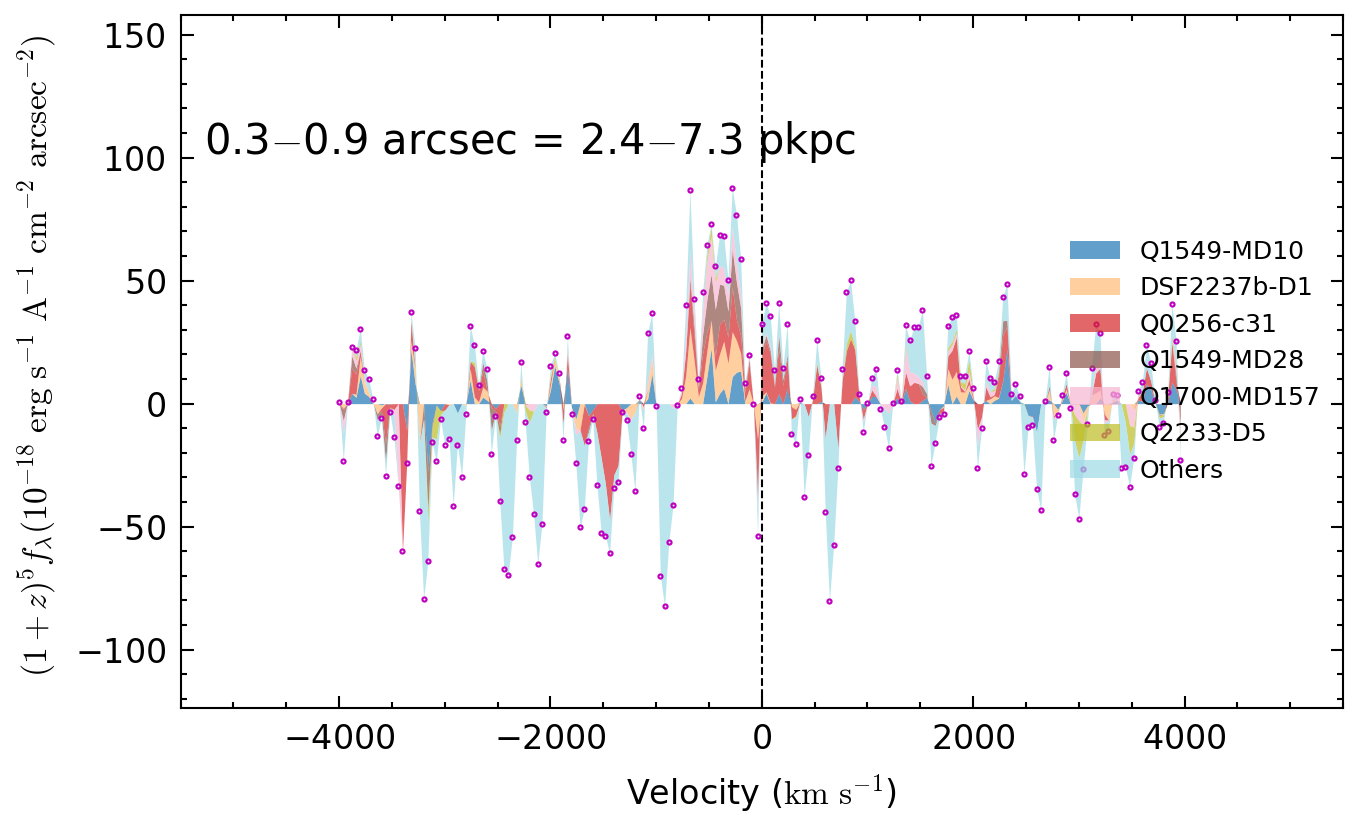

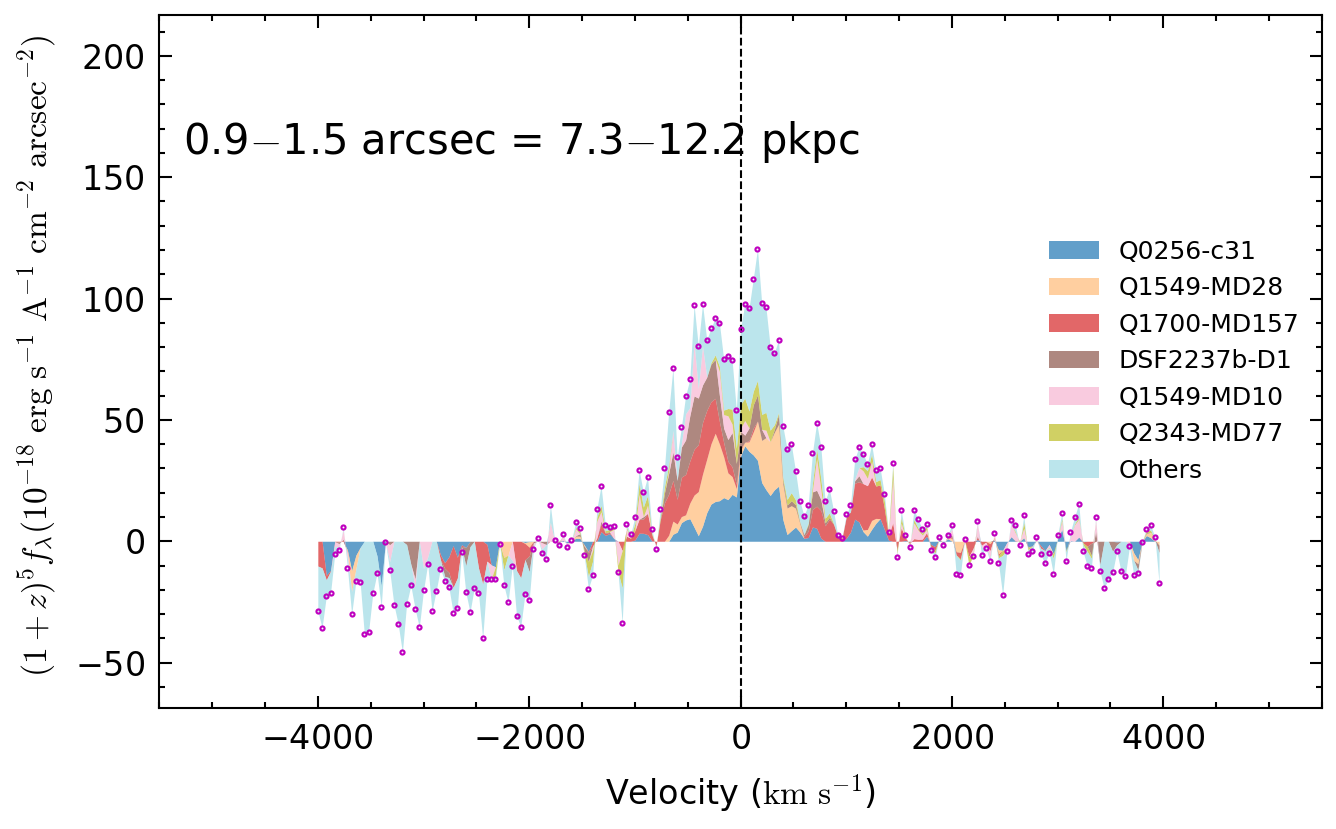

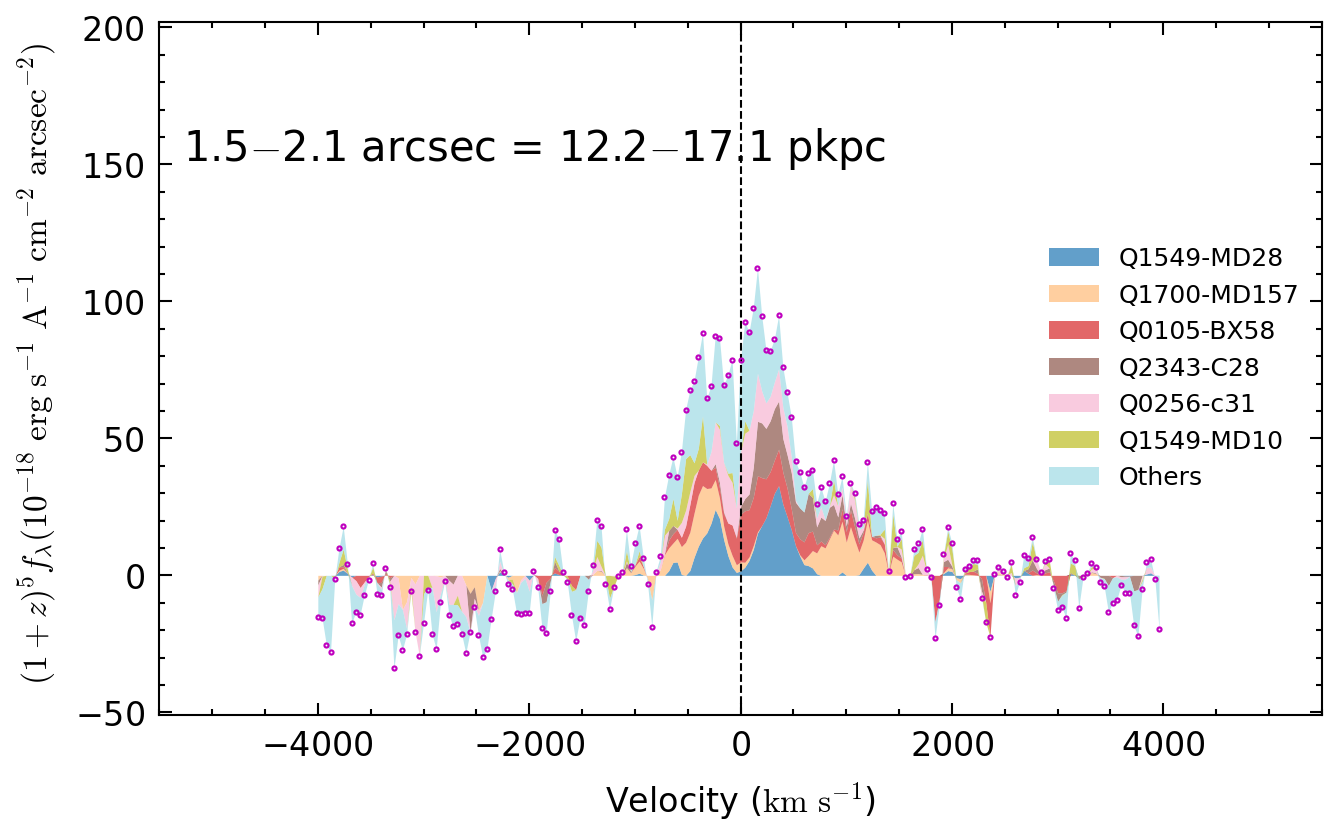

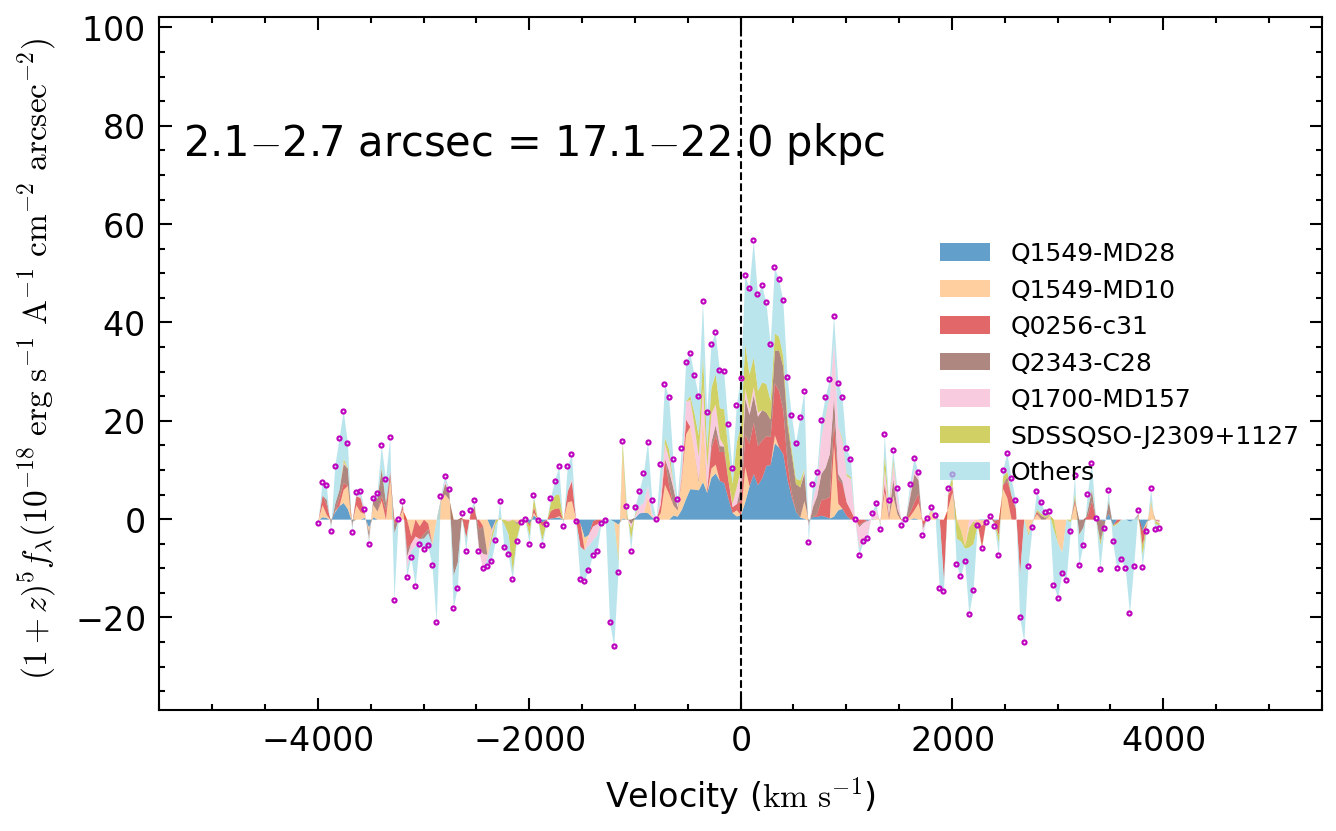

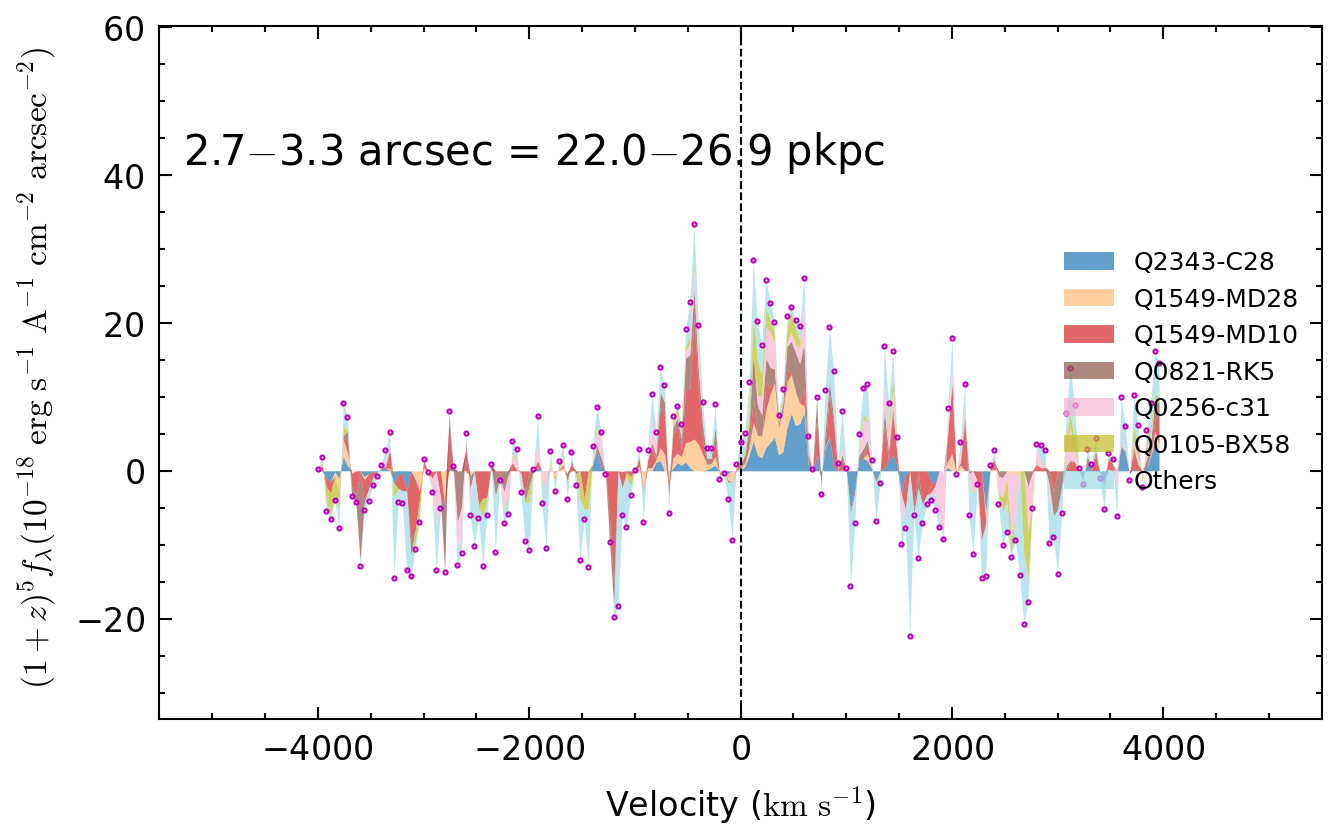

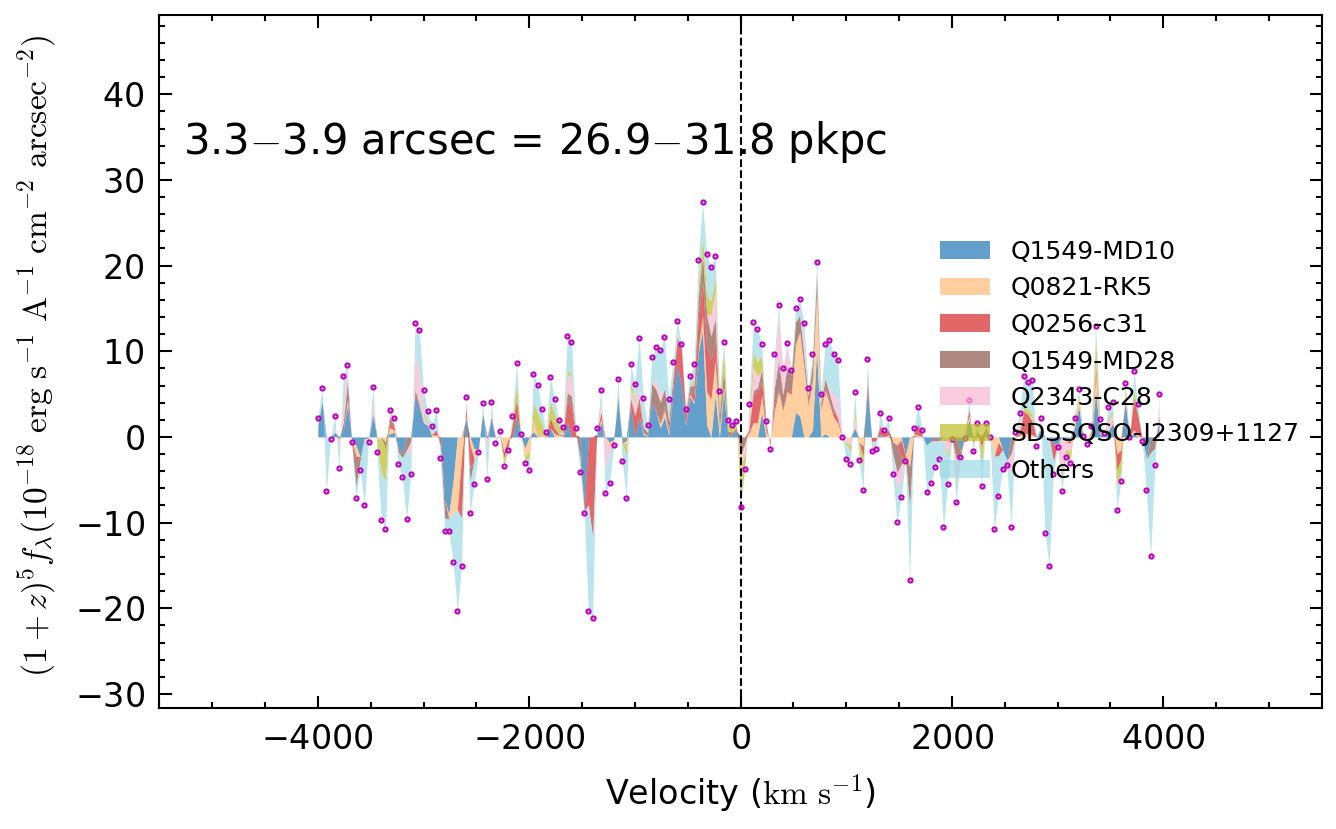

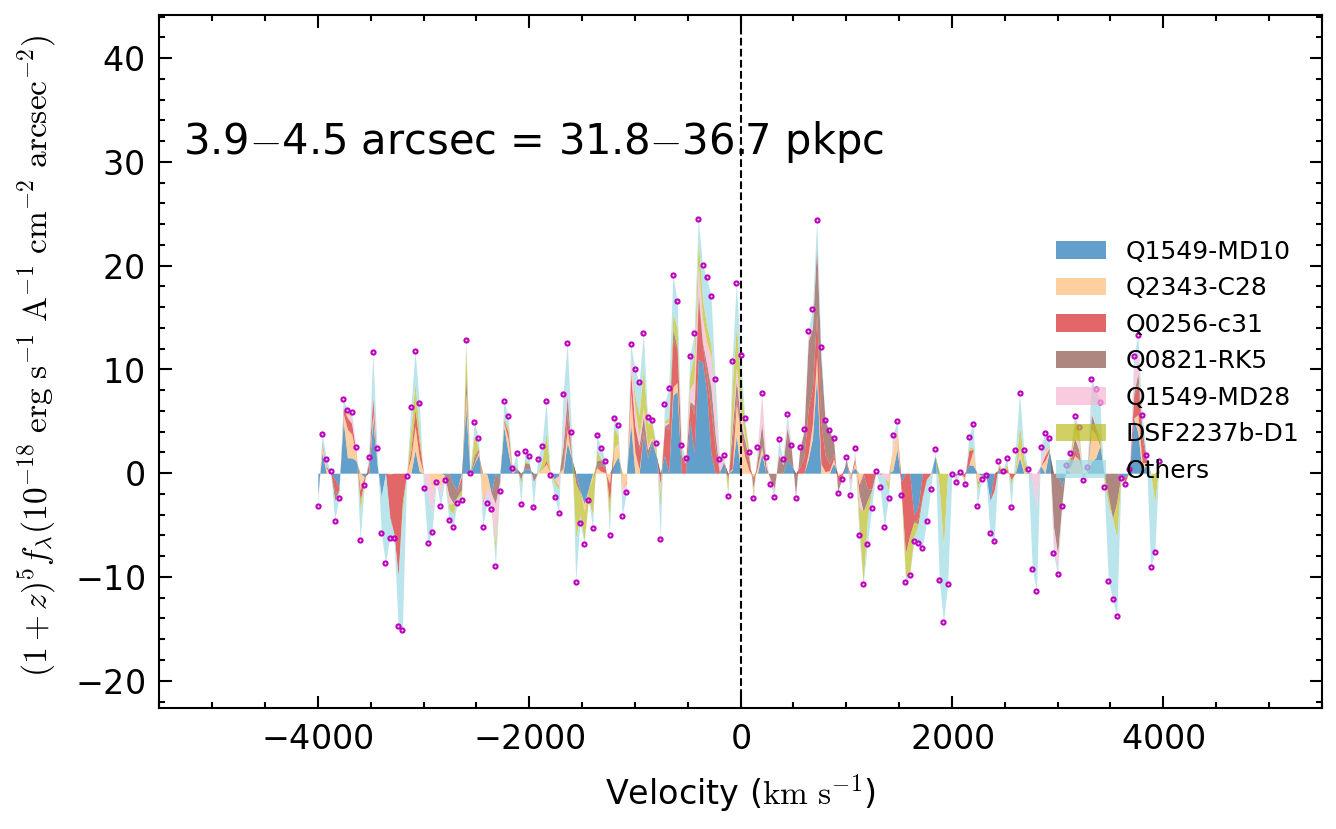

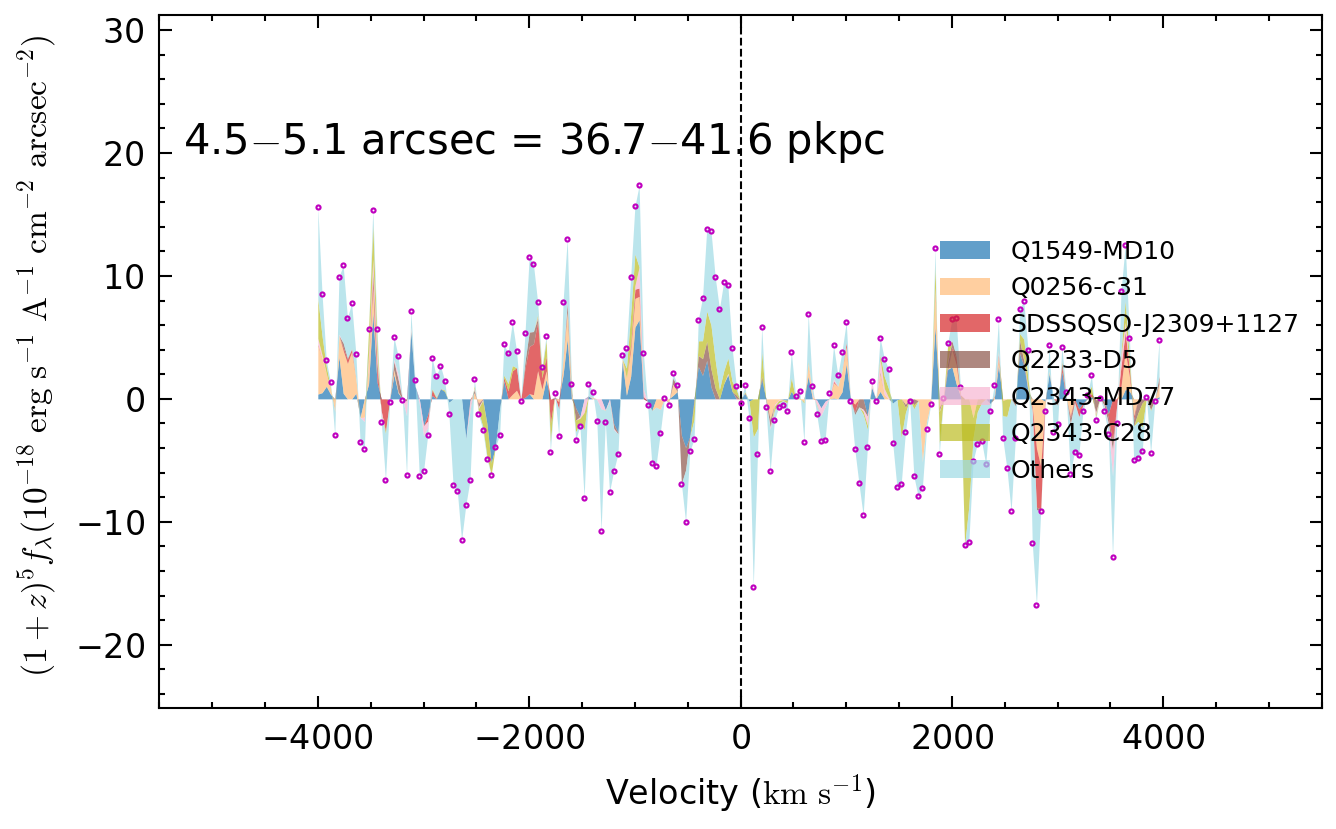

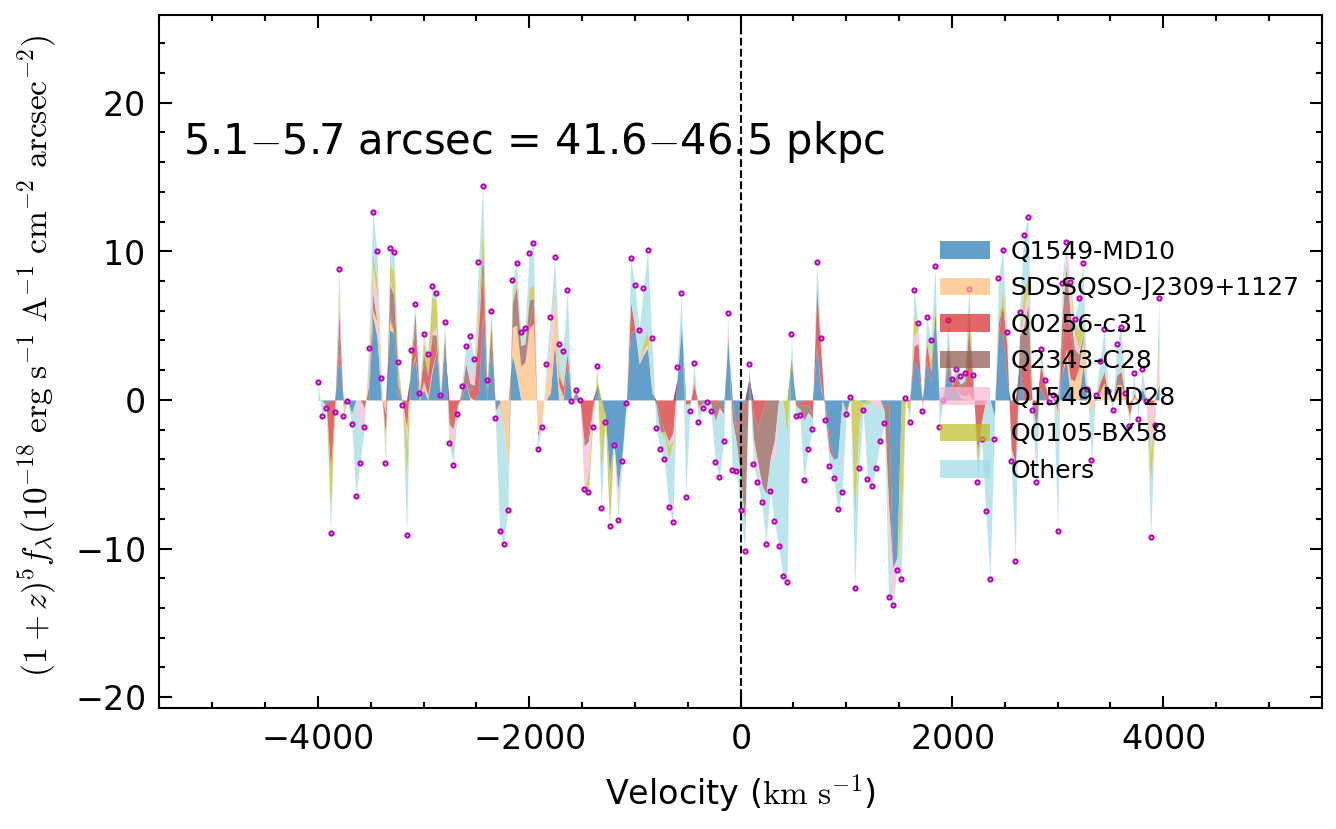

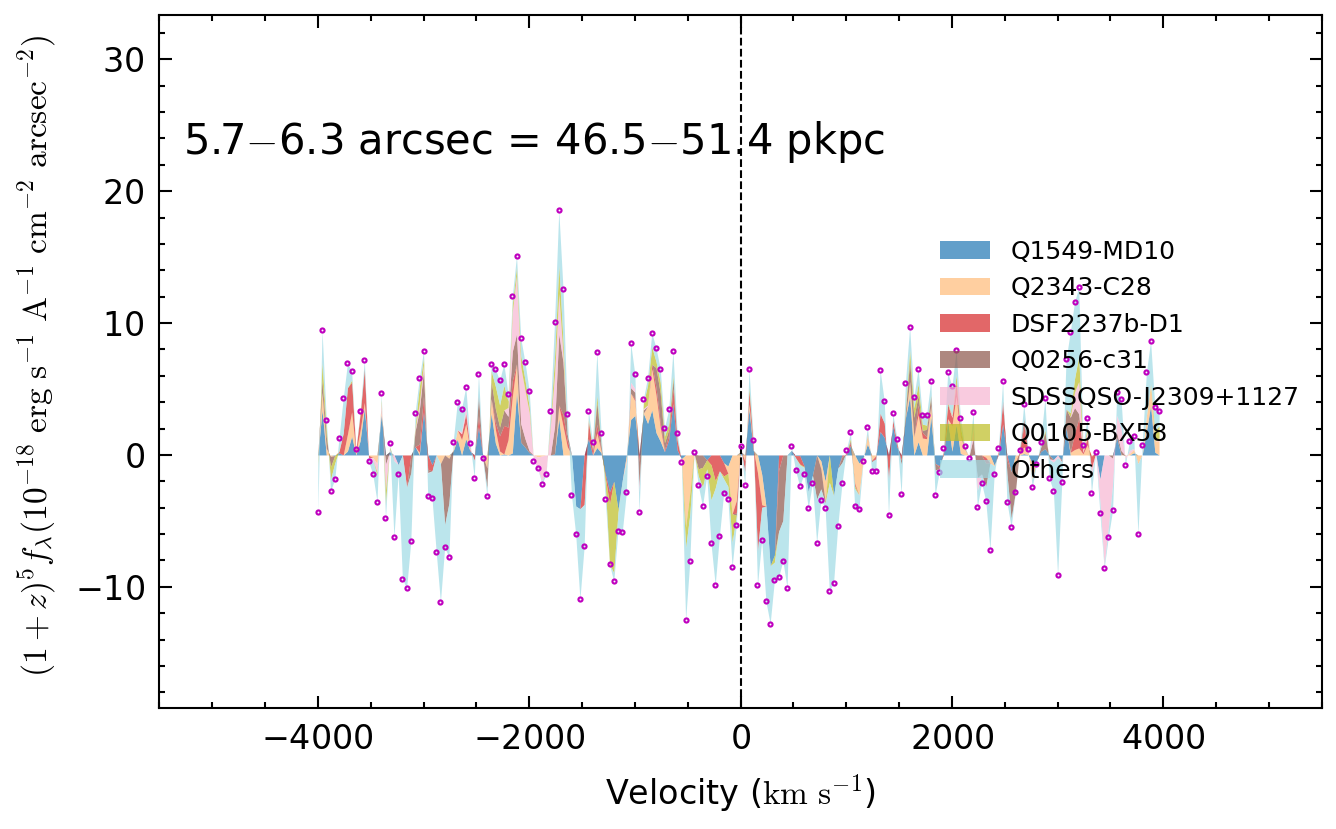

In [292]:
#for xind in range(31):
importlib.reload(common_tools_yd)
from tqdm import tqdm
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
vgrid = np.arange(-5500, 5501, 1)
wgrid = 1215.67*(vgrid/3e5+1)*(1+2.65)
efactor=100
plotmodel=False
plotQSO=False
normalize=False
savemod=False
saveresult=False
savefig=False
#sourcetype="obscured_detected" #must be among "unobscured_detected", "obscured_detected", "nondetections"

savetopath=KBSSpath+f"/faint_qsos/result/stacking/{sourcetype}"#"unobscured_detected"
fixFWHM=True
SBblue=[]
SBred=[]

if plotQSO:
    cmean,cmedian,_   =sigma_clipped_stats(result_QSO[0][cind,:],maxiters=None)
    cmax=np.max(result_QSO[0][cind,:]-cmedian)
result_path=KBSSpath+f"/faint_qsos/result/stacking/{sourcetype}"
read_result=False
if read_result:
    KBvgrid=np.loadtxt(result_path+f"/Kinematics_HLQSOstack_Lya_{lowz_arcsec:.1f}_mod1.txt",usecols=0)
    if os.path.exists(result_path+f"/Kinematics_HLQSOstack_Lya_{lowz_arcsec:.1f}_mod1.txt"):
        KBymod1=np.loadtxt(result_path+f"/Kinematics_HLQSOstack_Lya_{lowz_arcsec:.1f}_mod1.txt",usecols=1)
        KBymod2=np.loadtxt(result_path+f"/Kinematics_HLQSOstack_Lya_{lowz_arcsec:.1f}_mod2.txt",usecols=1)
def plot1Dspec(result,xnew,ynew,xind,vgrid,show_fitinfo=False,saveresult=False,fixFWHM=False,savefig=False,read_result=False,show_distance=True,xlim=[-5500,5500]\
               ,ylabel=r" $(1+z)^{5}f_{\lambda}\rm (10^{-18}~erg~s^{-1}~A^{-1}~cm^{-2}~arcsec^{-2})$"\
               ,xlabel=r"Velocity ($\rm km~s^{-1}$)",weights=False\
               ,yup=None,ax=None,efactor=100,savetopath=".",plotmodel=True,plotQSO=False,normalize=False,savemod=False):
    if normalize:
        wc=(xnew/3e5*1215.67+1215.67)*(1+2.65) 
        efactor=1/np.trapz(result[0][xind,:],x=wc)
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,3),dpi=300)
    else:
        fig=plt.gcf()
    if weights:
        weights_y=result[-1][:,xind,:]
    if plotmodel:
        if fixFWHM:
            sigma0 = 800/2.355
            sigma1 = 1200/2.355
            flat_chain=result[4][xind]
            #p_lo = np.percentile(flat_chain, 31.7310507863,axis=0)
            #p_hi = np.percentile(flat_chain, 68.2689492137,axis=0)
            if sourcetype=="obscured_detected":
                p00,p01,p03,p10,p11,p13 = np.percentile(flat_chain, 50.0,axis=0)
                mod1s = np.array([common_tools_yd.sym_gauss(vgrid,theta[0],theta[1],theta[2]) for theta in flat_chain])
                mod2s = np.array([common_tools_yd.sym_gauss(vgrid,theta[3],theta[4],theta[5]) for theta in flat_chain])
            else:
                p00,p03,p10,p13 = np.percentile(flat_chain, 50.0,axis=0)
                mod1s = np.array([common_tools_yd.sym_gauss(vgrid,theta[0],sigma0,theta[1]) for theta in flat_chain])
                mod2s = np.array([common_tools_yd.sym_gauss(vgrid,theta[2],sigma1,theta[3]) for theta in flat_chain])
        else:
            p00, p01, p02, p03, p10, p11, p12, p13, p0, vp0, fwhm0, p1, vp1, fwhm1, trough, vt=result[3][xind,:]
            p00err, p01err, p02err, p03err, p10err, p11err, p12err, p13err, p0err, vp0err, fwhm0err, p1err, vp1err, fwhm1err, trougherr, vterr=result[4][xind,:]
            if (p13<=0 and p03>0):
                mod = common_tools_yd.skew_gauss(vgrid, p00, p01, p02, p03)
                string1=f"FWHM = {fwhm0:.0f}$\pm${fwhm0err:.0f} km/s"
                string2="$V_\mathrm{shift}$"+f" = {vp0:.0f}$\pm${vp0err:.0f} km/s"
            elif (p13>0 and p03<=0):
                mod = common_tools_yd.skew_gauss(vgrid, p10, p11, p12, p13)
                string1=f"FWHM = {fwhm1:.0f}$\pm${fwhm1err:.0f} km/s"
                string2="$V_\mathrm{shift}$"+f" = {vp1:.0f}$\pm${vp1err:.0f} km/s"
            elif (p13<0 and p03<0):
                print(p00, p01, p02, p03, p10, p11, p12, p13)
                mod = common_tools_yd.lya_model_2(vgrid, p00, p01, p02, p03, p10, p11, p12, p13)
                string1=""
                string2=""

            #string=f"FWHM = {fwhm1:.1f}$\pm${fwhm1err:.1f}; Velocity = {vp1:.1f}$\pm${vp1err:.1f} km/s"#; skewness = {p02:.1f}$\pm${p02err:.1f}"
        if fixFWHM:
            if sourcetype=="obscured_detected":
                mod = common_tools_yd.lya_model_4(vgrid, p00,p01, p03, p10, p11, p13)
            else:
                mod = common_tools_yd.lya_model_3(vgrid, p00, p03, p10, p13)
            mod1 = np.percentile(mod1s, 50.0,axis=0)
            mod2 = np.percentile(mod2s, 50.0,axis=0)
            #mod1 = common_tools_yd.sym_gauss(vgrid, p00, sigma0, p03)
            #mod1_err = common_tools_yd.sym_gauss(vgrid, p00, sigma0, p03+p03err)-common_tools_yd.sym_gauss(vgrid, p00, sigma0, p03-p03err)
            #mod2 = common_tools_yd.sym_gauss(vgrid, p10, sigma1, p13)
            #mod2_err = common_tools_yd.sym_gauss(vgrid, p10, sigma1, p13+p13err)-common_tools_yd.sym_gauss(vgrid, p10, sigma1, p13-p13err)

            w1=np.trapz(mod1*wgrid,wgrid)/np.trapz(mod1,wgrid)
            w2=np.trapz(mod2*wgrid,wgrid)/np.trapz(mod2,wgrid)
            if w1<w2 and sourcetype!="obscured_detected":
                print(w1,"<",w2)
                SBblue.append([np.trapz(tmpmod,wgrid) for tmpmod in mod1s])
                #SBblue_err.append(np.trapz(mod1_err,wgrid))
                SBred.append([np.trapz(tmpmod,wgrid) for tmpmod in mod2s])
            elif sourcetype!="obscured_detected":
                print("Warning:",w1,">",w2)
                SBblue.append([np.trapz(tmpmod,wgrid) for tmpmod in mod2s])
                #SBblue_err.append(np.trapz(mod1_err,wgrid))
                SBred.append([np.trapz(tmpmod,wgrid) for tmpmod in mod1s])

            #SBred_err.append(np.trapz(mod2_err,wgrid))
            string1=f"FWHM = {sigma0*2.355:.0f}, {sigma1*2.355:.0f} km/s"
            string2="$V_\mathrm{shift}$"+f" = {p00:.0f}, {p10:.0f} km/s"
            ax.plot(vgrid,mod1*efactor,"C2",label="Component 1",lw=1.0)
            ax.plot(vgrid,mod2*efactor,"C3",label="Component 2",lw=1.0)

        elif p13>0 and p03>0:
            if  (p03>0.15*p13):
                mod = common_tools_yd.lya_model_2(vgrid, p00, p01, p02, p03, p10, p11, p12, p13)
                mod1 = common_tools_yd.skew_gauss(vgrid, p00, p01, p02, p03)
                mod2 = common_tools_yd.skew_gauss(vgrid, p10, p11, p12, p13)
                string1=f"FWHM = {fwhm0:.0f}$\pm${fwhm0err:.0f}, {fwhm1:.0f}$\pm${fwhm1err:.0f} km/s"
                string2="$V_\mathrm{shift}$"+f" = {vp0:.0f}$\pm${vp0err:.0f}, {vp1:.0f}$\pm${vp1err:.0f} km/s"

                ax.plot(vgrid,mod1*efactor,"C2",label="Component 1",lw=1.0)
                ax.plot(vgrid,mod2*efactor,"C3",label="Component 2",lw=1.0)
                if savemod:
                    np.savetxt(savetopath+f"/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}_mod1.txt",np.array([vgrid,mod1*efactor]).T)
                    np.savetxt(savetopath+f"/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}_mod2.txt",np.array([vgrid,mod2*efactor]).T) 
            else:
                mod = common_tools_yd.lya_model_2(vgrid, p00, p01, p02, p03, p10, p11, p12, p13)
                string1=f"FWHM = {fwhm1:.0f}$\pm${fwhm1err:.0f} km/s"
                string2="$V_\mathrm{shift}$"+f" = {vp1:.0f}$\pm${vp1err:.0f} km/s"
        if sourcetype=="obscured_detected":
                SBblue.append([np.trapz(tmpmod,wgrid) for tmpmod in (mod1s+mod2s)])
            
        if savemod:
            np.savetxt(savetopath+f"/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}_mod.txt",np.array([vgrid,mod*efactor]).T)


            #string=f"FWHM = {fwhm0:.0f}$\pm${fwhm0err:.1f}, {fwhm1:.0f}$\pm${fwhm1err:.1f}; Velocity = {vp0:.1f}$\pm${vp0err:.1f}, {vp1:.1f}$\pm${vp1err:.1f};"+"\n"\
            #+f"skewness = {p02:.1f}$\pm${p02err:.1f}, {p12:.1f}$\pm${p12err:.1f}; Peak = {p0*efactor:.1f}$\pm${p0err*efactor:.1f}, {p1*efactor:.1f}$\pm${p1err*efactor:.1f}"
                        #+f"Amplitude = {p0*efactor:.2f}$\pm${p0err*efactor:.2f}, {p1*efactor:.2f}$\pm${p1err*efactor:.2f}"

            #if np.isfinite(trough):
            #    string+=f"\n trough at {vt:.1f}$\pm${vterr:.1f}"
        if show_fitinfo:
            
            ax.text(0.02,0.93,string1,transform=ax.transAxes,color="k",fontsize=10)
            ax.text(0.02,0.865,string2,transform=ax.transAxes,color="k",fontsize=10)
        ax.plot(vgrid,mod*efactor,"--C1",label="Full model")
        
    ax.axvline(x=0,ls="--",lw=0.5,color="k")
    profile_y = result[0][xind,:]*efactor
    #,yerr=result[2][xind,:]*efactor
    ax.errorbar(xnew,profile_y,fmt="o",mfc='none',ms=0.5,color="m",ecolor="m",lw=0.5)
    
    N_show=6
    alpha_fill=0.7
    #labels=None
    fields=qsotab["Field"].tolist()
    names=qsotab["Name"].tolist()
    contrib = weights_y*profile_y[None,:]
    tot_contrib = np.nan_to_num(contrib).sum(axis=1)
    order = np.argsort(tot_contrib)[::-1]
    top_idx = order[:N_show]
    other_idx = order[N_show:]
    cmap = plt.cm.get_cmap("tab20", N_show + (1 if len(other_idx) > 0 else 0))
    y_bottom = np.zeros_like(xnew)
    
    
    
    for rank, obj_idx in enumerate(top_idx):
        y_top = y_bottom + contrib[obj_idx, :]

        lbl = fields[obj_idx]+"-"+names[obj_idx]#labels[obj_idx] if labels is not None else f"Obj {obj_idx}"
        ax.fill_between(
            xnew,
            y_bottom,
            y_top,
            color=cmap(rank),
            alpha=alpha_fill,
            label=lbl,
            linewidth=0.0,
        )
        y_bottom = y_top

    # Group the rest as "Others"
    if len(other_idx) > 0:
        contrib_other = np.nan_to_num(contrib[other_idx, :]).sum(axis=0)
        y_top = y_bottom + contrib_other
        ax.fill_between(
            xnew,
            y_bottom,
            y_top,
            color=cmap(N_show),
            alpha=alpha_fill,
            label="Others",
            linewidth=0.0,
        )
        y_bottom = y_top
    
    if False:#saveresult:
        np.savetxt(savetopath+f"/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}_data.txt",np.array([xnew,result[0][xind,:]*efactor,result[2][xind,:]*efactor]).T)

    #ax.step(xnew,np.sqrt(result_var[0][xind,:])*efactor,lw=0.5,ls="--",color="red",label="Std. dev.")
    #submean,submedian,_ =sigma_clipped_stats(result[0][xind,:],maxiters=None)
    
    if plotQSO:
        ccfac=np.max(result[0][xind,:])/cmax*2.5
        cind=0
        qsoyerr=result_QSO[2][cind,:]*efactor*ccfac
        ax.errorbar(xnew,(result_QSO[0][cind,:]-cmedian)*efactor*ccfac,fmt="--",mfc='none',ms=0.5,color="C4",ecolor="r",lw=1,alpha=1.0,label="Unsubtracted PSF central")
    
    #
    ax.set_xlabel(xlabel)
    if normalize:
        ax.set_ylabel(r"Normalized SB")
    else:
        ax.set_ylabel(ylabel)
    ax.set_xlim(xlim)
    if yup is None:
        yup=1.8*np.max(result[0][xind,:])
    ax.set_ylim([1.5*np.min(result[0][xind,:]*efactor),yup*efactor])
    #ax.set_ylim([-0.1,10])
    #ax.text(0.05,0.75,f"Distance from QSO: {ynew[xind]*kpc_per_arcsec:.1f} pkpc = {ynew[xind]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)
    binwidth=np.mean(np.diff(ynew))
    if show_distance:
        ax.text(0.02,0.8,f"{ynew[xind]:.1f}$-${ynew[xind]+binwidth:.1f} arcsec = {ynew[xind]*kpc_per_arcsec:.1f}$-${(ynew[xind]+binwidth)*kpc_per_arcsec:.1f} pkpc",transform=ax.transAxes,color="k",fontsize=10)
        #ax.text(0.02,0.8,f"{ynew[xind]*kpc_per_arcsec:.1f}$-${(ynew[xind]+binwidth)*kpc_per_arcsec:.1f} pkpc",transform=ax.transAxes,color="k",fontsize=10)

    #ax.text(0.05,0.65,r"Masked in spectral region $\pm 3000\,\rm km/s$",transform=ax.transAxes,color="k",fontsize=6)
    if savefig:
        fig.savefig(savetopath+f"/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}.pdf")
    #np.savetxt(savetopath+f"/Kinematics_HLQSOstack_Lya_{ynew[xind]*kpc_per_arcsec:.0f}_data.txt",np.array([xnew,result[0][xind,:]*efactor,result[2][xind,:]*efactor]).T)
    #plt.savefig(savetopath+f"/Kinematics_HLQSOstack_Lya_{ynew[xind]*kpc_per_arcsec:.0f}.pdf")
    return fig,ax
#csmean,csmedian,_=sigma_clipped_stats(result_QSO[0][cind,:]-cmedian,maxiters=None)



for yind in tqdm(range(len(ynew))):#range(0, 40):
    fig,ax=plot1Dspec(result,xnew,ynew,yind,vgrid,show_fitinfo=True\
                      ,saveresult=saveresult,fixFWHM=fixFWHM,ax=None,weights=True\
                      ,efactor=100,savefig=savefig,savetopath=savetopath,savemod=savemod,plotmodel=plotmodel,plotQSO=plotQSO,normalize=normalize)
    ax.legend(loc="right",fontsize=6)
if fixFWHM and sourcetype!="obscured_detected" and False:
    y_data_list=[np.mean(SBblue,axis=1),np.mean(SBred,axis=1)]
    y_data_err_list=[np.std(SBblue,axis=1),np.std(SBred,axis=1)]
    np.savetxt(savetopath+f"/SB_blue.txt",np.array([ynew,y_data_list[0],y_data_err_list[0]]).T)
    np.savetxt(savetopath+f"/SB_red.txt",np.array([ynew,y_data_list[1],y_data_err_list[1]]).T)  
elif fixFWHM and sourcetype=="obscured_detected":
    print("finished")
    #np.savetxt(savetopath+f"/SB_all.txt",np.array([ynew,np.mean(SBblue,axis=1),np.std(SBblue,axis=1)]).T)

    
    

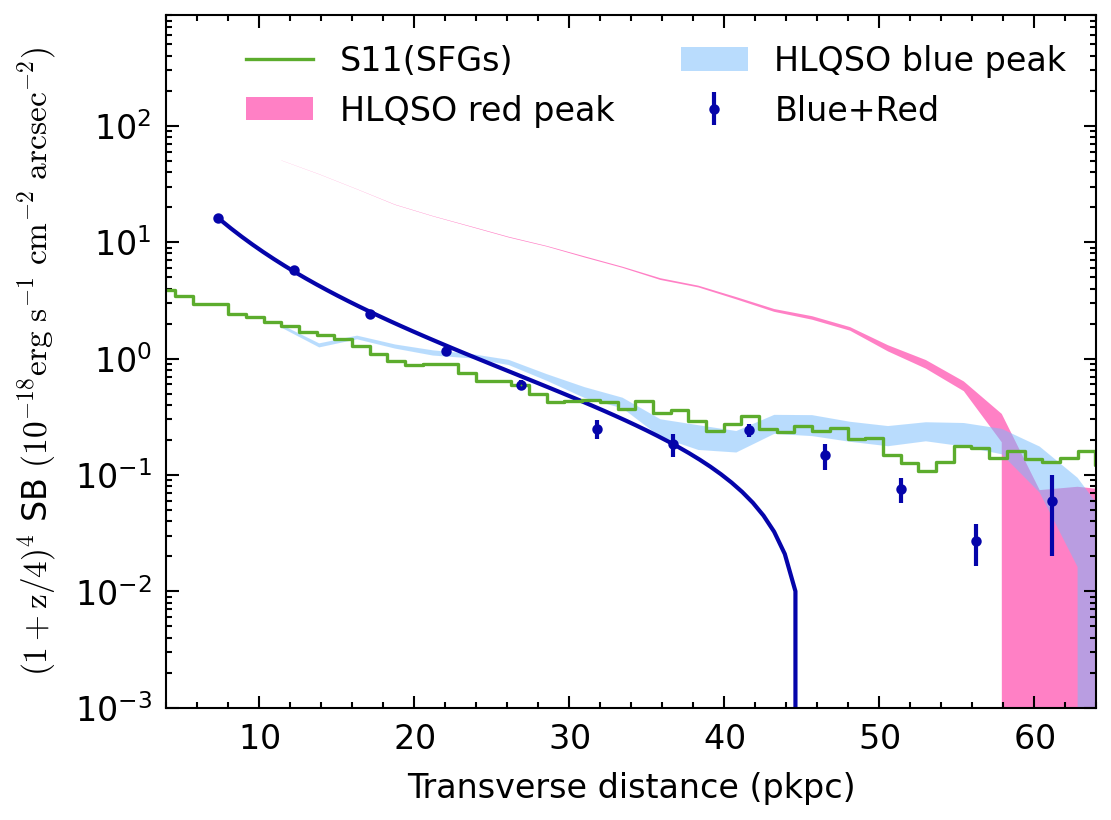

In [28]:
from astropy.modeling import Fittable1DModel, Parameter
import emcee
from astropy.modeling import models
from scipy.optimize import curve_fit
from scipy import signal
from importlib import reload
reload(common_tools_yd)
from common_tools_yd import spatial_profile_2exp,spatial_profile_1exp,spatial_profile_expMoffat,spatial_profile_Moffat,spatial_profile_expPow,spatial_profile_S11
class OffsetExponential1D(Fittable1DModel):
    amplitude = Parameter()
    tau = Parameter()
    offset = Parameter()
    x_offset = Parameter()

    @staticmethod
    def evaluate(x, amplitude, tau, offset, x_offset):
        return amplitude * np.exp(-(x - x_offset) / tau) + offset

    @staticmethod
    def fit_deriv(x, amplitude, tau, offset, x_offset):
        exp_term = np.exp(-(x - x_offset) / tau)
        d_amplitude = exp_term
        d_tau = amplitude * (x - x_offset) * exp_term / tau**2
        d_offset = np.ones_like(x)
        d_x_offset = amplitude * exp_term / tau
        return [d_amplitude, d_tau, d_offset, d_x_offset]
'''
def log_likelihood(theta, x, y, yerr, model):
    model.parameters = theta
    y_model = model(x)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - y_model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    amp_exp, tau_exp, offset_exp, x_offset_exp, amp_pow, x0_pow, alpha_pow, amp_exp2, tau_exp2 = theta
    if (0 < amp_exp < 100 and 0 < tau_exp < 50 and -10 < offset_exp < 10 and 0 < x_offset_exp < 50 and
        0 < amp_pow < 100 and 0 < x0_pow < 50 and -5 < alpha_pow < 5 and 0 < amp_exp2 < 100 and -50 < tau_exp2 < 0):
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr, model):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, model)
'''
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})



#S2011=np.genfromtxt(KBSSpath+"/Steidel2011.csv",delimiter=",")
S2011_all=np.genfromtxt(KBSSpath+"/SFG_S11/all_lya.avg.final.dat")
S2011_emitter=np.genfromtxt(KBSSpath+"/SFG_S11/lya_em.avg.final.skysub.dat")
S2011_blobs=np.genfromtxt(KBSSpath+"/SFG_S11/all_blobs_avg.dat")

efactor=100
#B2016=np.genfromtxt(KBSSpath+"/Borisova2016.csv",delimiter=",")
#F2019=np.genfromtxt(KBSSpath+"/FAB2019.csv",delimiter=",")


fig, ax = plt.subplots(figsize=(4,3),dpi=300)


SFGarcsec2kpc=Planck18.kpc_proper_per_arcmin(3.15).value/60
C2025w=np.arange(5,100,2)
MFWHM=1.805*SFGarcsec2kpc
gamma=MFWHM/2/np.sqrt(2**(1/2.24)-1)
Am=2.14; Aexp=0.218; rexp=3.68*SFGarcsec2kpc
C2025blue=spatial_profile_expMoffat(C2025w,Aexp,rexp,Am,gamma)
MFWHM=1.718*SFGarcsec2kpc
gammar=MFWHM/2/np.sqrt(2**(1/2.24)-1)
Amr=8.95; Aexpr=0.016; rexpr=8.2*SFGarcsec2kpc
C2025red=spatial_profile_expMoffat(C2025w,Aexpr,rexpr,Amr,gammar)
#ax.plot(C2025w,C2025blue*((1+2.65)/4)**4,color="xkcd:sky blue",label="C25 (blue)")
#ax.plot(C2025w,C2025red*((1+2.65)/4)**4,color="xkcd:hot pink",label="C25 (red)")





#initial_guess2 = [1, 5, 1, 15]  # Initial guess for the parameters
#initial_guess1 = [1.1e4,5.5, 1, 5]
#initial_guess1 = [1.1e4,5.5, 100, 15]
#initial_guess1 = [1, -1, 30,30]  # Initial guess for the parameters

initial_guess1 = [1, 10]
#initial_guess0 = [1, 10]
initial_guess0 = [100, 0.5,1e6,4]
#fitfunc=spatial_profile_2exp
#fitfunc=spatial_profile_1exp

kpc_per_arcsec=Planck18.kpc_proper_per_arcmin(2.65).value/60
cut1=0
cut2=29
scolor=["Blue","Red"]
colorl=["xkcd:royal blue","xkcd:light red"]
markerl=["o","o"]

sourcetype="obscured_detected" #must be among "unobscured_detected", "obscured_detected", "nondetections"
resultpath=KBSSpath+"/faint_qsos/result/stacking/"+sourcetype#unobscured_detected"
if sourcetype=="unobscured_detected":
    SB_blue=np.loadtxt(resultpath+"/SB_blue.txt")
    SB_red=np.loadtxt(resultpath+"/SB_red.txt")
    sidelist=[0,1]
elif sourcetype=="obscured_detected":
    SB_blue=np.loadtxt(resultpath+"/SB_all.txt")
    scolor=["Blue+Red"]
    sidelist=[0]

HLQSOresultpath=KBSSpath+"/QSOs_r6_masked_pub3"
SB_blue_HLQSO=np.loadtxt(HLQSOresultpath+"/SB_blue.txt")
SB_red_HLQSO=np.loadtxt(HLQSOresultpath+"/SB_red.txt")

y_HLQSO_data_list=[SB_blue_HLQSO[:,1],SB_red_HLQSO[:,1]]
y_HLQSO_data_err_list=[SB_blue_HLQSO[:,2],SB_red_HLQSO[:,2]]
x_HLQSO_data=SB_blue_HLQSO[:,0]*kpc_per_arcsec

if sourcetype!="obscured_detected":
    y_data_list=[SB_blue[:,1],SB_red[:,1]]
    y_data_err_list=[SB_blue[:,2],SB_red[:,2]]
else:
    y_data_list=np.array([SB_blue[:,1],np.full_like(SB_blue[:,1],np.nan)])
    y_data_err_list=np.array([SB_blue[:,2],np.full_like(SB_blue[:,2],np.nan)])

#ffunc=[spatial_profile_S11,spatial_profile_expPow]
ffunc=[spatial_profile_S11,spatial_profile_1exp]

#ffunc=[spatial_profile_1exp,spatial_profile_1exp]

sresult={}
for side in sidelist:
    fitfunc=ffunc[side]
    if side == 1:
        initial_guess=initial_guess1
    elif side == 0:
        initial_guess=initial_guess0
    x_data=SB_blue[:,0][cut1:cut2]*kpc_per_arcsec
    y_data=np.array(y_data_list[side][cut1:cut2])*efactor
    y_err=np.array(y_data_err_list[side][cut1:cut2])*efactor
    ax.errorbar(x_data,y_data,yerr=y_err,
            label=scolor[side],
            color=colorl[side],
                marker=markerl[side],
                mfc="none",
                ms=1.5,
            capsize=0.0,
            ls="None",
                alpha=1.0,
            lw=1.0)
    if False:#side == 0:
        ratio_b2r=spatial_profile_expMoffat(x_data,Aexp,rexp,Am,gamma)/spatial_profile_expMoffat(x_data,Aexpr,rexpr,Amr,gammar)
        ax.errorbar(x_data,y_data*(1+1/ratio_b2r),yerr=y_err
                ,fmt="o",
            #label=r"SB$_{\rm blue}\times$(SB$_{\rm red}$/SB$_{\rm blue}$+1)",
            label=r"SB$_{scattering}$",
            color="xkcd:hot pink",
                mfc="none",
                ms=2.,
            capsize=0.0,
            ls="None",
                alpha=1.0,
            lw=1.0)
        
    #model=models.Moffat1D(amplitude=1e-17,x_0=0)
    #model.x_0.fixed=True
    # Fit the model
    fcut1=0
    fcut2=10
    params, covariance = curve_fit(fitfunc, x_data[fcut1:fcut2], y_data[fcut1:fcut2],maxfev=10000, p0=initial_guess, absolute_sigma=True)
    sresult[scolor[side]]=params
    #fitted_model = fitter(model,x_data[:fcut],y_data[:fcut],weights=1/y_err[:fcut]**2)
    x_fit = np.linspace(2,70, 100)
    #y_fit=fitted_model(x_fit)
    #y_fit=fitfunc(x_fit, *params)
    #if side==0:
   #     y_fit=fitfunc(x_fit, *[80,0.5,1e4,5])
    #else:
    y_fit=fitfunc(x_fit, *params)
    
    #
    #if side==2:
    ax.plot(x_fit[8:],y_fit[8:],color=colorl[side],alpha=1,ls="-")
    if False:#side==1:
        y_fit_comp1=fitfunc(x_fit,params[0],params[1],0,1,1,params[5])
        y_fit_comp2=fitfunc(x_fit,0,1,params[2],params[3],params[4],params[5])
        ax.plot(x_fit,y_fit_comp1,ls="--",color=colorl[side],lw=0.5,alpha=0.3)
        ax.plot(x_fit,y_fit_comp2,ls="--",color=colorl[side],lw=0.5,alpha=0.3)

#ax.plot(B2016[:,0],B2016[:,1]*1e18,color="m",label="B16")
ax.step(S2011_all[:,0]*kpc_per_arcsec,S2011_all[:,1]*((1+2.65)/4)**4,color="xkcd:grass",label="S11(SFGs)",lw=0.8)

y_HLQSO_red_up=y_HLQSO_data_list[1]+y_HLQSO_data_err_list[1]
y_HLQSO_red_low=y_HLQSO_data_list[1]-y_HLQSO_data_err_list[1]

y_HLQSO_blue_up=y_HLQSO_data_list[0]+y_HLQSO_data_err_list[0]
y_HLQSO_blue_low=y_HLQSO_data_list[0]-y_HLQSO_data_err_list[0]

ax.fill_between(
    x_HLQSO_data, y_HLQSO_red_low*efactor, y_HLQSO_red_up*efactor,
    facecolor='xkcd:hot pink',     # No solid fill
   # hatch='//',          # Hatching pattern
    edgecolor='none',     # Color of hatch lines
    linewidth=0.0,
    label='HLQSO red peak',
    alpha=0.5# No border lines
)

ax.fill_between(
    x_HLQSO_data, y_HLQSO_blue_low*efactor, y_HLQSO_blue_up*efactor,
    facecolor="xkcd:sky blue",     # No solid fill
   # hatch='//',          # Hatching pattern
    edgecolor='none',     # Color of hatch lines
    linewidth=0.0,
    label='HLQSO blue peak',
    alpha=0.5# No border lines
)
"""
ax.errorbar(x_HLQSO_data,y_HLQSO_data_list[1]*efactor,yerr=y_HLQSO_data_err_list[1]*efactor,
            label=r"Red$_{\rm HLQSO}$",
            color="xkcd:hot pink",
                mfc="none",
                ms=2.,
            capsize=0.0,
            ls="--",
                alpha=1.0,
            lw=1.0)
ax.errorbar(x_HLQSO_data,y_HLQSO_data_list[0]*efactor,yerr=y_HLQSO_data_err_list[0]*efactor,
            label=r"Blue$_{\rm HLQSO}$",
            color="xkcd:sky blue",
                mfc="none",
                ms=2.,
            capsize=0.0,
            ls="--",
                alpha=1.0,
            lw=1.0)
"""
#ax.step(S2011_emitter[:,0]*kpc_per_arcsec,S2011_emitter[:,1]*((1+2.65)/4)**4,color="xkcd:brick red",label=r"S11(Ly$\alpha$ Em)")
#ax.step(S2011_blobs[:,0]*kpc_per_arcsec,S2011_blobs[:,1]*((1+2.65)/4)**4,color="xkcd:salmon pink",label=r"S11(Ly$\alpha$ Blobs)")

#ax.plot(F2019[:,0],F2019[:,1]*1e18*((1+3.15)/4)**4,color="C6",label="AB19")


G09x=[11.96,16.58,23.00,61.20]
G09y=np.array([5.57,2.00,1.64,0.26])
#ax.plot(G09x,G09y*((1+3.12)/4)**4,color="xkcd:lavender",ls="--",marker="^",ms=1.5,label="SMG1")
G15x=[11.79,16.36,22.65]
G15y=np.array([10.26,4.12,1.32])
#ax.plot(G15x,G15y*((1+3.375)/4)**4,color="xkcd:orange",ls="--",marker="s",alpha=0.5,ms=1.5,label="SMG2")


#ax.axvline(x=7.4*kpc_per_arcsec,ls=":")
#ax.plot(x_fit,fitted_model[1](x_fit),"r")
#ax.axvline(kpc_per_arcsec*0.3*15,ls="--",lw=0.5)
#ax.set_title("{}-{}".format(field,sourcename))
ax.set_xlim([4,64])
ax.set_ylim([0.001,900])
ax.set_yscale("log")
#ax.set_xscale("log")
ax.legend(ncol=2)
ax.set_xlabel("Transverse distance (pkpc)")
#ax.set_xlabel("Transverse distance (arcsec)")

ax.set_ylabel(r"$\rm (1+z/4)^{4}$ SB $\rm (10^{-18} erg~s^{-1}~cm^{-2}~arcsec^{-2})$")

fig.savefig(KBSSpath+f"/faint_qsos/result/stacking/{sourcetype}/SB_radial.pdf")

# try rmax at 6 arcsec?

In [103]:
sresult

{'Blue': array([4.46820760e+01, 9.17313285e-05, 6.45152776e+06, 3.96029612e+00]),
 'Red': array([ 4.65543508, 19.9275557 ])}

# 3. reproject PSF subtracted cube onto cylindrical system: Hyperluminous QSOs

## Read data and do the stacking

In [15]:
subhdu=fits.open("/disk/bifrost/yuanze/KBSS/Q0449/QSO/q0449-qso_icubes_wcs.fits")
psfhdu=fits.open("/disk/bifrost/yuanze/KBSS/CubEx_run/Q0449/psfout.fits")

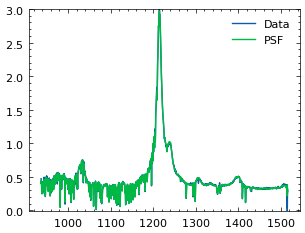

In [18]:
hdr=subhdu[0].header
wave=(np.arange(hdr['NAXIS3']) - hdr['CRPIX3'] + 1) * hdr['CD3_3'] + hdr['CRVAL3']
wave=wave/(1+2.6825)
plt.plot(wave,subhdu[0].data[:,50,50],label="Data")
plt.plot(wave,psfhdu[0].data[:,50,50],label="PSF")
plt.ylim([-0.01,3])
#plt.xlim([1200,1240])

plt.legend()

array([None, None, None], dtype=object)

In [256]:
np.max(psfhdu[0].data[:,xpos,50])

20.00784

Text(0.05, 0.83, 'Q0449')

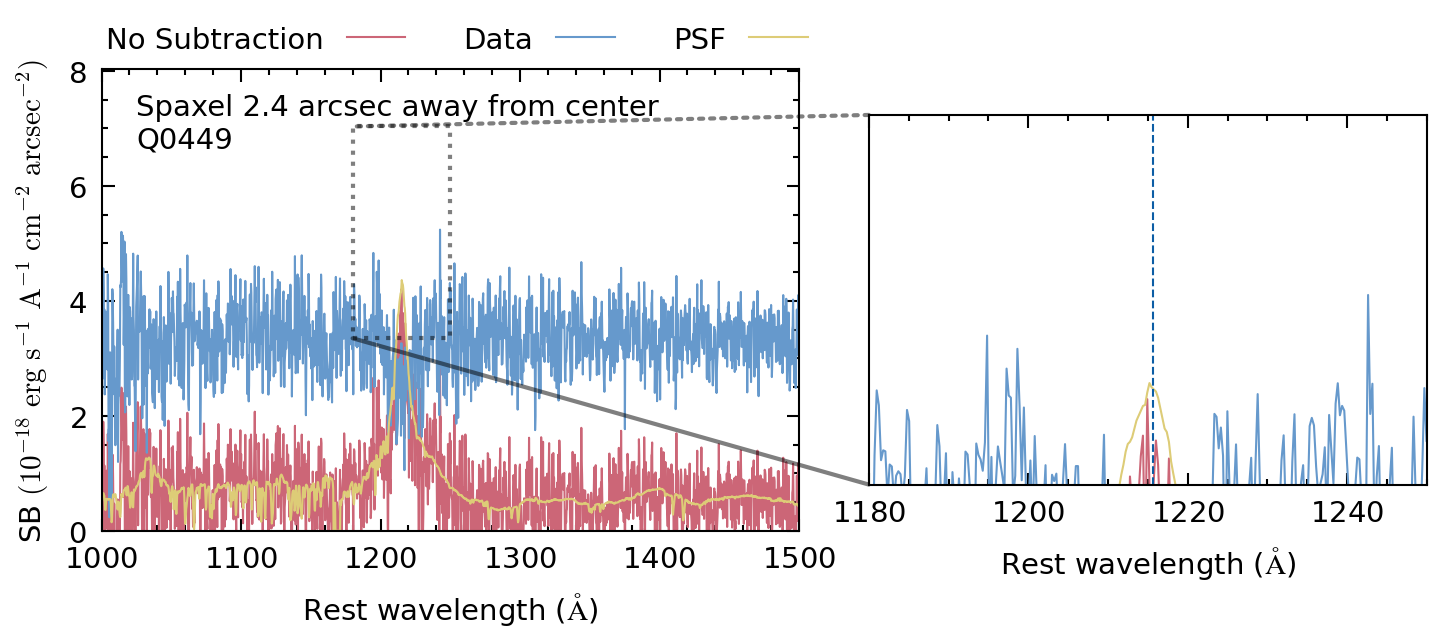

In [57]:
import scienceplots
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":7,
"legend.fancybox":True})

#field="PKS1937-101"
#fname="ADP.2019-01-02T10:51:41.096"
field="Q0449"
subhdu=fits.open("/disk/bifrost/yuanze/KBSS/{}/QSO/{}-qso_icubes_wcs_20.PSFCONTSub.fits".format(field,field.lower()))
qsohdu=fits.open("/disk/bifrost/yuanze/KBSS/{}/QSO/{}-qso_icubes_wcs.fits".format(field,field.lower()))
psfhdu=fits.open("/disk/bifrost/yuanze/KBSS/CubEx_run/{}/psfout.fits".format(field))
#subhdu=fits.open("/disk/bifrost/yuanze/KBSS/MUSEQSO/{}/{}.PSFCONTSub.fits".format(field,fname))
#qsohdu=fits.open("/disk/bifrost/yuanze/KBSS/MUSEQSO/{}/{}.fits".format(field,fname))
#psfhdu=fits.open("/disk/bifrost/yuanze/KBSS/MUSEQSO/{}/psfout.fits".format(field))


colorlst=["#CC6677","#DDCC77","#6699CC"]
fig=plt.figure(figsize=(3,2),dpi=300)
#gs = fig.add_gridspec(1,1, hspace=0)
axs = plt.subplot()

lw=0.5
fac=1.0

hdr=subhdu[0].header
wave=(np.arange(hdr['NAXIS3']) - hdr['CRPIX3'] + 1) * hdr['CD3_3'] + hdr['CRVAL3']
wave=wave/(1+2.6825)
xpos=51
ypos=59

efactor=100
ydasub=subhdu[0].data[:,ypos,xpos]*efactor
ydaqso=qsohdu[0].data[:,ypos,xpos]*efactor
ydapsf=psfhdu[0].data[:,ypos,xpos]*efactor
yup=np.nanmax(ydaqso[100:1500])
axs.plot(wave,ydaqso,colorlst[0],ms=0.5,label="No Subtraction",lw=lw)
#+yup
axs.plot(wave,ydasub+0.5*yup,colorlst[2],ms=0.5,label="Data",lw=lw)
axs.plot(wave,ydapsf,colorlst[1],ms=0.5,label="PSF",lw=lw)


axs.set_xlabel(r"Rest wavelength ($\rm \AA$)")
axs.set_ylabel(r"SB $\rm (10^{-18}~erg~s^{-1}~A^{-1}~cm^{-2}~arcsec^{-2})$")
axs.set_xlim([1000,1500])
axs.text(0.05,0.90,"Spaxel 2.4 arcsec away from center",transform=axs.transAxes)
#axs.text(0.05,0.90,"Spaxel at PSF center",transform=axs.transAxes)
#axs.text(0.05,0.84,r"Log$[\,\xi/$erg$\,$cm$\,$s$^{-1}]=%d $"%logxi,transform=axs.transAxes)
axs.set_ylim([0,1.2*yup])


axins=axs.inset_axes([1.1,0.1,0.8,0.8])

axins.plot(wave,ydaqso,colorlst[0],ms=0.5,label="No Subtraction",lw=lw)
axins.plot(wave,ydapsf,colorlst[1],ms=0.5,label="Reconstructed PSF",lw=lw)
axins.plot(wave,ydasub+0.5*yup,colorlst[2],ms=0.5,label="Data",lw=lw)
#axins.axhline(yup)
axins.axvline(1215.67,ls="--",lw=lw)

axins.set_xlim([1180,1250])
axins.set_ylim([0.5*yup,1.05*yup])
#axins.set_xscale("log")
#axins.set_yscale("log")
axins.set_xlabel(r"Rest wavelength ($\rm \AA$)")
axs.legend(ncol=3,loc="upper right",markerfirst=False,bbox_to_anchor=[1.05,1.15])
rec,clines=axs.indicate_inset_zoom(axins,edgecolor="k",ls=':')
clines[2].set_linestyle(':')
clines[1].set_linestyle(':')
#clines[1].set(arrowstyle='wedge')
axins.set_yticks([])
axins.set_yticklabels([])
#ax3ins.axhline(y=1,c="k",lw=1)

axs.text(0.05,0.83,field,transform=axs.transAxes)


#axs=plt.gca()
#plt.text(0.05,0.9,datype,transform=axs.transAxes)
#fig.savefig(KBSSpath+"/fig/PSF_sub_outs_{}.pdf".format(field))

In [334]:
ydaqso

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [2]:
qsos = ascii.read(KBSSpath+"/KCWI/qsos_bright_updated.list",format="ipac")
#QSOtab=qsos[(qsos['contam']=="False")&(qsos['Field']!="Q1623")]
#QSOtab=qsos#[(qsos['Field']!="Q0142")&(qsos['Field']!="Q1623")]
QSOtab=qsos#[(qsos['Field']=="Q0449")]

In [3]:
QSOtab

<Table length=14>
    Name         aka      Field ...          Mi              z_Lyaneb     
    unit         unit      unit ...                                       
   str11        str13      str5 ...       float64            float64      
----------- ------------- ----- ... ------------------- ------------------
   Q0100+13        PHL957 Q0100 ... -30.321267391475878   2.72238484467835
HS0105+1619          None Q0105 ...  -29.88400104644006 2.6534598943518497
  Q0207-003         UM402 Q0207 ... -30.122461538584293 2.8743148248673793
 Q0449-1645          None Q0449 ...            -29.7854          2.6808366
 Q0821+3107 NVSS0821+3107 Q0821 ... -29.848176827459962 2.6294241961367883
   Q1009+29         CSO38 Q1009 ...  -30.73400104644006  2.651432107741275
  Q1217+490   SBS1217+490 Q1217 ...  -30.01486119098076  2.708454933359138
 Q1442+2931   HS1442+2931 Q1442 ... -30.431893073334017  2.664141101586948
 Q1549+1919   HS1549+1919 Q1549 ... -31.165955755407307  2.847334911697182
HS1603+3820          None Q1603 ... -30.802172282288744 2.5550447110564654
 Q1623-KP77   FBQS1625+26 Q1623 ...  -29.28596666482499              2.534
  HS1700+64          None Q1700 ...  -30.95996016451035 2.7507207351611034
  Q2206-199   LBQS2206-19 Q2206 ... -29.874706698233805  2.576526634363855
   Q2343+12   SDSS2343+12 Q2343 ... -29.694706698233805 2.5809114519896306

In [10]:
import importlib
importlib.reload(kcwi_tools)
radius=6
dovariance=False
doQSO=False
binwidth=20 #kpc
for ind,psname in enumerate(["Q0821+3107","Q1009+29"]):#enumerate(QSOtab['Name']):
    overwrite=True
    sentry=qsos[qsos["Name"]==psname]
    field=sentry["Field"].value[0]
   # if field != 'Q1623':
    subdapath=KBSSpath+"/"+field+"/QSO"
    if dovariance:
        Subfile = subdapath+"/{}-qso_vcubes.fits".format(field.lower())
        writefn=subdapath+"/{}-qso_vcubes_masked.cyli.fits".format(field.lower())
    elif doQSO:
        Subfile = subdapath+"/{}-qso_icubes_wcs.fits".format(field.lower())
        writefn=subdapath+"/{}-qso_icubes_wcs.sat.cyli.fits".format(field.lower())
    else:
        Subfile = subdapath+"/{}-qso_icubes_wcs_{}.PSFCONTSub.fits".format(field.lower(),int(radius/0.3))
        writefn=subdapath+"/{}-qso_icubes_wcs_r{}_masked.cyli.fits".format(field.lower(),radius)
        #writefn=subdapath+"/{}-qso_icubes_wcs_r{}_masked_Rhbinned_{}.cyli.fits".format(field.lower(),radius,binwidth)
    xpix = sentry["x"].value[0]
    ypix = sentry["y"].value[0]
        
    #else:
       # continue
        #name=sentry["Name"].split[1]
        #subdapath=KBSSpath+"/"+field+"/"+name
        #Subfile = subdapath+"/kcwi_oned/{}-{}_icubes_wcs.PSFCONTSub.fits".format(field.lower(),name)
        #xpix = sentry["x"].value[0]
        #ypix = sentry["y"].value[0]
        #writefn=subdapath+"/kcwi_oned/{}-{}_icubes_wcs.cyli.fits".format(cubename.lower(),psname)
    maskfn=subdapath+"/{}-{}_icubes_wcs_{}.PSFSub.mask.fits".format(field.lower(),"qso",int(radius/0.3))
    #if sentry["contam"]=="True":
    #    overwrite=True
    #    maskfn=subdapath+"/{}.reg".format(field)
    #else:
    #    maskfn=''
    if overwrite == True or (not os.path.exists(writefn)):
        print("reprojecting",psname,"to cylindrical system...")
        print("writing:",writefn)
        hdu=fits.open(Subfile)
        hdu[0].header["CNAME3"]="Wavelength"
        hdr=hdu[0].header
        #status=kcwi_tools.cart2cyli(Subfile,[xpix,ypix],hdr=hdr,masktype='direct',cos=Planck18,r_range=[0,10],dr=binwidth/kpc_per_arcsec,maskfn=maskfn,writefn=writefn,montage=True)
        status=kcwi_tools.cart2cyli(Subfile,[xpix,ypix],hdr=hdr,masktype='direct',cos=Planck18,r_range=[0,10],dr=0.3,maskfn=maskfn,writefn=writefn,montage=True)
        hdu.close()
    else:
        print(f"reprojected cube existed for {psname:s}: no stacking performed ")


reprojecting Q0821+3107 to cylindrical system...
writing: /disk/bifrost/yuanze/KBSS/Q0821/QSO/q0821-qso_icubes_wcs_r6_masked.cyli.fits
reading HDU
updating hdr
Using direct mask
Projecting FITS mask to mask_3d...
{'status': '0', 'time': 5.0}
reprojecting Q1009+29 to cylindrical system...
writing: /disk/bifrost/yuanze/KBSS/Q1009/QSO/q1009-qso_icubes_wcs_r6_masked.cyli.fits
reading HDU
updating hdr
Using direct mask
Projecting FITS mask to mask_3d...
{'status': '0', 'time': 6.0}


In [9]:
mf=fits.open(maskfn)

In [11]:
mf[0].data.shape

(100, 100)

## Reprojection completed! Do the stacking.

#### Grid setup

In [53]:
xnew = np.arange(-4000, 4000, 40)
ynew = np.arange(1.4, 8.3, 0.3)
ynew_qso = np.arange(0.3, 3.0, 0.1)

kpc_per_arcsec = Planck18.kpc_proper_per_arcmin(2.65).value/60
ynew_rh = np.arange(0,60/kpc_per_arcsec,20/kpc_per_arcsec)
xcorner = np.append(xnew, xnew[-1]+50) - 25
ycorner = np.append(ynew, ynew[-1]+0.1) - 0.05
xmesh, ymesh = np.meshgrid(xcorner, ycorner)
xcmesh, ycmesh = np.meshgrid(xnew, ynew)

xcont_new = np.arange(-20000, 20000, 100)
ycont_new = np.arange(0, 10, 0.1)
xcont_corner = np.append(xcont_new, xcont_new[-1] + 100) - 50
ycont_corner = np.append(ycont_new, ycont_new[-1] + 0.1) - 0.05
xcont_mesh, ycont_mesh = np.meshgrid(xcont_corner, ycont_corner)
xccont_mesh, yccont_mesh = np.meshgrid(xcont_new, ycont_new)

wcont_full = np.arange(1000, 1700, 0.5)
xcont_full = (wcont_full - 1215.67) / 1215.67 * 3e5 + 1215.67
ycont_full = np.arange(0, 10, 0.1)
dxcont = xcont_full[1] - xcont_full[0]
xcont_full_corner = np.append(xcont_full, xcont_full[-1] + dxcont) - dxcont / 2
ycont_full_corner = np.append(ycont_full, ycont_full[-1] + 0.1) - 0.05
xcont_full_mesh, ycont_full_mesh = np.meshgrid(xcont_full_corner, ycont_full_corner)
xccont_full_mesh, yccont_full_mesh = np.meshgrid(xcont_full, ycont_full)

In [3]:
from scipy import interpolate
cp2d_new = np.full((len(xnew), len(ynew_rh)),fill_value=np.nan)
print("warning: Radial interpolation is off, using the original grid")
for col in range(m2d.shape[1]):
    mask = ~np.isnan(m2d[:, col])
    if np.any(mask):
        f = interpolate.interp1d(np.where(mask)[0], m2d[mask, col], kind='linear', fill_value="extrapolate")
        cp2d_new[:, col] = f(xnew).T

NameError: name 'm2d' is not defined

In [442]:
result_QSO=common_tools_yd.stack_cp2d(QSOtab,get_rprofile=True,return_cube=True,get_vlyas=False,nboot=40,radius=radius,stackgrid=(xnew,ynew_qso),QSO=True,correct_cos_dimming=True,correct_extinction=True)

stacking on grid with shape: (200,) (27,)
Using unsubtracted datacube for QSOs
Correcting Galactic Extinction with G23 model and EBV =  0.03525314 Av =  0.09666411282867193
Correcting for cosmological dimming, with source z =  2.721
the correction factor is  [830.53981225 830.49477273 830.44981021 ... 774.15352983 774.14089325
 774.12826428]


/disk/bifrost/yuanze/software/KcwiKit/py/common_tools_yd.py:1509: RuntimeWarning: Mean of empty slice
  # stacked cp2d


interpolating with grid:  (2597,) (50,) on (2597, 50)
Using unsubtracted datacube for QSOs
Correcting Galactic Extinction with G23 model and EBV =  0.06759357 Av =  0.1853415609151125
Correcting for cosmological dimming, with source z =  2.652
the correction factor is  [865.43645428 865.3590552  865.28204666 ... 758.80868714 758.78559376
 758.76251441]
interpolating with grid:  (2596,) (50,) on (2596, 50)
Using unsubtracted datacube for QSOs
Correcting Galactic Extinction with G23 model and EBV =  0.026871644 Av =  0.07368204773962497
Correcting for cosmological dimming, with source z =  2.872
the correction factor is  [975.44710886 975.4124268  975.37791788 ... 925.76897564 925.7577748
 925.74658055]
interpolating with grid:  (2596,) (50,) on (2596, 50)
Using unsubtracted datacube for QSOs
Correcting Galactic Extinction with G23 model and EBV =  0.06362825 Av =  0.17446865840256215
Correcting for cosmological dimming, with source z =  2.6825
the correction factor is  [887.12876492 887

In [203]:
importlib.reload(kcwi_tools)
importlib.reload(common_tools_yd)
root_directory="/disk/bifrost/yuanze/KBSS"
qsos = ascii.read(KBSSpath+"/KCWI/qsos_bright_updated.list",format="ipac")
#filters = ["table['Field'] != 'Q1549'"]
#dtype="KBSS"
#all_directories,qsotab,data_dir = ctools.find_directories_from_ascii(qsos, root_directory,filters=filters,KBSS=(dtype=="KBSS"))


radius=6
QSOtab=qsos#[(qsos['Field']!="Q0449")\
            #&(qsos['Field']!="Q2343")&(qsos['Field']!="Q1009")&(qsos['Field']!="Q1442")\
           #]
#result=common_tools_yd.stack_cp2d(QSOtab,get_rprofile=False,refz="Lya",interpR=True,return_cube=True,nboot=100,get_vlyas=True,radius=radius,stackgrid=(xnew,ynew))
dovar=False
if not dovar:
    result=common_tools_yd.stack_cp2d(QSOtab,get_rprofile=False,refz="sys",interpR=True,return_cube=True,nboot=100,get_vlyas=False,
                                      radius=radius,notest=True,dgauss=False,allfixed=True,
                                      stackgrid=(xnew,ynew),
                                      correct_cos_dimming=True,correct_extinction=True)
else:
    result_var=common_tools_yd.stack_cp2d(QSOtab,get_rprofile=True,return_cube=True,get_vlyas=False,radius=radius,stackgrid=(xnew,ynew),variance=True,correct_cos_dimming=True,correct_extinction=True)

#result_QSO=common_tools_yd.stack_cp2d(QSOtab,get_rprofile=True,return_cube=True,get_vlyas=False,nboot=40,radius=radius,stackgrid=(xnew,ynew_qso),QSO=True,correct_cos_dimming=True,correct_extinction=True)

stacking on grid with shape: (200,) (24,)
Radius: 6
Correcting Galactic Extinction with G23 model and EBV =  0.03525314 Av =  0.09666411282867193
Correcting for cosmological dimming, with source z =  2.721
the correction factor is  [828.46320592 828.4245625  828.38611242 ... 773.55545367 773.54317526
 773.53090412]


/disk/bifrost/yuanze/software/KcwiKit/py/common_tools_yd.py:1634: RuntimeWarning: Mean of empty slice
  m2d=np.nanmean(hdu.data,axis=2)*correct_factor[:,np.newaxis]


interpolating with grid:  (2596,) (33,) on (2596, 33)
Radius: 6
Correcting Galactic Extinction with G23 model and EBV =  0.06759357 Av =  0.1853415609151125
Correcting for cosmological dimming, with source z =  2.652
the correction factor is  [865.43645428 865.3590552  865.28204666 ... 758.80868714 758.78559376
 758.76251441]
interpolating with grid:  (2596,) (33,) on (2596, 33)
Radius: 6
Correcting Galactic Extinction with G23 model and EBV =  0.026871644 Av =  0.07368204773962497
Correcting for cosmological dimming, with source z =  2.872
the correction factor is  [975.44710886 975.4124268  975.37791788 ... 925.76897564 925.7577748
 925.74658055]
interpolating with grid:  (2596,) (33,) on (2596, 33)
Radius: 6
Correcting Galactic Extinction with G23 model and EBV =  0.06362825 Av =  0.17446865840256215
Correcting for cosmological dimming, with source z =  2.6825
the correction factor is  [887.12876492 887.05407998 886.97977151 ... 783.85126314 783.82880707
 783.8063646 ]
interpolating

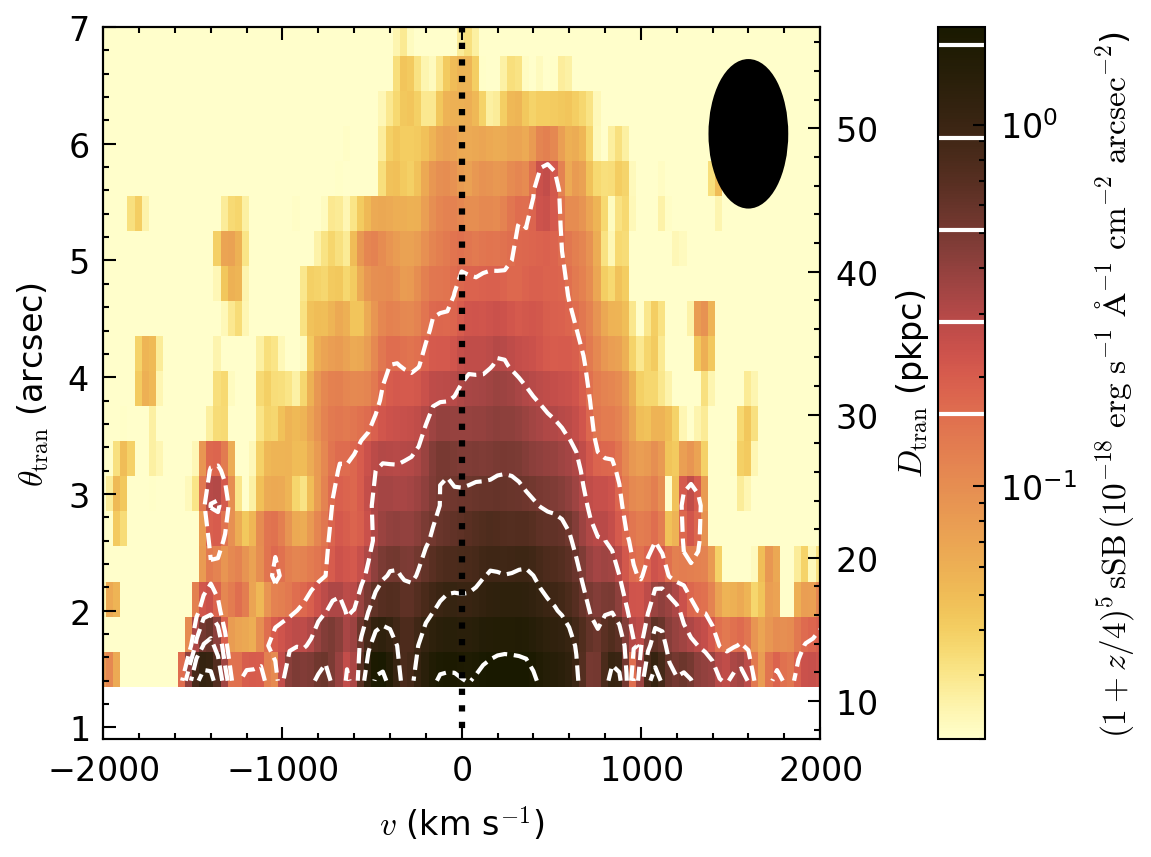

In [208]:
#import common_tools
#importlib.reload(common_tools)
importlib.reload(common_tools_yd)
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

fig, ax = plt.subplots(figsize=(4,3),dpi=300)

common_tools_yd.plot_cp2d(result[0]*100/4**5,fig,ax,log=True,PSFSub=True,HL=True,cosmo=Planck18,stackgrid=(xnew,ynew))
fig.tight_layout()

fig.savefig("/disk/bifrost/yuanze/KBSS/stack_analysis/stack_ps_HLQSOs.pdf")

### radial SB profile

In [614]:
S2011=np.genfromtxt(KBSSpath+"/Steidel2011.csv",delimiter=",")
B2016=np.genfromtxt(KBSSpath+"/Borisova2016.csv",delimiter=",")
F2019=np.genfromtxt(KBSSpath+"/FAB2019.csv",delimiter=",")


IndexError: list index out of range

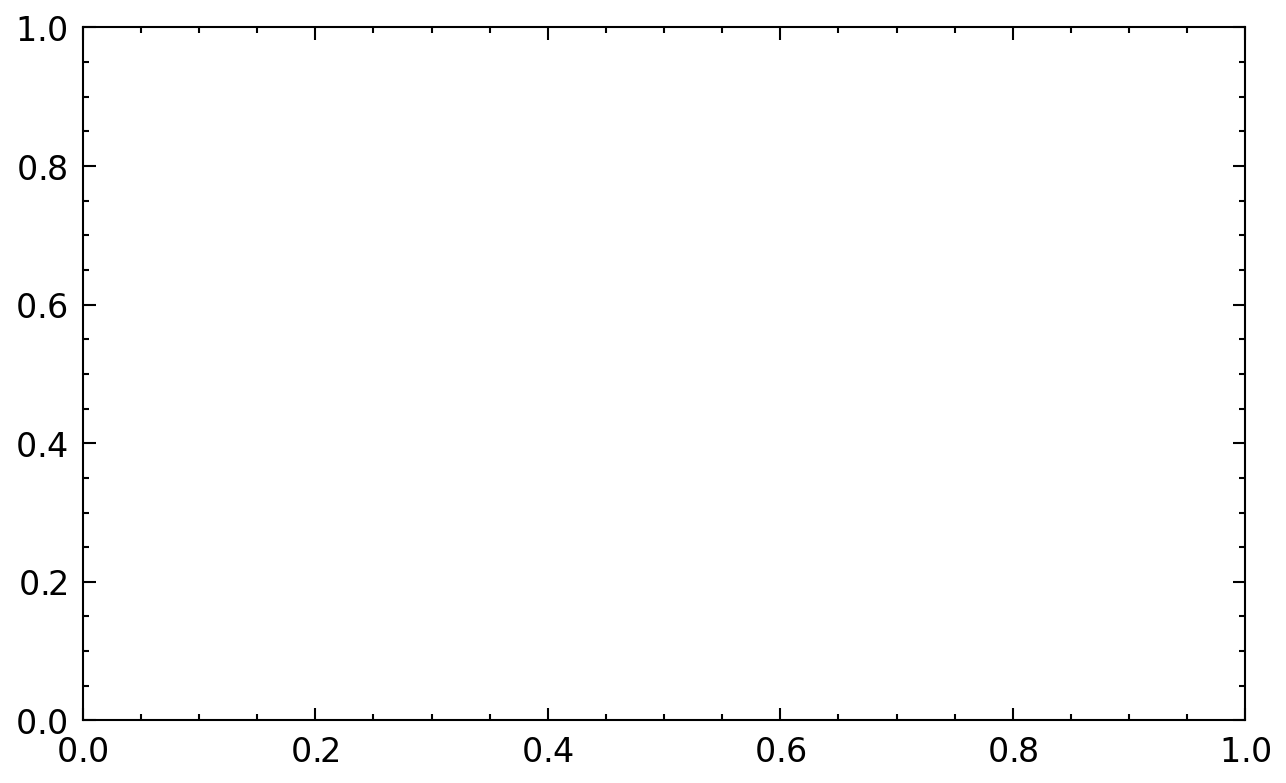

In [33]:
from astropy.modeling import Fittable1DModel, Parameter
import emcee
from scipy.optimize import curve_fit
from scipy import signal
from importlib import reload
reload(common_tools_yd)
from common_tools_yd import spatial_profile_2exp,spatial_profile_1exp
class OffsetExponential1D(Fittable1DModel):
    amplitude = Parameter()
    tau = Parameter()
    offset = Parameter()
    x_offset = Parameter()

    @staticmethod
    def evaluate(x, amplitude, tau, offset, x_offset):
        return amplitude * np.exp(-(x - x_offset) / tau) + offset

    @staticmethod
    def fit_deriv(x, amplitude, tau, offset, x_offset):
        exp_term = np.exp(-(x - x_offset) / tau)
        d_amplitude = exp_term
        d_tau = amplitude * (x - x_offset) * exp_term / tau**2
        d_offset = np.ones_like(x)
        d_x_offset = amplitude * exp_term / tau
        return [d_amplitude, d_tau, d_offset, d_x_offset]
'''
def log_likelihood(theta, x, y, yerr, model):
    model.parameters = theta
    y_model = model(x)
    sigma2 = yerr**2
    return -0.5 * np.sum((y - y_model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    amp_exp, tau_exp, offset_exp, x_offset_exp, amp_pow, x0_pow, alpha_pow, amp_exp2, tau_exp2 = theta
    if (0 < amp_exp < 100 and 0 < tau_exp < 50 and -10 < offset_exp < 10 and 0 < x_offset_exp < 50 and
        0 < amp_pow < 100 and 0 < x0_pow < 50 and -5 < alpha_pow < 5 and 0 < amp_exp2 < 100 and -50 < tau_exp2 < 0):
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr, model):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr, model)
'''
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})

fig, ax = plt.subplots(figsize=(5,3),dpi=300)

initial_guess2 = [1, 10, 1, 30]  # Initial guess for the parameters
initial_guess1 = [1, 10]
#fitfunc=spatial_profile_2exp
fitfunc=spatial_profile_1exp

kpc_per_arcsec=Planck18.kpc_proper_per_arcmin(2.65).value/60
cut1=5
cut2=60
scolor=["Blue","Red","All"]
colorl=["b","r","orange"]
ffunc=[spatial_profile_1exp,spatial_profile_1exp,spatial_profile_1exp]
sresult={}
for side in [0,2]:
    fitfunc=ffunc[side]
    #if side == 0:
     #   initial_guess=initial_guess2
    #else:
    initial_guess=initial_guess1
    x_data=ynew[cut1:cut2]*kpc_per_arcsec
    y_data=result[5][side][cut1:cut2]*100*((1+2.65)/4)**4
    y_err=result[6][side][cut1:cut2]*100*((1+2.65)/4)**4
    ax.errorbar(x_data,y_data,yerr=y_err
                ,fmt="o",
            label=scolor[side],
            color=colorl[side],
                mfc="none",
                ms=1.,
            capsize=0.0,
            ls="None",
                alpha=0.5,
            lw=1)
    #model=models.Moffat1D(amplitude=1e-17,x_0=0)
    #model.x_0.fixed=True
    # Fit the model
    fcut=60
    params, covariance = curve_fit(fitfunc, x_data[:fcut], y_data[:fcut], p0=initial_guess,sigma=y_err[:fcut], absolute_sigma=True)
    sresult[scolor[side]]=params
    #fitted_model = fitter(model,x_data[:fcut],y_data[:fcut],weights=1/y_err[:fcut]**2)
    x_fit = np.linspace(8,70, 100)
    #y_fit=fitted_model(x_fit)
    y_fit=fitfunc(x_fit, *params)
    
    #y_fit_comp1=fitfunc(x_fit,params[0],params[1],0,1)
    #y_fit_comp2=fitfunc(x_fit,0,1,params[2],params[3])
    ax.plot(x_fit,y_fit,color=colorl[side])
    #if side==0:
        #ax.plot(x_fit,y_fit_comp1,ls="--",color=colorl[side],lw=0.5)
        #ax.plot(x_fit,y_fit_comp2,ls="--",color=colorl[side],lw=0.5)

ax.plot(B2016[:,0],B2016[:,1]*1e18,color="m",label="Borisova+2016")
ax.plot(S2011[:,0],S2011[:,1]*1e18,color="g",label="Steidel+2011")
ax.plot(F2019[:,0],F2019[:,1]*1e18*((1+3.15)/4)**4,color="C6",label="QSOMUSEUM+2019")

#ax.plot(x_fit,fitted_model[1](x_fit),"r")
#ax.axvline(kpc_per_arcsec*0.3*15,ls="--",lw=0.5)
#ax.set_title("{}-{}".format(field,sourcename))
ax.set_xlim([8,70])
ax.set_ylim([0.1,100])
ax.set_yscale("log")
#ax.set_xscale("log")
ax.legend()
ax.set_xlabel("Transverse distance (pkpc)")
#ax.set_xlabel("Transverse distance (arcsec)")

ax.set_ylabel(r"$(1+z/4)^{4}$ SB $\rm (10^{-18} erg~s^{-1}~cm^{-2}~arcsec^{-2})$")

#fig.savefig(KBSSpath+"/QSOs_r{}_masked_pub2/SB_profile.pdf".format(radius))
# try rmax at 6 arcsec?

In [56]:
print(sresult)
print(5.24/kpc_per_arcsec)

{'Blue': array([12.03997615, 16.16113575, 53.0808128 ,  5.24706642]), 'All': array([  95.03836717,   12.60618596, 1031.80376982,    2.88465515])}
0.6425949636301856


In [910]:
sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 5000/5000 [00:29<00:00, 167.03it/s]


State([[60.45029813 19.83016194 -7.05239713 19.48405549 42.5641912   8.70701191
  -4.26984979 83.16412684 -2.25946659]
 [92.51855785 15.83876409 -3.67083219 12.52478654 45.47528703 45.87626479
  -1.06603639 18.71659208 -6.40995663]
 [58.25111324 21.86775873 -9.67150377 20.25781706 34.45934619  7.40916815
  -4.52486402 66.73243581 -2.149657  ]
 [97.17328615 23.03587861 -9.45581059  7.21429206 54.56201669  6.87776553
  -3.4353139  23.06421259 -2.63287018]
 [75.19075015 22.91902158 -8.42737894 11.21536838 97.73090488 44.23614162
  -1.40047489 68.9905179  -4.53146485]
 [70.37153368 19.64127955 -7.89260772 17.82673447 95.97178926  6.52180229
  -3.86462788 37.51411652 -1.96643117]
 [80.45904072 22.6532786  -9.8665877  13.10162771 63.69372752  5.81970649
  -4.32932389 21.22435831 -2.07898295]
 [43.34147551 14.48764062 -3.90844288 26.67144134 20.89692004 43.05206441
  -3.32585589 40.37597026 -0.611344  ]
 [45.48009868 22.13225473 -8.08182533 23.76457897 49.47895479 13.70602829
  -2.0627833  73

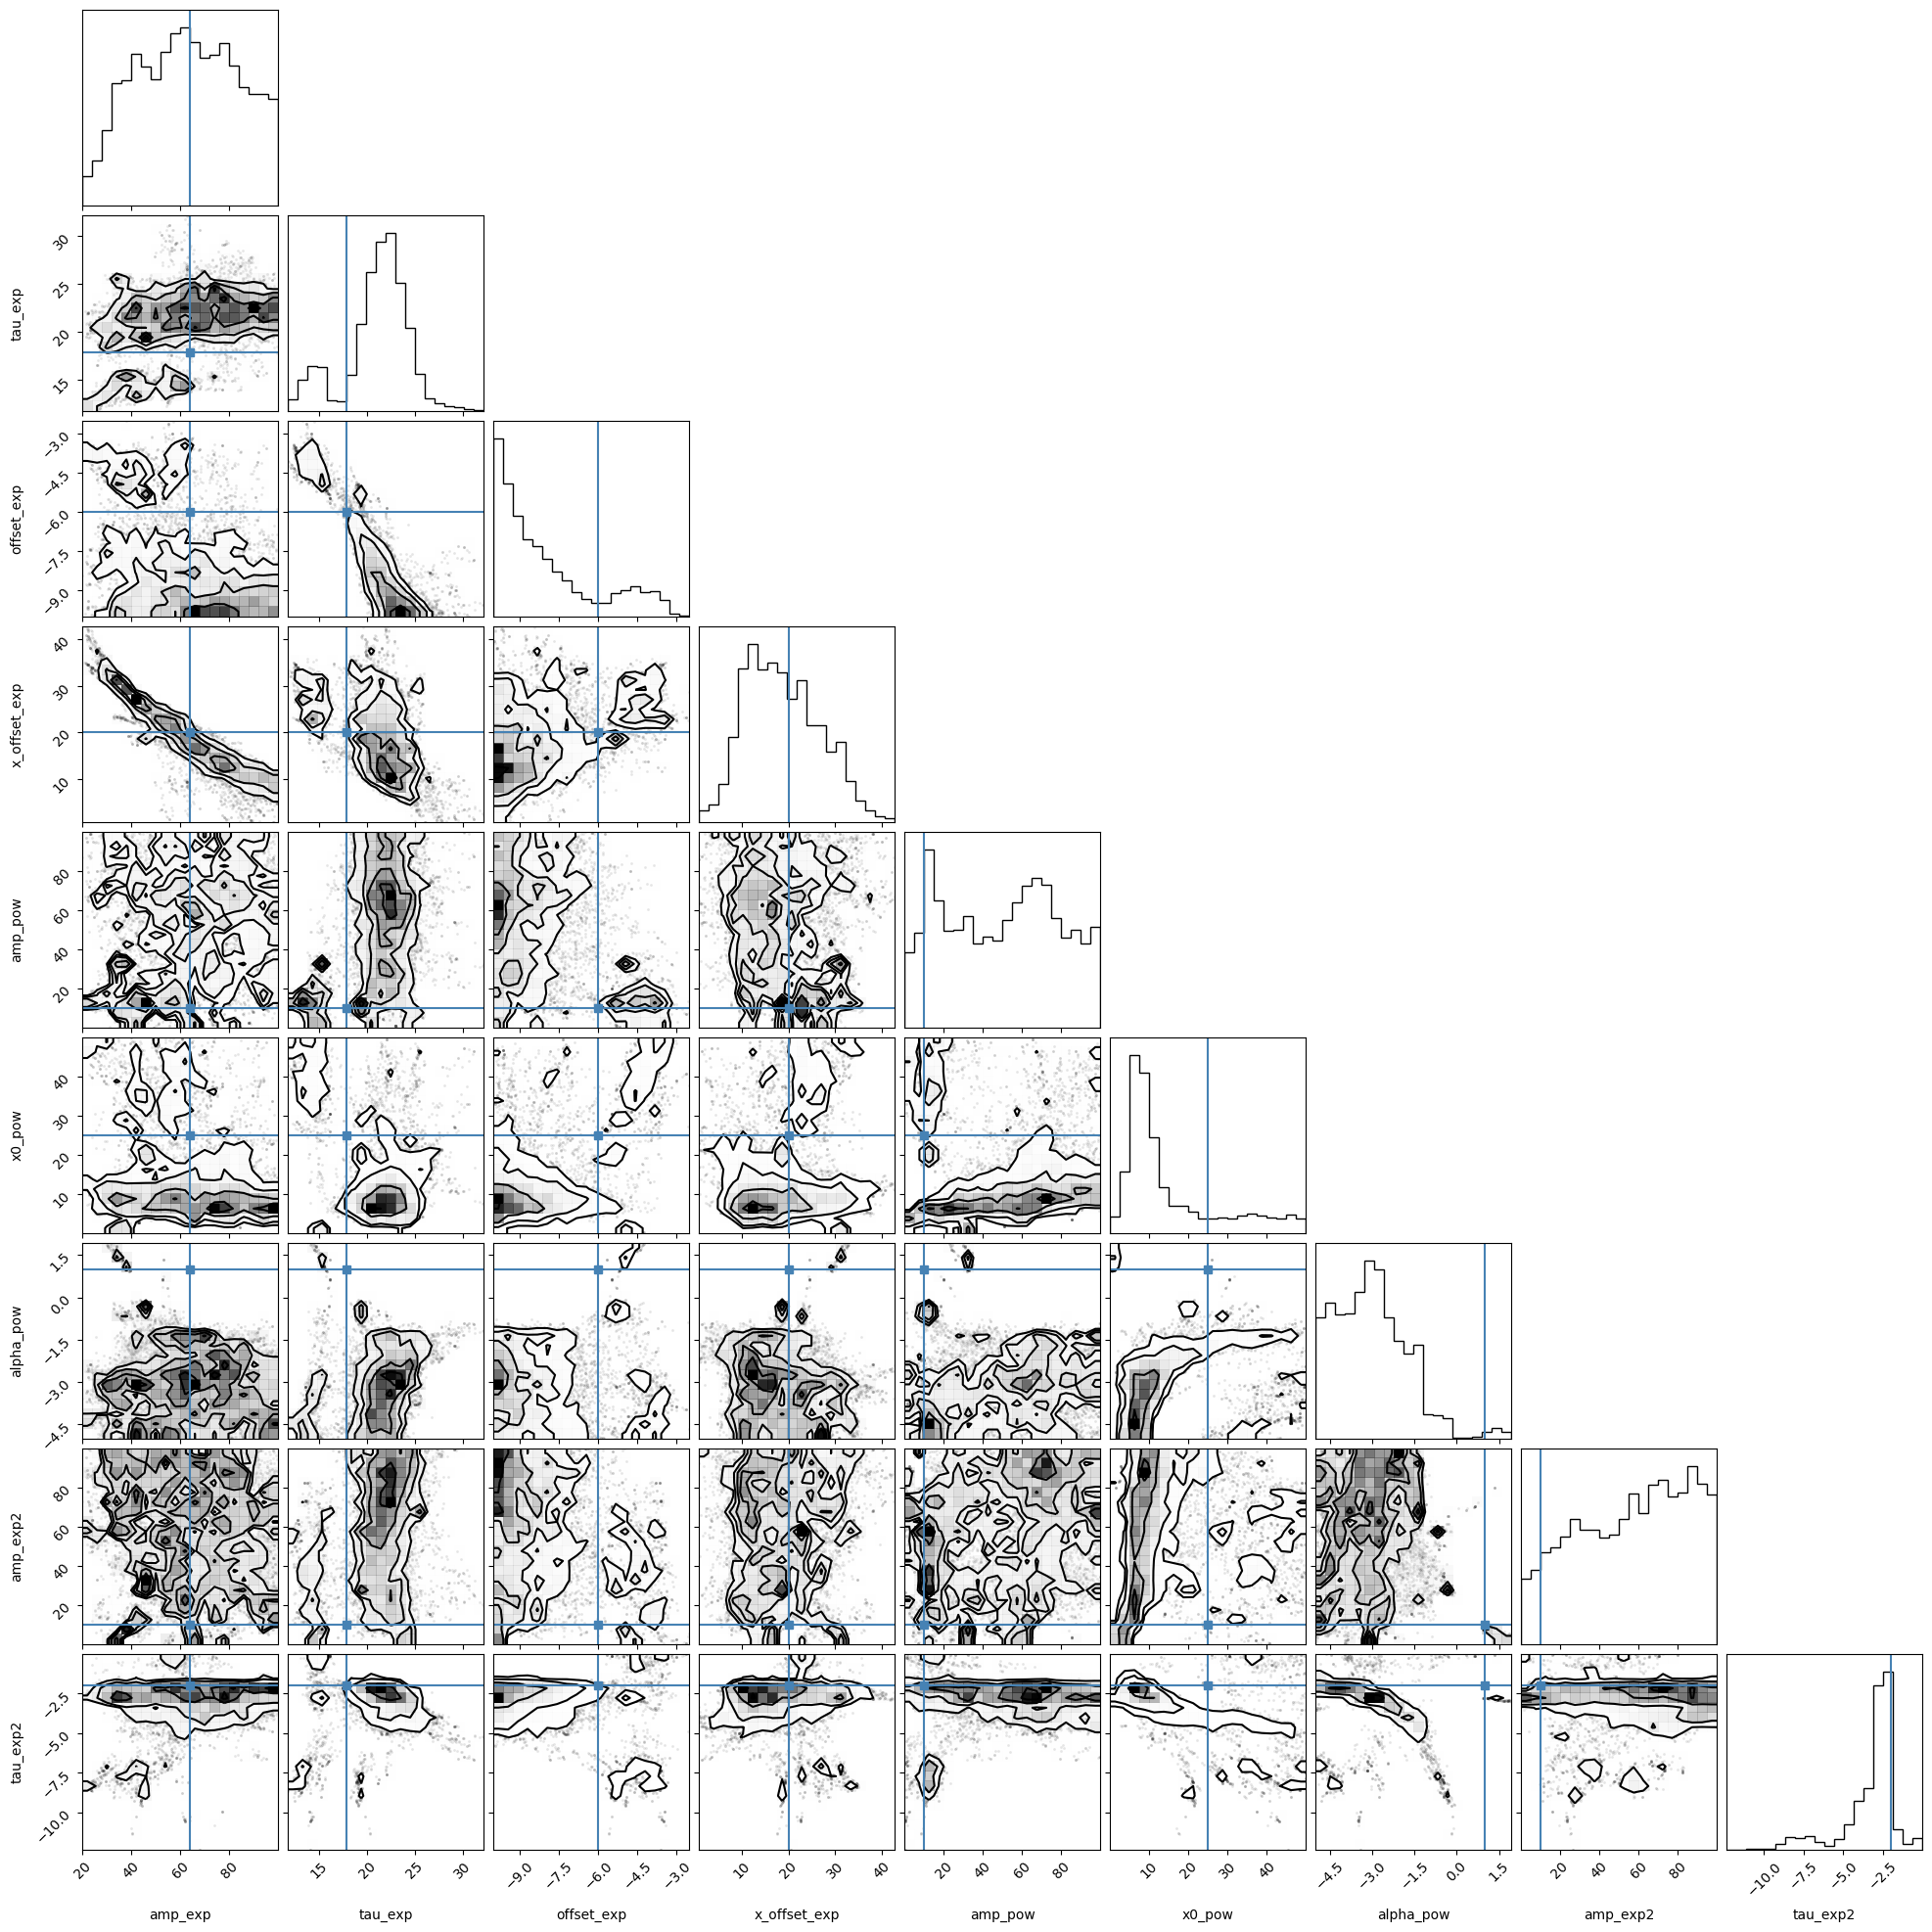

Parameter 1: 62.637 +22.799 -22.492
Parameter 2: 21.553 +2.289 -3.016
Parameter 3: -8.645 +3.144 -1.054
Parameter 4: 17.887 +9.562 -7.119
Parameter 5: 52.905 +28.066 -37.780
Parameter 6: 9.764 +20.350 -3.948
Parameter 7: -3.083 +1.370 -1.267
Parameter 8: 59.437 +28.229 -35.945
Parameter 9: -2.745 +0.684 -1.572


In [911]:
import corner

# Discard burn-in samples and flatten the chain
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

# Plot the corner plot
fig = corner.corner(flat_samples, labels=["amp_exp", "tau_exp", "offset_exp", "x_offset_exp",
                                          "amp_pow", "x0_pow", "alpha_pow", "amp_exp2", "tau_exp2"],
                    truths=initial)
plt.show()

# Calculate the statistics for the parameters
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"Parameter {i+1}: {mcmc[1]:.3f} +{q[1]:.3f} -{q[0]:.3f}")

In [860]:
fig, ax = plt.subplots(figsize=(5,3),dpi=300)

kpc_per_arcsec=Planck18.kpc_proper_per_arcmin(2.65).value/60
cut1=0
cut2=32
side=2
x_data=kpc_per_arcsec*ynew[cut1:cut2]
y_data=result[3][side][cut1:cut2]
y_err=result[4][side][cut1:cut2]
ax.errorbar(x_data,y_data,yerr=result[6][side][cut1:]
            ,fmt="o",
        #label="(Obs-Mod)/Obs",
        color="b",
            mfc="none",
            ms=1.,
        capsize=0.0,
        ls="None",
        lw=1)
#ax.plot(rbin[:-1]*kpc_per_arcsec+rx/2,np.array(annulus_value[sourcename][1])*2,color="k")

#ax.fill_between(rbin[:-1]*kpc_per_arcsec+rx/2,0,np.array(annulus_value[sourcename][1])*2,color="k",alpha=0.3)
model= OffsetExponential1D(amplitude=64, tau=17.8, offset=-6, x_offset=20)\
+models.PowerLaw1D(amplitude=10,x_0=25.,alpha=1.)*models.Exponential1D(amplitude=10,tau=-2)

model.amplitude_1.fixed=True
'''
# Initial guess for parameters
initial = np.array([64, 17.8, -6, 20, 10, 25, 1, 10, -2])
ndim = len(initial)
nwalkers = 32

# Initialize walkers near the initial guess
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)
#for i in range(nwalkers):
#    print(f"Walker {i} initial position: {pos[i]}")
#    print(f"Walker {i} log_prior: {log_likelihood(pos[i],x_data,y_data,y_err,model)}")
# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x_data, y_data, y_err, model))

# Run the MCMC chain
nsteps = 5000
'''


fitter = fitting.LevMarLSQFitter()
# Fit the model
fitted_model = fitter(model,x_data,y_data,weights=1/y_err**2)
#print(fitted_model)

x_fit = np.linspace(3, 70, 100)
y_fit=fitted_model(x_fit)
ax.plot(x_fit,y_fit,"g")
ax.axvline(kpc_per_arcsec*0.3*15,ls="--")
#ax.set_title("{}-{}".format(field,sourcename))
ax.set_xlim([6,70])
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Transverse distance (pkpc)")
ax.set_ylabel(r"SB $\rm (10^{-16}~erg~s^{-1}~cm^{-2})$")

array([199.03212249, 199.03212249, 182.73487192, 185.34601486,
       172.33294834, 147.61251538, 142.5696815 , 159.89174322,
       163.98678241, 140.71866285, 107.2577014 ,  79.16157222,
        56.84775243,  40.22541174,  31.35962218,  26.48018262,
        23.39153986,  21.42185379,  19.31162014,  17.08477118,
        15.20533833,  13.81433039,  12.72602658,  11.75040206,
        10.8082495 ,   9.93090003,   9.15381401,   8.4892956 ,
         7.92390362,   7.43299572,   6.99998459,   6.62000877,
         6.2822698 ,   5.96666319,   5.65198526,   5.32333457,
         4.98536371,   4.65845374,   4.35497175,   4.07990558,
         3.84043043,   3.64531884,   3.49796875,   3.39620121,
         3.33985151,   3.33554156,   3.38918568,   3.49647327,
         3.62535175,   3.71636767,   3.70688001,   3.59570175,
         3.44386827,   3.3107994 ,   3.21402577,   3.13206468,
         3.04081816,   2.92904208,   2.79752388,   2.64406344,
         2.47333413,   2.2969717 ,   2.1219061 ,   1.95

### Line profile

In [230]:
#16 params: v0, sigv, alpha, height, v0, sigv, alpha, height, p0, vp0, fwhm0, p1, vp1, fwhm1, trough, vt
vgrid = np.arange(-5500, 5501, 1)
#vgrid=xnew

In [68]:
p00, p01, p02, p03, p10, p11, p12, p13, p0, vp0, fwhm0, p1, vp1, fwhm1, trough, vt=result[3][18,:]
mod = common_tools_yd.skew_gauss(vgrid, p00, p01, p02, p03)

  0%|          | 0/8 [00:00<?, ?it/s]

192.23417504426382 525.1117813424265 44.94714455893047 4.168333425476047


 12%|█▎        | 1/8 [00:04<00:33,  4.73s/it]

154.0268826385922 546.0458946603898 22.58261365760434 6.387088092899217


 25%|██▌       | 2/8 [00:09<00:28,  4.74s/it]

118.10759554543415 518.3969472265366 14.450345498327158 1.9354231834471545


 38%|███▊      | 3/8 [00:14<00:23,  4.72s/it]

153.9678140275456 483.0010511557055 7.732804221155453 1.3082709958839982


 50%|█████     | 4/8 [00:18<00:18,  4.65s/it]

109.23245380435007 473.20314638433325 4.1728661689062925 1.9022426915060697


 62%|██████▎   | 5/8 [00:23<00:13,  4.66s/it]

95.31184745443647 490.74307087584225 1.9737443198133846 1.1898814762304162


 75%|███████▌  | 6/8 [00:28<00:09,  4.65s/it]

-6.9216499230934865 379.58463936552374 0.7644663763287587 0.40162128129365293


 88%|████████▊ | 7/8 [00:32<00:04,  4.67s/it]

-238.67406939371617 2.3700958969578307 230.47690437184653 3.9203390330440095e-73


100%|██████████| 8/8 [00:37<00:00,  4.67s/it]


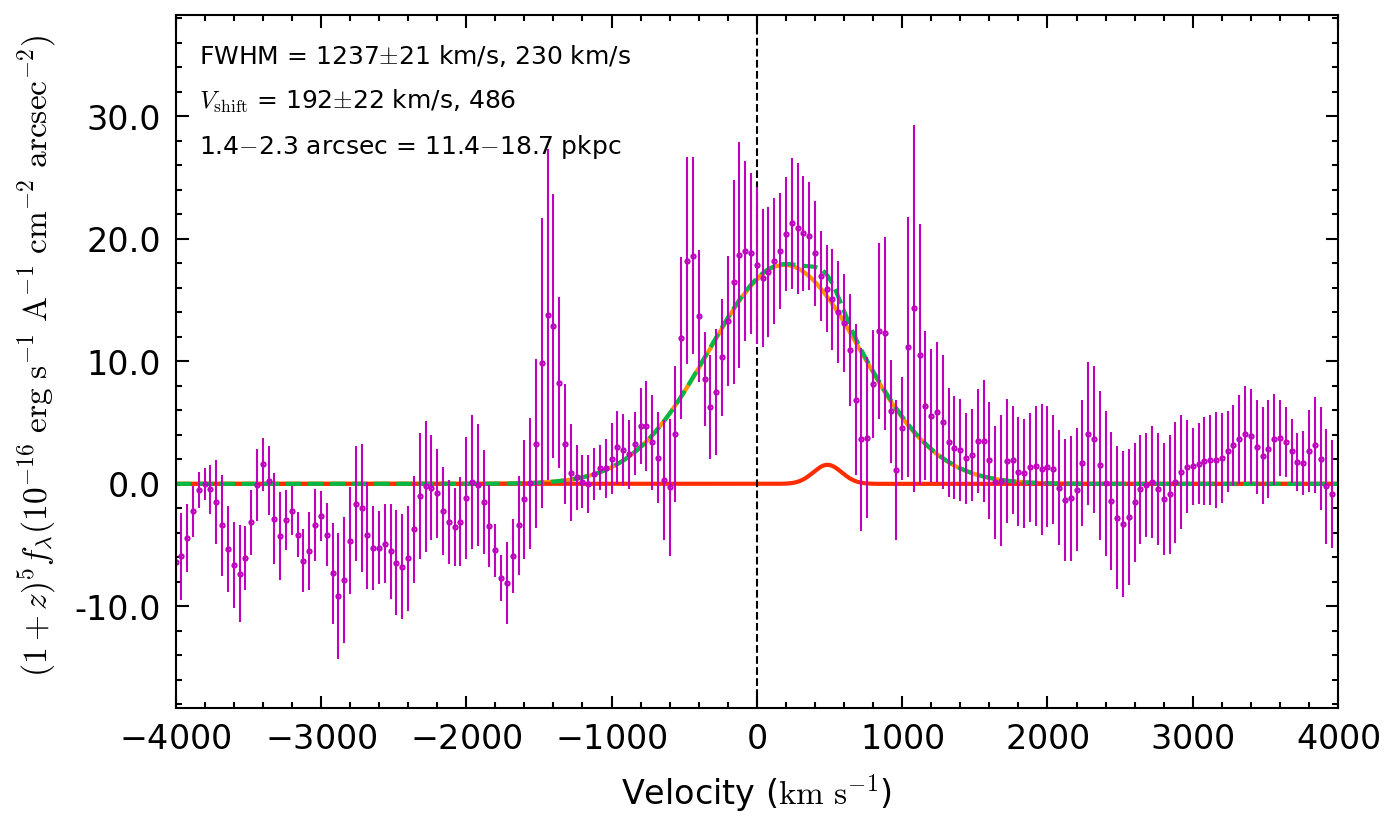

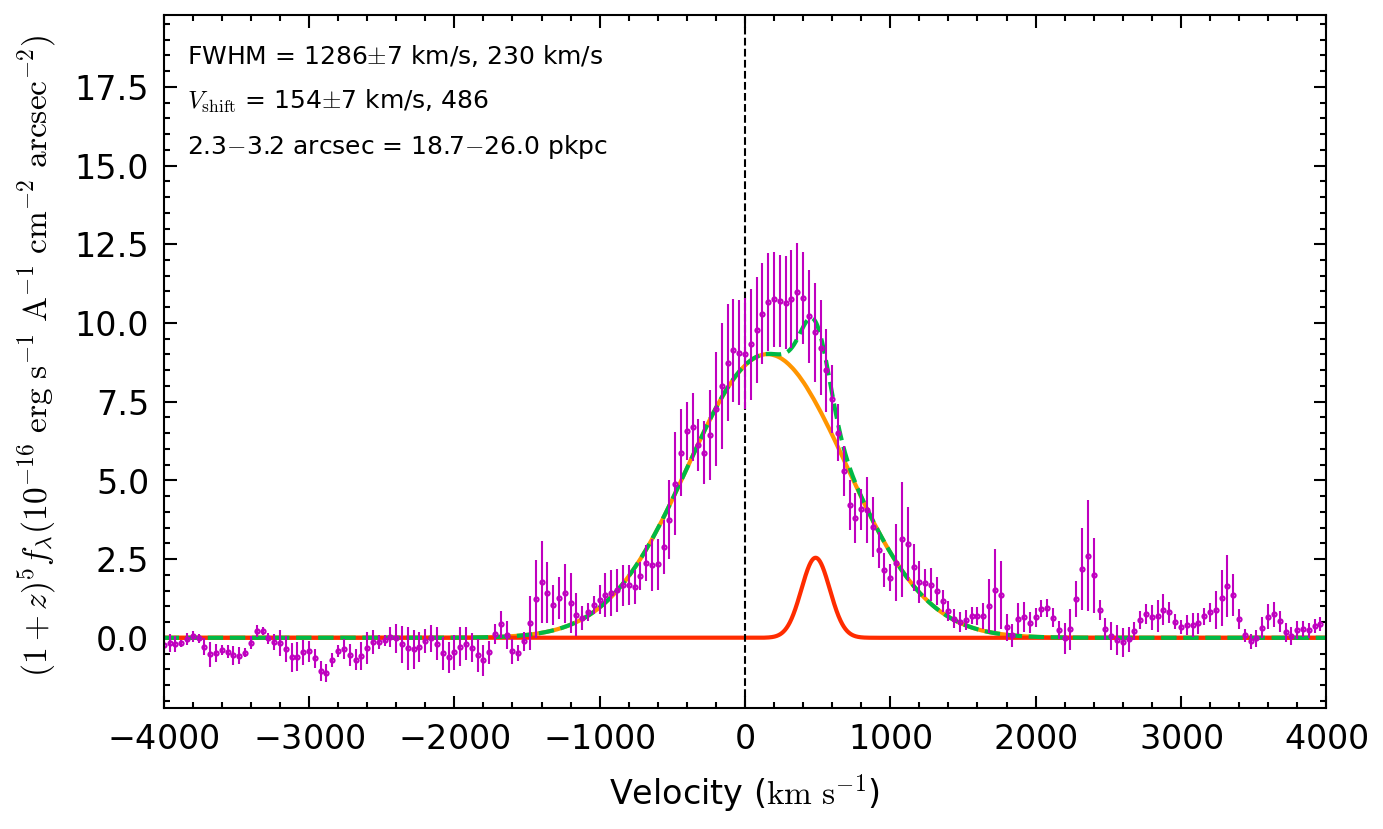

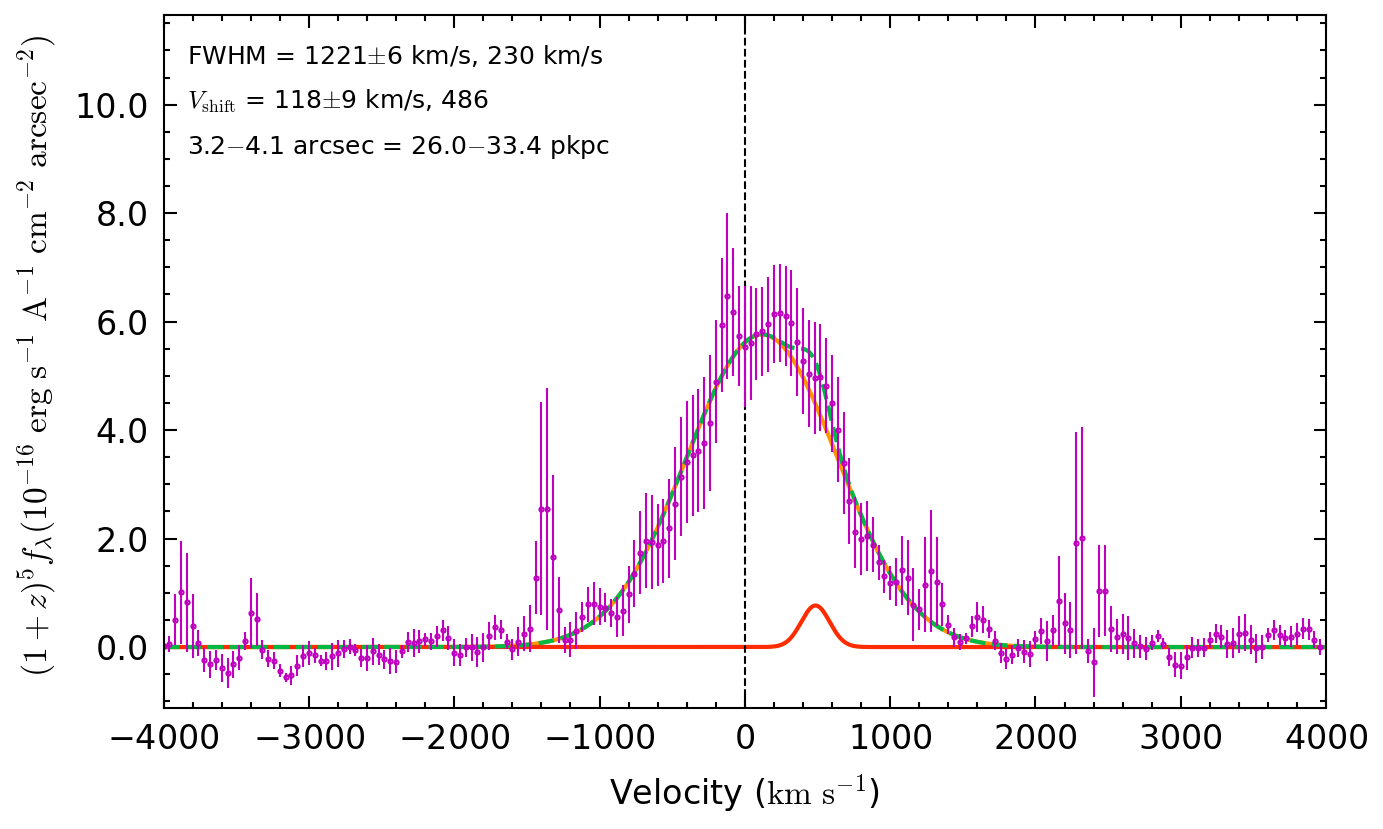

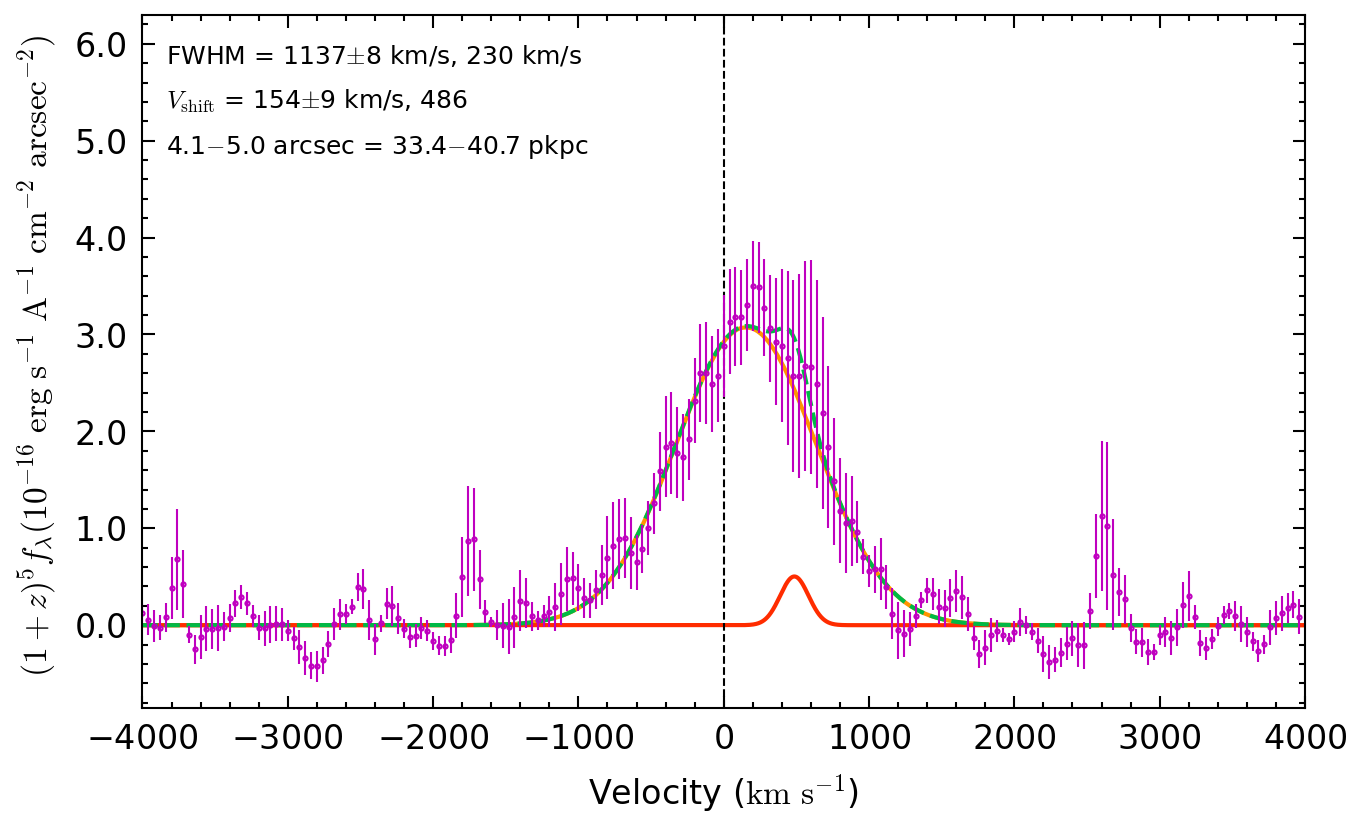

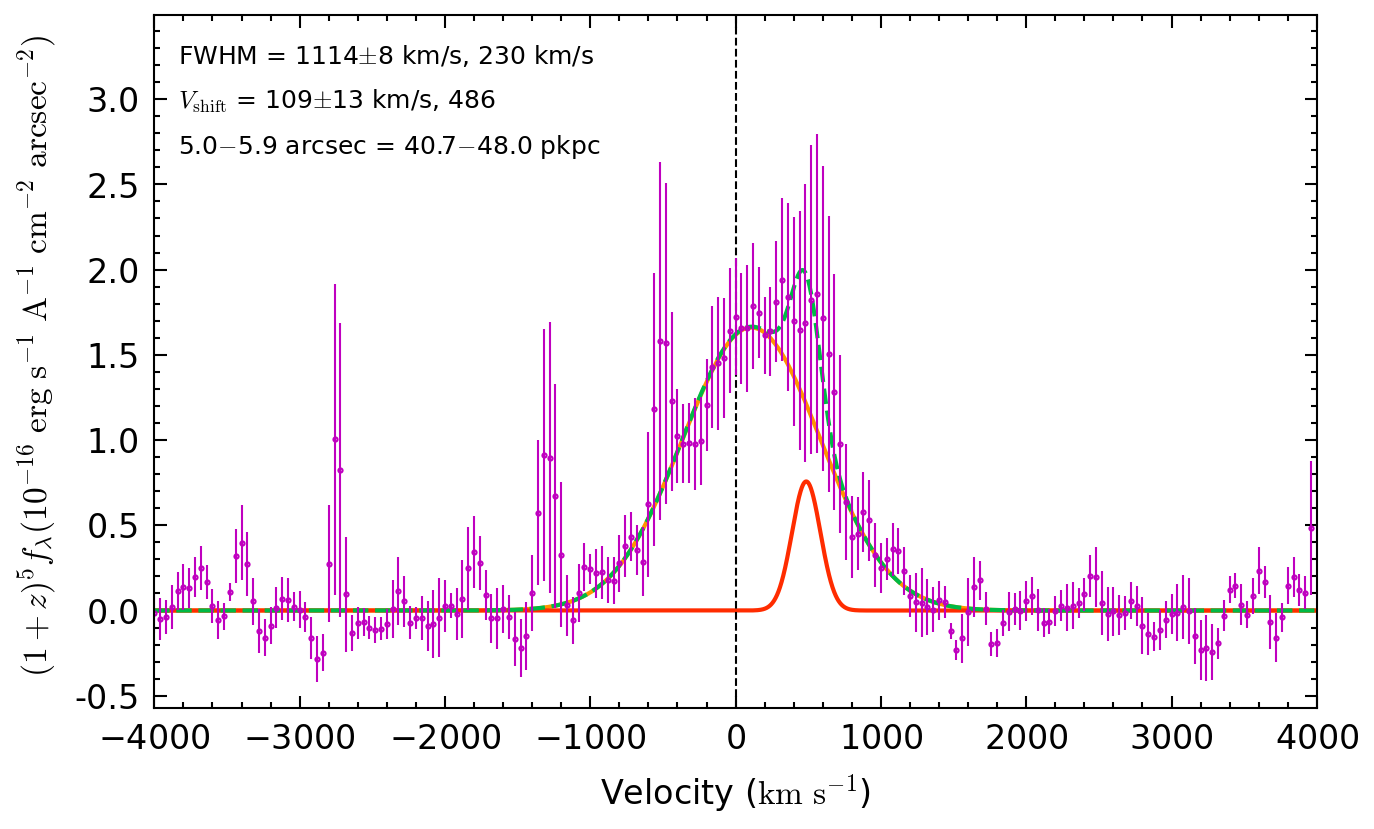

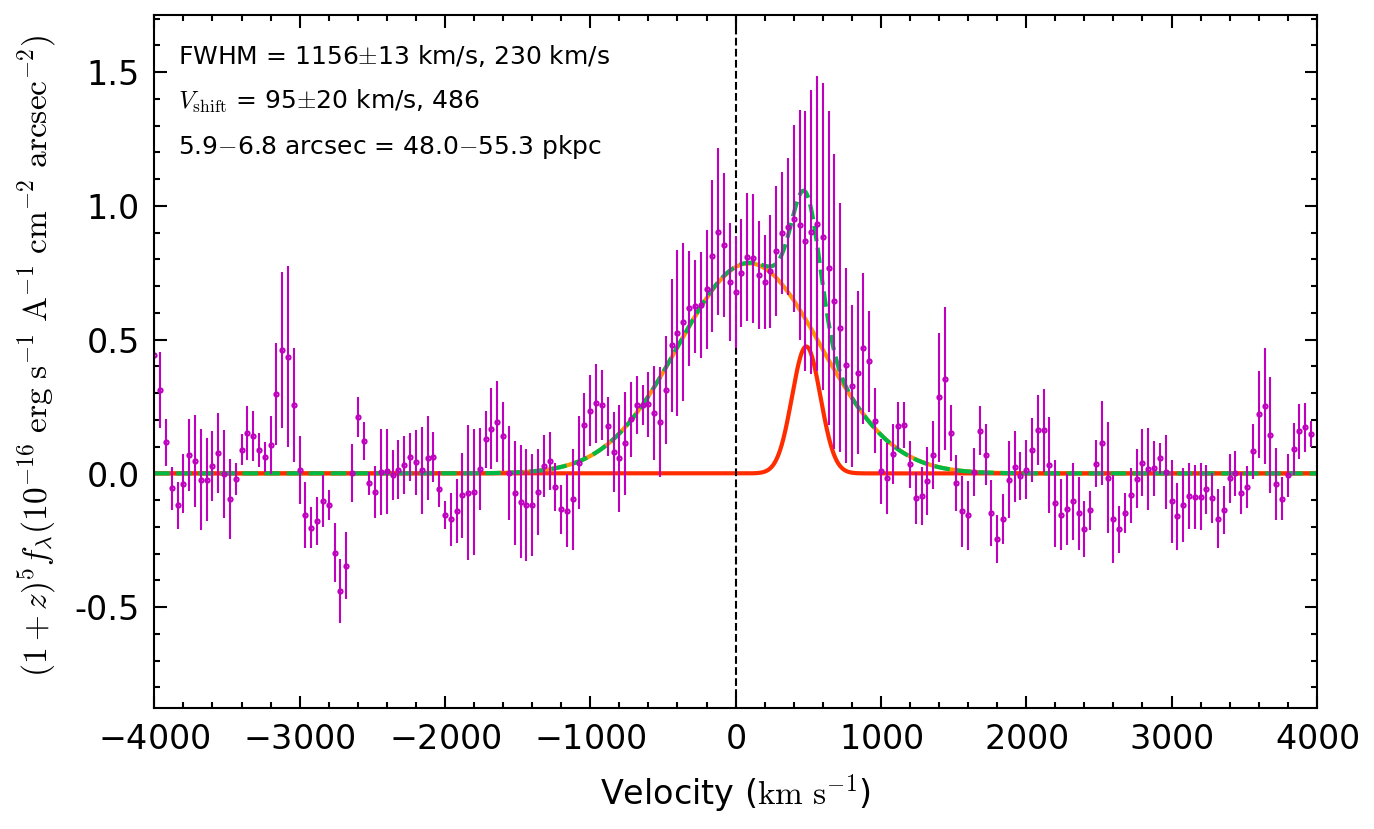

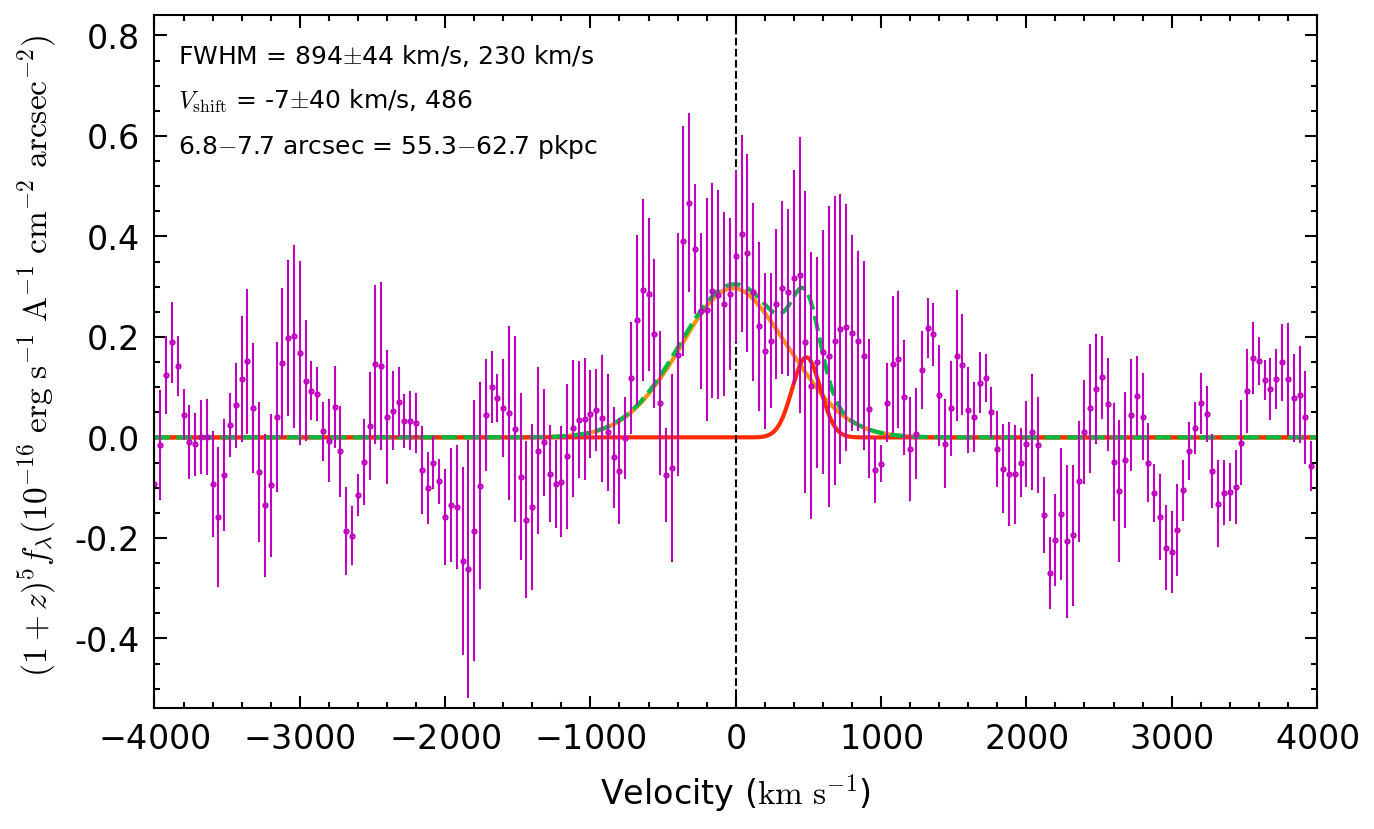

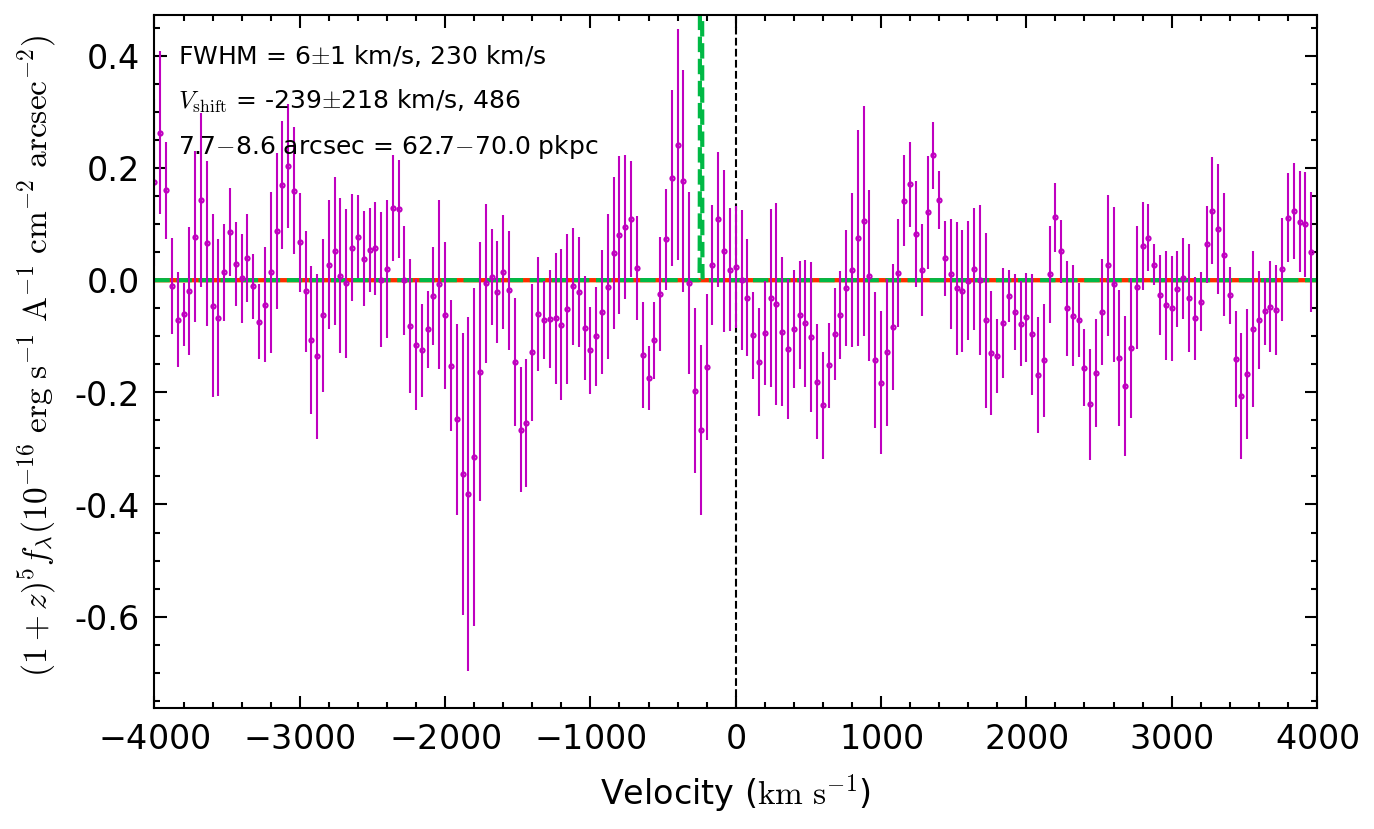

In [44]:
#for xind in range(31):
importlib.reload(common_tools_yd)
from tqdm import tqdm
import matplotlib.ticker as mticker
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
vgrid = np.arange(-5500, 5501, 1)
wgrid = 1215.67*(vgrid/3e5+1)#*(1+2.65)
efactor=1
plotmodel=True
plotQSO=False
normalize=False
savemod=False
saveresult=False
savefig=False
savetopath=KBSSpath+f"/QSOs_r6_masked_pub4"
fixFWHM=True
dgauss=False
dsgauss=False
allfixed=True
plotbinlist=False
SBblue=[]
SBred=[]
noise=[]
cind=1
if plotQSO:
    cmean,cmedian,_   =sigma_clipped_stats(result_QSO[0][cind,:],maxiters=None)
    cmax=np.max(result_QSO[0][cind,:]-cmedian)
result_path=KBSSpath+"/QSOs_r6_masked_pub4_zlyaneb"
read_result=False
if read_result:
    KBvgrid=np.loadtxt(result_path+f"/Kinematics_HLQSOstack_Lya_{lowz_arcsec:.1f}_mod1.txt",usecols=0)
    if os.path.exists(result_path+f"/Kinematics_HLQSOstack_Lya_{lowz_arcsec:.1f}_mod1.txt"):
        KBymod1=np.loadtxt(result_path+f"/Kinematics_HLQSOstack_Lya_{lowz_arcsec:.1f}_mod1.txt",usecols=1)
        KBymod2=np.loadtxt(result_path+f"/Kinematics_HLQSOstack_Lya_{lowz_arcsec:.1f}_mod2.txt",usecols=1)
def plot1Dspec(result,xnew,ynew,xind,vgrid,variance=None,show_fitinfo=False,saveresult=False,fixFWHM=False,savefig=False,read_result=False,show_distance=True,xlim=[-4000,4000]\
               ,ylabel=r" $(1+z)^{5}f_{\lambda}\rm (10^{-16}~erg~s^{-1}~A^{-1}~cm^{-2}~arcsec^{-2})$"\
               ,xlabel=r"Velocity ($\rm km~s^{-1}$)"\
               ,yup=None,ax=None,efactor=100,savetopath=".",plotmodel=True,plotQSO=False,normalize=False,savemod=False,dgauss=False,dsgauss=False,allfixed=False):
    if normalize:
        wc=(xnew/3e5*1215.67+1215.67)*(1+2.65) 
        efactor=1/np.trapz(result[0][xind,:],x=wc)
    if ax is None:
        fig, ax = plt.subplots(figsize=(5,3),dpi=300)
    else:
        fig=plt.gcf()
    if plotmodel:
        if fixFWHM:
            flat_chain=result[4][xind]
            if dgauss:
                #p00,p01,p03,p10,p11,p13 = np.percentile(flat_chain, 50.0,axis=0)
                p_lo = np.percentile(flat_chain, 31.7310507863,axis=0)
                p_hi = np.percentile(flat_chain, 68.2689492137,axis=0)
                p00err,p01err,p03err,p10err,p11err,p13err = (p_hi-p_lo)/2
                p00,p01,p03,p10,p11,p13 = (p_hi+p_lo)/2
                mod1s = np.array([common_tools_yd.sym_gauss(vgrid,theta[0],theta[1],theta[2]) for theta in flat_chain])
                mod2s = np.array([common_tools_yd.sym_gauss(vgrid,theta[3],theta[4],theta[5]) for theta in flat_chain])
            elif dsgauss:
                p00,p01,p02,p03,p10,p11,p12,p13 = np.percentile(flat_chain, 50.0,axis=0)
                #p_lo = np.percentile(flat_chain, 31.7310507863,axis=0)
                #p_hi = np.percentile(flat_chain, 68.2689492137,axis=0)
                #p00err,p01err,p02err,p03err,p10err,p11err,p12err,p13err = (p_hi-p_lo)/2
                print("Calculating line properties...")
                properties = np.array([common_tools_yd.calc_vlya(*theta) for theta in flat_chain])#peak0, vpeak0, fwhm0, peak1, vpeak1, fwhm1, trough, vmin
                print("Calculating model components...")
                mod1s = np.array([common_tools_yd.skew_gauss(vgrid,theta[0],theta[1],theta[2],theta[3]) for theta in flat_chain])
                mod2s = np.array([common_tools_yd.skew_gauss(vgrid,theta[4],theta[5],theta[6],theta[7]) for theta in flat_chain])
                print("Make figures...")
            elif allfixed:
                #sigma0 = 1200/2.355
                p11 = 230/2.355
                #wc0 = -750
                p10 = 486
                p_lo = np.percentile(flat_chain, 31.7310507863,axis=0)
                p_hi = np.percentile(flat_chain, 68.2689492137,axis=0)
                p00err,p01err,p03err,p13err = (p_hi-p_lo)/2
                p00,p01,p03,p13 = (p_hi+p_lo)/2
                print(p00,p01,p03,p13)
                #p03,p10,p13 = np.percentile(flat_chain, 50.0,axis=0)
                mod1s = np.array([common_tools_yd.sym_gauss(vgrid,theta[0],theta[1],theta[2]) for theta in flat_chain])
                mod2s = np.array([common_tools_yd.sym_gauss(vgrid,p10,p11,theta[3]) for theta in flat_chain])
            else:
                sigma0 = 1200/2.355
                sigma1 = 800/2.355
                #p_lo = np.percentile(flat_chain, 31.7310507863,axis=0)
                #p_hi = np.percentile(flat_chain, 68.2689492137,axis=0)
                p00,p03,p10,p13 = np.percentile(flat_chain, 50.0,axis=0)
                mod1s = np.array([common_tools_yd.sym_gauss(vgrid,theta[0],sigma0,theta[1]) for theta in flat_chain])
                mod2s = np.array([common_tools_yd.sym_gauss(vgrid,theta[2],sigma1,theta[3]) for theta in flat_chain])
        else:
            p00, p01, p02, p03, p10, p11, p12, p13, p0, vp0, fwhm0, p1, vp1, fwhm1, trough, vt=result[3][xind,:]
            p00err, p01err, p02err, p03err, p10err, p11err, p12err, p13err, p0err, vp0err, fwhm0err, p1err, vp1err, fwhm1err, trougherr, vterr=result[4][xind,:]
            if (p13<=0 and p03>0):
                mod = common_tools_yd.skew_gauss(vgrid, p00, p01, p02, p03)
                string1=f"FWHM = {fwhm0:.0f}$\pm${fwhm0err:.0f} km/s"
                string2="$V_\mathrm{shift}$"+f" = {vp0:.0f}$\pm${vp0err:.0f} km/s"
            elif (p13>0 and p03<=0):
                mod = common_tools_yd.skew_gauss(vgrid, p10, p11, p12, p13)
                string1=f"FWHM = {fwhm1:.0f}$\pm${fwhm1err:.0f} km/s"
                string2="$V_\mathrm{shift}$"+f" = {vp1:.0f}$\pm${vp1err:.0f} km/s"
            elif (p13<0 and p03<0):
                print(p00, p01, p02, p03, p10, p11, p12, p13)
                mod = common_tools_yd.lya_model_2(vgrid, p00, p01, p02, p03, p10, p11, p12, p13)
                string1=""
                string2=""

            #string=f"FWHM = {fwhm1:.1f}$\pm${fwhm1err:.1f}; Velocity = {vp1:.1f}$\pm${vp1err:.1f} km/s"#; skewness = {p02:.1f}$\pm${p02err:.1f}"
        if fixFWHM:
            if dgauss:
                mod = common_tools_yd.lya_model_4(vgrid, p00,p01, p03, p10, p11, p13)
            elif dsgauss:
                mod = common_tools_yd.lya_model_2(vgrid, p00,p01, p02, p03, p10, p11, p12, p13)
            elif allfixed:
                mod = common_tools_yd.lya_model_2_2(vgrid, p00,p01, p03,p13)
            else:
                mod = common_tools_yd.lya_model_3(vgrid, p00, p03, p10, p13)
            #sigma0 = 800/2.355
            #sigma1 = 1200/2.355
            #wsigma0 = sigma0/3e5*1215.67
            #wsigma1 = sigma1/3e5*1215.67
            mod1 = np.percentile(mod1s, 50.0,axis=0)
            mod2 = np.percentile(mod2s, 50.0,axis=0)
            #mod1 = common_tools_yd.sym_gauss(vgrid, p00, sigma0, p03)
            #mod1_err = common_tools_yd.sym_gauss(vgrid, p00, sigma0, p03+p03err)-common_tools_yd.sym_gauss(vgrid, p00, sigma0, p03-p03err)
            #mod2 = common_tools_yd.sym_gauss(vgrid, p10, sigma1, p13)
            #mod2_err = common_tools_yd.sym_gauss(vgrid, p10, sigma1, p13+p13err)-common_tools_yd.sym_gauss(vgrid, p10, sigma1, p13-p13err)
            if not allfixed:
                w1=np.trapz(mod1*wgrid,wgrid)/np.trapz(mod1,wgrid)
                w2=np.trapz(mod2*wgrid,wgrid)/np.trapz(mod2,wgrid)
                if w1<w2:
                    print(w1,"<",w2)
                    SBblue.append([np.trapz(tmpmod,wgrid) for tmpmod in mod1s])
                    #SBblue_err.append(np.trapz(mod1_err,wgrid))
                    SBred.append([np.trapz(tmpmod,wgrid) for tmpmod in mod2s])
                else:
                    print("Warning:",w1,">",w2)
                    SBblue.append([np.trapz(tmpmod,wgrid) for tmpmod in mod2s])
                    #SBblue_err.append(np.trapz(mod1_err,wgrid))
                    SBred.append([np.trapz(tmpmod,wgrid) for tmpmod in mod1s])
            else:
                SBblue.append([np.trapz(tmpmod,wgrid) for tmpmod in mod1s])
                #SBblue_err.append(np.trapz(mod1_err,wgrid))
                SBred.append([np.trapz(tmpmod,wgrid) for tmpmod in mod2s])
            #SBred_err.append(np.trapz(mod2_err,wgrid))
            if dgauss:
                string1=f"FWHM = {p01*2.355:.0f}$\pm${p01err*2.355:.0f}, {p11*2.355:.0f}$\pm${p11err*2.355:.0f} km/s"
                string2="$V_\mathrm{shift}$"+f" = {p00:.0f}$\pm${p00err:.0f}, {p10:.0f}$\pm${p10err:.0f} km/s"
            elif dsgauss:
                string1=f"FWHM = {np.mean(properties[:,2]):.0f}$\pm${np.std(properties[:,2]):.0f}, {np.mean(properties[:,5]):.0f}$\pm${np.std(properties[:,5]):.0f} km/s"
                string2="$V_\mathrm{shift}$"+f" = {np.mean(properties[:,1]):.0f}$\pm${np.std(properties[:,1]):.0f}, {np.mean(properties[:,4]):.0f}$\pm${np.std(properties[:,4]):.0f} km/s"
            else:
                string1=f"FWHM = {p01*2.355:.0f}$\pm${p01err:.0f} km/s, {p11*2.355:.0f} km/s"
                string2="$V_\mathrm{shift}$"+f" = {p00:.0f}$\pm${p00err:.0f} km/s, {p10:.0f}"
            ax.plot(vgrid,mod1*efactor,"C2",label="Component 1",lw=1.0)
            ax.plot(vgrid,mod2*efactor,"C3",label="Component 2",lw=1.0)

        elif p13>0 and p03>0:
            if  (p03>0.1*p13):
                mod = common_tools_yd.lya_model_2(vgrid, p00, p01, p02, p03, p10, p11, p12, p13)
                mod1 = common_tools_yd.skew_gauss(vgrid, p00, p01, p02, p03)
                mod2 = common_tools_yd.skew_gauss(vgrid, p10, p11, p12, p13)
                string1=f"FWHM = {fwhm0:.0f}$\pm${fwhm0err:.0f}, {fwhm1:.0f}$\pm${fwhm1err:.0f} km/s"
                string2="$V_\mathrm{shift}$"+f" = {vp0:.0f}$\pm${vp0err:.0f}, {vp1:.0f}$\pm${vp1err:.0f} km/s"

                ax.plot(vgrid,mod1*efactor,"C2",label="Component 1",lw=1.0)
                ax.plot(vgrid,mod2*efactor,"C3",label="Component 2",lw=1.0)
                if savemod:
                    np.savetxt(savetopath+f"/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}_mod1.txt",np.array([vgrid,mod1*efactor]).T)
                    np.savetxt(savetopath+f"/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}_mod2.txt",np.array([vgrid,mod2*efactor]).T) 
            else:
                mod = common_tools_yd.lya_model_2(vgrid, p00, p01, p02, p03, p10, p11, p12, p13)
                string1=f"FWHM = {fwhm1:.0f}$\pm${fwhm1err:.0f} km/s"
                string2="$V_\mathrm{shift}$"+f" = {vp1:.0f}$\pm${vp1err:.0f} km/s"
            
        if savemod:
            np.savetxt(savetopath+f"/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}_mod.txt",np.array([vgrid,mod*efactor]).T)
            np.savetxt(savetopath+f"/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}_mod1.txt",np.array([vgrid,mod1*efactor]).T)
            np.savetxt(savetopath+f"/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}_mod2.txt",np.array([vgrid,mod2*efactor]).T) 



            #string=f"FWHM = {fwhm0:.0f}$\pm${fwhm0err:.1f}, {fwhm1:.0f}$\pm${fwhm1err:.1f}; Velocity = {vp0:.1f}$\pm${vp0err:.1f}, {vp1:.1f}$\pm${vp1err:.1f};"+"\n"\
            #+f"skewness = {p02:.1f}$\pm${p02err:.1f}, {p12:.1f}$\pm${p12err:.1f}; Peak = {p0*efactor:.1f}$\pm${p0err*efactor:.1f}, {p1*efactor:.1f}$\pm${p1err*efactor:.1f}"
                        #+f"Amplitude = {p0*efactor:.2f}$\pm${p0err*efactor:.2f}, {p1*efactor:.2f}$\pm${p1err*efactor:.2f}"

            #if np.isfinite(trough):
            #    string+=f"\n trough at {vt:.1f}$\pm${vterr:.1f}"
        if show_fitinfo:
            
            ax.text(0.02,0.93,string1,transform=ax.transAxes,color="k",fontsize=6)
            ax.text(0.02,0.865,string2,transform=ax.transAxes,color="k",fontsize=6)
        ax.plot(vgrid,mod*efactor,"--C1",label="Full model")
        
    ax.axvline(x=0,ls="--",lw=0.5,color="k")
    ax.errorbar(xnew,result[0][xind,:]*efactor,yerr=result[2][xind,:]*efactor,fmt="o",mfc='none',ms=0.5,color="m",ecolor="m",lw=0.5)
    if variance is not None:
        ax.plot(xnew,np.sqrt(variance[0][xind,:])*efactor,ls="-",color="xkcd:violet",lw=1.0,label="Noise level")
        noise.append(np.max([sigma0,sigma1])*2.355/3e5*1215.67*np.mean(np.sqrt(variance[0][xind,:])*efactor))
    if saveresult:
        np.savetxt(savetopath+f"/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}_data.txt",np.array([xnew,result[0][xind,:]*efactor,result[2][xind,:]*efactor]).T)
    #ax.step(xnew,np.sqrt(result_var[0][xind,:])*efactor,lw=0.5,ls="--",color="red",label="Std. dev.")
    #submean,submedian,_ =sigma_clipped_stats(result[0][xind,:],maxiters=None)
    
    if plotQSO:
        ccfac=np.max(result[0][xind,:])/cmax*2.5
        #cind=0
        qsoyerr=result_QSO[2][cind,:]*efactor*ccfac
        ax.errorbar(xnew,(result_QSO[0][cind,:]-cmedian)*efactor*ccfac,fmt="--",mfc='none',ms=0.5,color="C4",ecolor="r",lw=1,alpha=1.0,label="Unsubtracted PSF central")
    
    #
    ax.set_xlabel(xlabel)
    if normalize:
        ax.set_ylabel(r"Normalized SB")
    else:
        ax.set_ylabel(ylabel)
    ax.set_xlim(xlim)
    if yup is None:
        yup=1.8*np.max(result[0][xind,:])
    ax.set_ylim([2*np.min(result[0][xind,:]*efactor),yup*efactor])
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    #yarray=np.linspace(0,,yup*efactor,10,)
    #ax.set_yticks(yarray)
    #ax.set_yticklabels(yarray)
    #ax.set_ylim([-0.1,10])
    #ax.text(0.05,0.75,f"Distance from QSO: {ynew[xind]*kpc_per_arcsec:.1f} pkpc = {ynew[xind]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)
    binwidth=np.mean(np.diff(ynew))
    if show_distance:
        ax.text(0.02,0.8,f"{ynew[xind]:.1f}$-${ynew[xind]+binwidth:.1f} arcsec = {ynew[xind]*kpc_per_arcsec:.1f}$-${(ynew[xind]+binwidth)*kpc_per_arcsec:.1f} pkpc",transform=ax.transAxes,color="k",fontsize=6)
        #ax.text(0.02,0.8,f"{ynew[xind]*kpc_per_arcsec:.1f}$-${(ynew[xind]+binwidth)*kpc_per_arcsec:.1f} pkpc",transform=ax.transAxes,color="k",fontsize=10)

    #ax.text(0.05,0.65,r"Masked in spectral region $\pm 3000\,\rm km/s$",transform=ax.transAxes,color="k",fontsize=6)
    if savefig:
        fig.savefig(savetopath+f"/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}.pdf")
    #np.savetxt(savetopath+f"/Kinematics_HLQSOstack_Lya_{ynew[xind]*kpc_per_arcsec:.0f}_data.txt",np.array([xnew,result[0][xind,:]*efactor,result[2][xind,:]*efactor]).T)
    #plt.savefig(savetopath+f"/Kinematics_HLQSOstack_L|ya_{ynew[xind]*kpc_per_arcsec:.0f}.pdf")
    return fig,ax
#csmean,csmedian,_=sigma_clipped_stats(result_QSO[0][cind,:]-cmedian,maxiters=None)
plotbinlist=False
if plotbinlist:
    fig,ax=plt.subplots(4,1,figsize=(3,8),dpi=300,sharex=True)
    binlist=[1,3,5,6]
    for aind,yind in enumerate(binlist):
        fig,_=plot1Dspec(result,xnew,ynew,yind,vgrid,show_fitinfo=True#,variance=result_var\
                      ,saveresult=saveresult,fixFWHM=fixFWHM,ax=ax[aind]\
                      ,efactor=efactor,savefig=savefig,savetopath=savetopath,savemod=savemod,plotmodel=plotmodel,plotQSO=plotQSO,normalize=normalize,dgauss=dgauss,dsgauss=dsgauss,allfixed=allfixed)
        if len(binlist)==1:
            ax.legend(loc="upper right",fontsize=6)
        elif aind!=1:#aind == 0 or aind == len(binlist)-1:
            ax[aind].set_ylabel("")
        else:
            ax[aind].legend(loc="right",fontsize=6)
    plt.subplots_adjust(hspace=0)
    fig.savefig(savetopath+f"/Kinematics_HLQSOstack_newfig.pdf")
else:
    for yind in tqdm(range(len(ynew))):#range(0, 40):enumerate(binlist):#
        fig,_=plot1Dspec(result,xnew,ynew,yind,vgrid,show_fitinfo=True#,variance=result_var\
                          ,saveresult=saveresult,fixFWHM=fixFWHM,ax=None#ax[aind]\
                          ,efactor=efactor,savefig=savefig,savetopath=savetopath,savemod=savemod,plotmodel=plotmodel,plotQSO=plotQSO,normalize=normalize,dgauss=dgauss,dsgauss=dsgauss,allfixed=allfixed)




    
    #plt.close()
 #   np.savetxt(KBSSpath+f"/QSOs_r6_masked_sim/Kinematics_HLQSOstack_Lya_{ynew_rh[xind]*kpc_per_arcsec:.0f}_data.txt",np.array([xnew,result[0][xind,:]*efactor,result[2][xind,:]*efactor]).T)
#    fig.savefig(KBSSpath+f"/QSOs_r6_masked_sim/Kinematics_HLQSOstack_Lya_{ynew_rh[xind]*kpc_per_arcsec:.0f}.pdf")




In [49]:
ynew

array([1.4, 2.3, 3.2, 4.1, 5. , 5.9, 6.8, 7.7])

In [23]:
result[4][0].shape

(2400, 6)

In [316]:
y_data_list[0]<2*noise[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [313]:
noise

[0.8410608423398319,
 0.581317448546002,
 0.46967781425909433,
 0.4120301423148085,
 0.38670261821431806,
 0.3729258127740042,
 0.3654538388206876,
 0.36058811436651594,
 0.35735822083657265,
 0.3551772747297031,
 0.353885338891915,
 0.35280621315946714,
 0.35256024068862357,
 0.3519298807551192,
 0.3508422282379061,
 0.350394736936,
 0.3505534367289566,
 0.3523246935801516,
 0.36008446604330724,
 0.37205762612219434,
 0.3798571998577743,
 0.38640875921610174,
 0.3974268610939677,
 0.4139584722267457]

In [469]:
if True:#fixFWHM:# saveresult and 
    y_data_list=[np.mean(SBblue,axis=1),np.mean(SBred,axis=1)]
    SBblue_perc=np.percentile(SBblue,[95,5],axis=1)
    SBred_perc=np.percentile(SBred,[95,5],axis=1)
    y_data_err_list=[(SBblue_perc[0]-SBblue_perc[1])/2,(SBred_perc[0]-SBred_perc[1])/2]
    np.savetxt(savetopath+f"/SB_blue.txt",np.array([ynew,y_data_list[0],y_data_err_list[0]]).T)
    np.savetxt(savetopath+f"/SB_red.txt",np.array([ynew,y_data_list[1],y_data_err_list[1]]).T)
    #noise=np.mean(np.sqrt(result_var[0]),axis=1)
    #np.savetxt(savetopath+f"/noise.txt",np.array([ynew,noise]).T)  

In [477]:
uplims.shape

(3, 24)

In [48]:
np.shape(SBblue)

(8, 2400)

### make r-profile figure through the fixed-FWHM fitting

ploting 0 with
(8,) (8,)
ploting 1 with
(8,) (8,)


/tmp/ipykernel_2974250/2963538707.py:179: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_data,y_data,yerr=y_err


Text(0, 0.5, '$\\rm (1+z/4)^{4}$ SB $\\rm (10^{-18} erg~s^{-1}~cm^{-2}~arcsec^{-2})$')

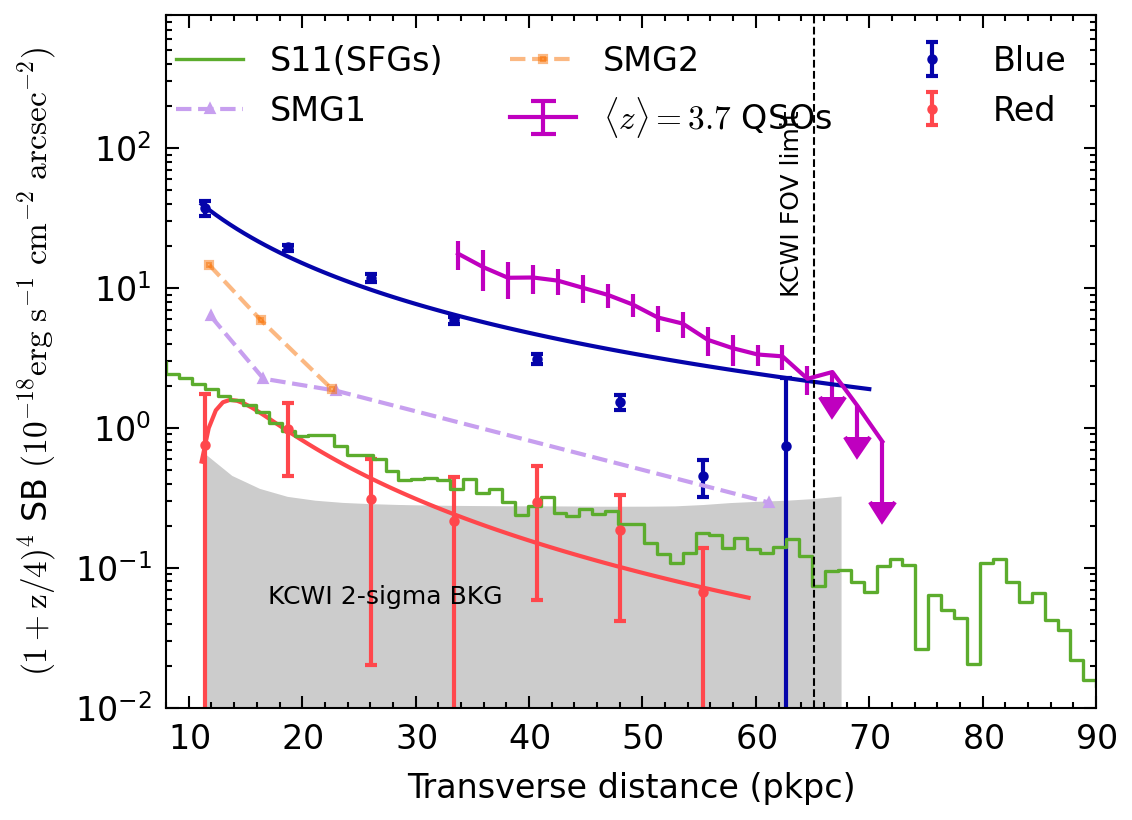

In [52]:
from astropy.modeling import Fittable1DModel, Parameter
import emcee
from astropy.modeling import models
from scipy.optimize import curve_fit
from scipy import signal
from importlib import reload
reload(common_tools_yd)
from common_tools_yd import spatial_profile_2exp,spatial_profile_1exp,spatial_profile_expMoffat,spatial_profile_Moffat,spatial_profile_1Pow,spatial_profile_2Pow2,spatial_profile_expPow2,spatial_profile_S11
class OffsetExponential1D(Fittable1DModel):
    amplitude = Parameter()
    tau = Parameter()
    offset = Parameter()
    x_offset = Parameter()

    @staticmethod
    def evaluate(x, amplitude, tau, offset, x_offset):
        return amplitude * np.exp(-(x - x_offset) / tau) + offset

    @staticmethod
    def fit_deriv(x, amplitude, tau, offset, x_offset):
        exp_term = np.exp(-(x - x_offset) / tau)
        d_amplitude = exp_term
        d_tau = amplitude * (x - x_offset) * exp_term / tau**2
        d_offset = np.ones_like(x)
        d_x_offset = amplitude * exp_term / tau
        return [d_amplitude, d_tau, d_offset, d_x_offset]

plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})



#S2011=np.genfromtxt(KBSSpath+"/Steidel2011.csv",delimiter=",")
S2011_all=np.genfromtxt(KBSSpath+"/SFG_S11/all_lya.avg.final.dat")
S2011_emitter=np.genfromtxt(KBSSpath+"/SFG_S11/lya_em.avg.final.skysub.dat")
S2011_blobs=np.genfromtxt(KBSSpath+"/SFG_S11/all_blobs_avg.dat")

B2016=np.genfromtxt(KBSSpath+"/Borisova2016.csv",delimiter=",")
F2019=np.genfromtxt(KBSSpath+"/FAB2019.csv",delimiter=",")


fig, ax = plt.subplots(figsize=(4,3),dpi=300)


SFGarcsec2kpc=Planck18.kpc_proper_per_arcmin(3.15).value/60
C2025w=np.arange(5,100,2)
MFWHM=1.805*SFGarcsec2kpc
gamma=MFWHM/2/np.sqrt(2**(1/2.24)-1)
Am=2.14; Aexp=0.218; rexp=3.68*SFGarcsec2kpc
C2025blue=spatial_profile_expMoffat(C2025w,Aexp,rexp,Am,gamma)
MFWHM=1.718*SFGarcsec2kpc
gammar=MFWHM/2/np.sqrt(2**(1/2.24)-1)
Amr=8.95; Aexpr=0.016; rexpr=8.2*SFGarcsec2kpc
C2025red=spatial_profile_expMoffat(C2025w,Aexpr,rexpr,Amr,gammar)
#ax.plot(C2025w,C2025blue*((1+2.65)/4)**4,color="xkcd:sky blue",label="C25 (blue)")
#ax.plot(C2025w,C2025red*((1+2.65)/4)**4,color="xkcd:hot pink",label="C25 (red)")





#initial_guess2 = [1, 5, 1, 15]  # Initial guess for the parameters
#initial_guess1 = [1.1e4,5.5, 1, 5]
#initial_guess1 = [1.1e4,5.5, 100, 15]

#initial_guess0 = [20, 0.8,1e8,10]
#initial_guess0 = [1,30,-2.5,-1]  # Initial guess for the parameters
initial_guess0 = [1,-1.6]  # Initial guess for the parameters

#initial_guess1 = [1,30, -4, -1]  # Initial guess for the parameters
initial_guess1 = [5,1.6 , 2.6,20]  # Initial guess for the parameters

initial_guess2 = [1, 10]

#initial_guess1 = [1, 10]
#initial_guess0 = [1, 10]
#fitfunc=spatial_profile_2exp
#fitfunc=spatial_profile_1exp

kpc_per_arcsec=Planck18.kpc_proper_per_arcmin(2.67).value/60
cut1=0
cut2=22
scolor=["Blue","Red","All"]
colorl=["xkcd:royal blue","xkcd:light red","xkcd:maroon"]
markerl=["o","o","o"]

HLQSOresultpath=KBSSpath+"/QSOs_r6_masked_pub4"
SB_blue_HLQSO=np.loadtxt(HLQSOresultpath+"/SB_blue.txt")
SB_red_HLQSO=np.loadtxt(HLQSOresultpath+"/SB_red.txt")
noise=np.loadtxt(HLQSOresultpath+"/noise.txt")[:,1]
y_data_list=[SB_blue_HLQSO[:,1],SB_red_HLQSO[:,1]]
y_data_err_list=[SB_blue_HLQSO[:,2],SB_red_HLQSO[:,2]]
x_data_list=SB_blue_HLQSO[:,0]*kpc_per_arcsec

x_data_p=ynew*kpc_per_arcsec


y_data_list.append(y_data_list[0]+y_data_list[1])
y_data_err_list.append(np.sqrt(y_data_err_list[0]**2+y_data_err_list[1]**2))

MUSEQSOresultpath=KBSSpath+"/MUSEQSO/QSOs_r6_bright_z3.7_new"

SB_blue_MUSEQSO=np.loadtxt(MUSEQSOresultpath+"/SB_blue.txt")
SB_red_MUSEQSO=np.loadtxt(MUSEQSOresultpath+"/SB_red.txt")
noise_MUSEQSO=np.loadtxt(MUSEQSOresultpath+"/noise.txt")

y_data_list_MUSE=[SB_blue_MUSEQSO[:,1],SB_red_MUSEQSO[:,1]]
y_data_err_list_MUSE=[SB_blue_MUSEQSO[:,2],SB_red_MUSEQSO[:,2]]
x_data_MUSE=SB_blue_MUSEQSO[:,0]*Planck18.kpc_proper_per_arcmin(3.7).value/60

y_data_list_MUSE.append(y_data_list_MUSE[0]+y_data_list_MUSE[1])
y_data_err_list_MUSE.append(np.sqrt(y_data_err_list_MUSE[0]**2+y_data_err_list_MUSE[1]**2))

y_data_list=[np.mean(SBblue,axis=1),np.mean(SBred,axis=1)]

SBblue_perc=np.percentile(SBblue,[95,5],axis=1)
SBred_perc=np.percentile(SBred,[95,5],axis=1)
y_data_err_list=[(SBblue_perc[0]-SBblue_perc[1])/2,(SBred_perc[0]-SBred_perc[1])/2]
#spatial_profile_S11
ffunc=[spatial_profile_1Pow,spatial_profile_2Pow2,spatial_profile_1exp]
sresult={}
mside=2
mcut1,mcut2=12, 30
uplim_MUSE=y_data_list_MUSE[mside][mcut1:mcut2]<=3*y_data_err_list_MUSE[mside][mcut1:mcut2]
ax.errorbar(x_data_MUSE[mcut1:mcut2],y_data_list_MUSE[mside][mcut1:mcut2]*1e-2/0.04/4**4,yerr=y_data_err_list_MUSE[mside][mcut1:mcut2]*1e-2/0.04/4**4
                ,fmt="-",
            #label=scolor[side],
            color="m",label=r"$\langle z \rangle=3.7$ QSOs",
                marker="none",
                mfc="none",
                ms=1.5,
            capsize=0.0,
            #ls="None",
            uplims=uplim_MUSE,
                alpha=1.0,
            lw=1.0)

#name_list=["PKS1936-101","Q0055-269","Q1317-0507","Q1621-0042","QB2000-330"]
#for name in name_list:
#    Mdata=np.genfromtxt(KBSSpath+f"/stack_analysis/{name}.csv",delimiter=",")
#    uplims=Mdata[:,1]<3e-19
#    yda=Mdata[:,1]*(1+3.73)**4/4**4*1e18
#    ax.errorbar(Mdata[:,0],yda,yerr=yda*0.1,fmt="-m",lw=0.5,uplims=uplims)
uplims=np.full(np.shape(y_data_list),False)
#for side in [0,1,2]:
#    uplims[side]=np.array(y_data_list[side])<=2*noise
#    if side == 2:
#        uplims[0] = np.any([uplims[0], uplims[1]],axis=0)
#        uplims[1] = np.any([uplims[0], uplims[1]],axis=0)
ax.fill_between(x_data_list,0,noise*100/4**4*2,color="k",edgecolors="none",alpha=0.2)
for side in [0,1]:
    fitfunc=ffunc[side]
    if side == 1:
        initial_guess=initial_guess1
    elif side == 0:
        initial_guess=initial_guess0
    elif side == 2:
        #cut2=21
        initial_guess=initial_guess2
    thisuplims=uplims[side][cut1:cut2]
    if side != 2:
        x_data=x_data_p[cut1:cut2][~thisuplims]#ynew[cut1:cut2]*kpc_per_arcsec
        y_data=np.array(y_data_list[side][cut1:cut2][~thisuplims])*100/4**4#*((1+2.65)/4)**4
        y_err=np.array(y_data_err_list[side][cut1:cut2][~thisuplims])*100/4**4#*((1+2.65)/4)**4
        thisuplims=thisuplims[~thisuplims]
    else:
        x_data=x_data_p[cut1:cut2]#ynew[cut1:cut2]*kpc_per_arcsec
        y_data=np.array(y_data_list[side][cut1:cut2])*100/4**4#*((1+2.65)/4)**4
        y_err=np.array(y_data_err_list[side][cut1:cut2])*100/4**4#*((1+2.65)/4)**4
    print("ploting",side,"with")
    print(np.shape(y_data),np.shape(thisuplims))
   # dnoise=np.array(noise)*100/4**4

    #y_data[uplims]=2*dnoise[uplims]
    ax.errorbar(x_data,y_data,yerr=y_err
                ,fmt="o",
            label=scolor[side],
            color=colorl[side],
                marker=markerl[side],
                mfc=colorl[side],
                ms=1.5,
                uplims=thisuplims,
            capsize=1.5,
            ls="None",
                alpha=1.0,
            lw=1.0)
    if False:#side == 0:
        ratio_b2r=spatial_profile_expMoffat(x_data,Aexp,rexp,Am,gamma)/spatial_profile_expMoffat(x_data,Aexpr,rexpr,Amr,gammar)
        ax.errorbar(x_data,y_data*(1+1/ratio_b2r),yerr=y_err
                ,fmt="o",
            #label=r"SB$_{\rm blue}\times$(SB$_{\rm red}$/SB$_{\rm blue}$+1)",
            label=r"SB$_{scattering}$",
            color="xkcd:hot pink",
                mfc="none",
                ms=2.,
            capsize=0.0,
            ls="None",
                alpha=1.0,
            lw=1.0)
        
    #model=models.Moffat1D(amplitude=1e-17,x_0=0)
    #model.x_0.fixed=True
    # Fit the model
    fcut1=0
    fcut2=19
    #if side == 1:
        #fcut2=18
    params, covariance = curve_fit(fitfunc, x_data[fcut1:fcut2], y_data[fcut1:fcut2], p0=initial_guess, absolute_sigma=True,maxfev = 10000)
    sresult[scolor[side]]=params
    #fitted_model = fitter(model,x_data[:fcut],y_data[:fcut],weights=1/y_err[:fcut]**2)
    x_fit = np.linspace(8,70, 100)
    #y_fit=fitted_model(x_fit)
    y_fit=fitfunc(x_fit, *params)
    #params_comp1=params.copy()
    #params_comp1[0]=0
    #y_fit_comp1=fitfunc(x_fit, *params_comp1)
    #
    if side !=2:
        ax.plot(x_fit[5:],y_fit[5:],color=colorl[side],ls="-")
        #ax.plot(x_fit[5:],y_fit_comp1[5:],color=colorl[side],ls=":")
        
    if False:#side==1:
        y_fit_comp1=fitfunc(x_fit,params[0],params[1],0,1,1,params[5])
        y_fit_comp2=fitfunc(x_fit,0,1,params[2],params[3],params[4],params[5])
        ax.plot(x_fit,y_fit_comp1,ls="--",color=colorl[side],lw=0.5)
        ax.plot(x_fit,y_fit_comp2,ls="--",color=colorl[side],lw=0.5)

#ax.plot(B2016[:,0],B2016[:,1]*1e18,color="m",label="B16")
ax.step(S2011_all[:,0]*kpc_per_arcsec,S2011_all[:,1]*((1+2.65)/4)**4,color="xkcd:grass",label="S11(SFGs)",lw=0.8)
#ax.step(S2011_emitter[:,0]*kpc_per_arcsec,S2011_emitter[:,1]*((1+2.65)/4)**4,color="xkcd:brick red",label=r"S11(Ly$\alpha$ Em)")
#ax.step(S2011_blobs[:,0]*kpc_per_arcsec,S2011_blobs[:,1]*((1+2.65)/4)**4,color="xkcd:salmon pink",label=r"S11(Ly$\alpha$ Blobs)")

#ax.plot(F2019[:,0],F2019[:,1]*1e18*((1+3.15)/4)**4,color="C6",label="AB19")


G09x=[11.96,16.58,23.00,61.20]
G09y=np.array([5.57,2.00,1.64,0.26])
ax.plot(G09x,G09y*((1+3.12)/4)**4,color="xkcd:lavender",ls="--",marker="^",ms=1.5,label="SMG1")
G15x=[11.79,16.36,22.65]
G15y=np.array([10.26,4.12,1.32])
ax.plot(G15x,G15y*((1+3.375)/4)**4,color="xkcd:orange",ls="--",marker="s",alpha=0.5,ms=1.5,label="SMG2")


#ax.axvline(x=7.4*kpc_per_arcsec,ls=":")
#ax.plot(x_fit,fitted_model[1](x_fit),"r")
#ax.axvline(kpc_per_arcsec*0.3*15,ls="--",lw=0.5)
#ax.set_title("{}-{}".format(field,sourcename))
ax.set_xlim([8,90])
ax.set_ylim([0.01,900])
ax.set_yscale("log")
#ax.set_xscale("log")
ax.legend(ncol=3)
ax.axvline(Planck18.kpc_proper_per_arcmin(2.67).value/60*8.,ls="--",lw=0.5,color="k")#KCWI FOV
#ax.axvline(Planck18.kpc_proper_per_arcmin(2.67).value/60*6.3,ls="--",lw=0.5,color="k")#KCWI FOV

ax.text(0.66,0.6,r"KCWI FOV limit",rotation=90,transform=ax.transAxes,color="k",fontsize=6)
ax.text(0.11,0.15,r"KCWI 2-sigma BKG",rotation=0,transform=ax.transAxes,color="k",fontsize=6)

ax.set_xlabel("Transverse distance (pkpc)")
#ax.set_xlabel("Transverse distance (arcsec)")

ax.set_ylabel(r"$\rm (1+z/4)^{4}$ SB $\rm (10^{-18} erg~s^{-1}~cm^{-2}~arcsec^{-2})$")

#fig.savefig(KBSSpath+"/QSOs_r{}_masked_pub2/SB_profile.pdf".format(radius))
#fig.savefig(KBSSpath+"/QSOs_r{}_masked_pub4/SB_profile.pdf".format(radius))

# try rmax at 6 arcsec?

In [67]:
sresult

{'Blue': array([ 7.63720505, -1.88511028]),
 'Red': array([ 8.59060694,  1.56918594,  4.03365827, 30.51400497]),
 'All': array([175.44119681,  10.46553854])}

In [487]:
x_data[fcut1:fcut2]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True])

In [488]:
uplims[1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False,  True,  True,  True,  True])

###### SBred_err

## Making renormalized spectra for comparison with simulation

In [178]:
#for xind in range(31):
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
efactor=100
cind=0
plotmodel=False
#cmean,cmedian,_   =sigma_clipped_stats(result_QSO[0][cind,:],maxiters=None)
#cmax=np.max(result_QSO[0][cind,:]-cmedian)
#csmean,csmedian,_=sigma_clipped_stats(result_QSO[0][cind,:]-cmedian,maxiters=None)
for xind in range(4):
    fig, ax = plt.subplots(figsize=(6,4),dpi=300)
    if plotmodel:
        p00, p01, p02, p03, p10, p11, p12, p13, p0, vp0, fwhm0, p1, vp1, fwhm1, trough, vt=result[3][xind,:]
        p00err, p01err, p02err, p03err, p10err, p11err, p12err, p13err, p0err, vp0err, fwhm0err, p1err, vp1err, fwhm1err, trougherr, vterr=result[4][xind,:]
        if p13<0:
            mod = common_tools_yd.skew_gauss(vgrid, p00, p01, p02, p03)
            string=f"FWHM = {fwhm1:.1f}$\pm${fwhm1err:.1f}; Velocity = {vp1:.1f}$\pm${vp1err:.1f}; skewness = {p02:.1f}$\pm${p02err:.1f}"
        else:
            mod = common_tools_yd.lya_model_2(vgrid, p00, p01, p02, p03, p10, p11, p12, p13)
            mod1 = common_tools_yd.skew_gauss(vgrid, p00, p01, p02, p03)
            mod2 = common_tools_yd.skew_gauss(vgrid, p10, p11, p12, p13)

            ax.plot(vgrid,mod1*efactor,"C2",label="Component 1",lw=1.0)
            ax.plot(vgrid,mod2*efactor,"C3",label="Component 2",lw=1.0)

            #np.savetxt(KBSSpath+f"/QSOs_r6_masked_contam/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}_mod1.txt",np.array([vgrid,mod1*efactor]).T)
            #np.savetxt(KBSSpath+f"/QSOs_r6_masked_contam/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}_mod2.txt",np.array([vgrid,mod2*efactor]).T)


            string=f"FWHM = {fwhm0:.0f}$\pm${fwhm0err:.1f}, {fwhm1:.0f}$\pm${fwhm1err:.1f}; Velocity = {vp0:.1f}$\pm${vp0err:.1f}, {vp1:.1f}$\pm${vp1err:.1f};"+"\n"\
            +f"skewness = {p02:.1f}$\pm${p02err:.1f}, {p12:.1f}$\pm${p12err:.1f}; Peak = {p0*efactor:.1f}$\pm${p0err*efactor:.1f}, {p1*efactor:.1f}$\pm${p1err*efactor:.1f}"
            if np.isfinite(trough):
                string+=f"\n trough at {vt:.1f}$\pm${vterr:.1f}"
        ax.text(0.05,0.85,string,transform=ax.transAxes,color="k",fontsize=6)
        ax.plot(vgrid,mod*efactor,"--C1",label="Full model")
    
    wc=(xnew/3e5*1215.67+1215.67)*(1+2.65) 
    efactor=1/np.trapz(result[0][xind,:],x=wc)
    ax.errorbar(xnew,result[0][xind,:]*efactor,yerr=result[2][xind,:]*efactor,fmt="o",mfc='none',ms=0.5,color="m",ecolor="m",lw=0.5)
    #ax.step(xnew,np.sqrt(result_var[0][xind,:])*efactor,lw=0.5,ls="--",color="red",label="Std. dev.")
    #submean,submedian,_ =sigma_clipped_stats(result[0][xind,:],maxiters=None)
    
    
    
    #ccfac=np.max(result[0][xind,:])/cmax*4.0
    #,yerr=result_QSO[2][cind,:]*efactor*ccfac
    #ax.errorbar(xnew,(result_QSO[0][cind,:]-cmedian)*efactor*ccfac,fmt="--",mfc='none',ms=0.5,color="C4",ecolor="r",lw=1,alpha=1.0,label="Unsubtracted PSF central")
    
    ax.legend(loc="right",fontsize=6)
    ax.set_xlabel(r"Velocity ($\rm km~s^{-1}$)")
    ax.set_ylabel(r"Normalized SB")
    #ax.set_xlim([-3000,3000])
    ax.set_ylim([0.0,2*np.max(result[0][xind,:]*efactor)])
    #ax.set_ylim([-0.1,10])
    try:
        ax.text(0.05,0.75,f"Distance from QSO: {ynew_rh[xind]*kpc_per_arcsec:.1f}-{ynew_rh[xind+1]*kpc_per_arcsec:.1f} pkpc = {ynew_rh[xind]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)
    except:
        ax.text(0.05,0.75,f"Distance from QSO: {ynew_rh[xind]*kpc_per_arcsec:.1f}-70.0 pkpc = {ynew_rh[xind]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)

    #fig.savefig(KBSSpath+f"/QSOs_r{radius}_newcode/Kinematics_HLQSOstack_Lya_{ynew[xind]:.1f}.pdf")
    
    np.savetxt(KBSSpath+f"/QSOs_r6_masked_contam_Rhbinned/Kinematics_HLQSOstack_Lya_{ynew_rh[xind]:.1f}_data.txt",np.array([xnew,result[0][xind,:]*efactor,result[2][xind,:]*efactor]).T)
        
        
        
    fig.savefig(KBSSpath+f"/QSOs_r6_masked_contam_Rhbinned/Kinematics_HLQSOstack_Lya_{ynew_rh[xind]:.1f}.pdf")
    plt.close()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [179]:
result[0].shape

(7, 175)

Text(0, 0.5, 'SB')

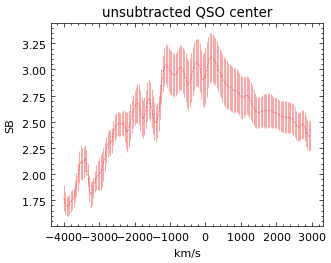

In [135]:

plt.errorbar(xnew,result_QSO[0][cind,:],yerr=result_QSO[2][cind,:]*efactor*ccfac,fmt="--",mfc='none',ms=0.5,color="r",ecolor="r",lw=0.5,alpha=0.5)
plt.title("unsubtracted QSO center")
plt.xlabel("km/s")
plt.ylabel("SB")

In [90]:
ccfac

0.00026792966824128

In [84]:
sigma_clipped_stats(result_QSO[0][xind,:],maxiters=None)

(0.0002998706575426248, 0.00028432969011940785, 0.00017391406835504824)

## Inspect each cubes in cube space (around restframe 1216)

### Generate data

In [5]:
Lya_SB={}
annulus_bin={}
annulus_value={}

In [513]:
qsos

<Table length=14>
    Name         aka      Field ...          Mi              z_Lyaneb     
    unit         unit      unit ...                                       
   str11        str13      str5 ...       float64            float64      
----------- ------------- ----- ... ------------------- ------------------
   Q0100+13        PHL957 Q0100 ... -30.321267391475878   2.72238484467835
HS0105+1619          None Q0105 ...  -29.88400104644006 2.6534598943518497
  Q0207-003         UM402 Q0207 ... -30.122461538584293 2.8743148248673793
 Q0449-1645          None Q0449 ...            -29.7854          2.6808366
 Q0821+3107 NVSS0821+3107 Q0821 ... -29.848176827459962 2.6294241961367883
   Q1009+29         CSO38 Q1009 ...  -30.73400104644006  2.651432107741275
  Q1217+490   SBS1217+490 Q1217 ...  -30.01486119098076  2.708454933359138
 Q1442+2931   HS1442+2931 Q1442 ... -30.431893073334017  2.664141101586948
 Q1549+1919   HS1549+1919 Q1549 ... -31.165955755407307  2.847334911697182
HS1603+3820          None Q1603 ... -30.802172282288744 2.5550447110564654
 Q1623-KP77   FBQS1625+26 Q1623 ...  -29.28596666482499              2.534
  HS1700+64          None Q1700 ...  -30.95996016451035 2.7507207351611034
  Q2206-199   LBQS2206-19 Q2206 ... -29.874706698233805  2.576526634363855
   Q2343+12   SDSS2343+12 Q2343 ... -29.694706698233805 2.5809114519896306

In [505]:
import regions
from regions.shapes.circle import CircleSkyRegion,CirclePixelRegion
from regions import CircleAnnulusSkyRegion, CircleAnnulusPixelRegion, RectangleSkyRegion
from regions import PixCoord
import re
type="HLQSO"

qso_low=ascii.read(KBSSpath+"/KCWI/qsos.kcwi",format="ipac")
# radius bin
#rbin=np.logspace(-0.5,0.48,num=6)
rbin=np.arange(0.3,6.9,0.3)
# windowsize to extract the Lya nebulae
windowsize=15.*u.arcsec

# extract -500 to -2000 km/s profile
vup=3100
vlow=-4100
cw=1215.67

for ind,sourcename in enumerate(QSOtab['Name']):
    if False:#"Q1623" in sourcename:
        continue
        field="Q1623"
        psname=re.findall(r"-(.*)",sourcename)[0]
        sentry=qsos[(qsos["Field"]==field) & (qsos["Name"]==field+"-"+psname)]
        ssentry=qso_low[qso_low["Name"]==psname]
        csname=ssentry["Cube"][0]
        datapath=KBSSpath+"/"+field+"/"+csname+"/kcwi_oned"
        subdapath=KBSSpath+"/"+field+"/"+psname+"/kcwi_oned"
    else:
        sentry=qsos[qsos["Name"]==sourcename]
        field=sentry["Field"][0]        
        subdapath=KBSSpath+"/"+field+"/QSO"
        datapath=KBSSpath+"/"+field+"/QSO"
        csname="qso"
        psname="qso"


    #contam=sentry["contam"][0]

    #if contam=="True":
    #    continue
    Subfile = subdapath+"/{}-{}_icubes_wcs_20.PSFCONTSub.fits".format(field.lower(),psname)
    varfile=datapath+"/{}-{}_vcubes.fits".format(field.lower(),csname)
    maskfn=subdapath+"/{}-{}_icubes_wcs_20.PSFSub.mask.fits".format(field.lower(),psname)
    
    
    O_cube = SpectralCube.read(Subfile)
    OV_cube = SpectralCube.read(varfile)
    wcsinfo = O_cube.wcs.celestial
    RA = sentry["RA"].value[0]
    Dec = sentry["Dec"].value[0]
    #redshift=sentry["z_sys"].value[0]
    redshift=sentry["z_Lyaneb"].value[0]
    xpix = sentry["x"].value[0]
    ypix = sentry["y"].value[0]
    s_coord=PixCoord(x=xpix,y=ypix)
    sc=s_coord.to_sky(wcsinfo) #redefine PSF center as the source center
    #sc=SkyCoord(ra=RA, dec=Dec, unit='deg',frame="icrs", equinox='J2000')
    #sregion=regions.RectangleSkyRegion(sc,width=windowsize, height=windowsize)
    #sregion_pix=sregion.to_pixel(wcsinfo)
    pixel_scale=wcsinfo.pixel_scale_matrix[1,1]*3600
    sregion_pix=regions.RectanglePixelRegion(center=s_coord,width=windowsize.value/pixel_scale, height=windowsize.value/pixel_scale)
    
    region_pix4 = CirclePixelRegion(center=s_coord,radius=4)
    rmask=region_pix4.to_mask()
    rmask2D_image = rmask.to_image(O_cube.shape[1:])
    #expanded_rmask_image = np.repeat(rmask2D_image[np.newaxis, :, :], mask_3d_filtered.shape[0], axis=0)
    
    windowmask=sregion_pix.to_mask()
    windowmask2D_image = windowmask.to_image(O_cube.shape[1:])
    contmask=fits.open(maskfn)[0].data
    
    
    #expanded_mask_image = np.repeat(((~contmask.astype(bool))&windowmask2D_image.astype(bool))[np.newaxis, :, :], O_cube.shape[0], axis=0)
    mask2d=((contmask.astype(bool))|rmask2D_image.astype(bool))
    expanded_mask_image = np.repeat(((contmask.astype(bool))|rmask2D_image.astype(bool))[np.newaxis, :, :], O_cube.shape[0], axis=0)

    Sub_cube=np.where(expanded_mask_image, np.nan, O_cube.unmasked_data[:].value)
    Var_cube=np.where(expanded_mask_image, np.nan, OV_cube.unmasked_data[:].value)
    
    #wcssub=Sub_cube.wcs.celestial
    
    specwidth=1
    cw=1215.67*(1+redshift) * u.AA
    wc = O_cube.spectral_axis.value
    vc = (wc / (1 + redshift) - 1215.67) / 1215.67 *3e5

    windex = wc[(vlow<vc)&(vup>vc)]
    wmin=np.argmin(windex)#np.min(wc[windex])*u.AA
    wmax=np.argmax(windex)#np.max(wc[windex])*u.AA
    #Lya_varcube = Var_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
    Lya_subvarcube = Var_cube[wmin:wmax+1,:]
    #Lya_cube = Sub_cube.with_spectral_unit(u.km/u.s, velocity_convention='relativistic', rest_value=1215.67*(1+redshift) * u.AA)
    Lya_subcube = Sub_cube[wmin:wmax+1,:]
    
    #maskfn=subdapath+"/{}-{}_icubes_wcs_{}.PSFSub.mask.fits".format(field.lower(),"qso",int(radius/0.3))
    #fitsmask_hdu=fits.open(maskfn)[0]
    #fitsmask=fitsmask_hdu.data.copy()
    
    #Lya_mvar = np.nansum(Lya_subvarcube,axis=0)
    #Lya_mflux = np.nansum(Lya_subcube,axis=0)
    #mask=Lya_mflux.value > 1.0*Lya_msig.value
    #bad=np.isnan(Lya_moment_1[mask])
    Lya_SB[sourcename]=[Lya_subcube, Lya_subvarcube, wcsinfo, vc[(vlow<vc)&(vup>vc)],mask2d]

    # Log scaled radius SB profile
    """
    Aregions=[]
    Aregions_value=[]
    Aregions_varvalue=[]
    for rind, rin in enumerate(rbin):
        if rind<len(rbin)-1:
            region_annulus_sky = CircleAnnulusSkyRegion(center=sc,
                                                inner_radius=rin * u.arcsec,
                                                outer_radius=rbin[rind+1] * u.arcsec)
            region_annulus_pix = region_annulus_sky.to_pixel(wcssub)
            #region_annulus_pix = CircleAnnulusPixelRegion(center=PixCoord(x=xpix,y=ypix),inner_radius=rin/0.3,outer_radius=rbin[rind+1]/0.3)
            Aregions.append(region_annulus_pix)
            Lya_mflux_sub=Lya_subcube.subcube_from_regions([region_annulus_pix]).unmasked_data[:].value
            Lya_mvar_sub=Lya_subvarcube.subcube_from_regions([region_annulus_pix]).unmasked_data[:].value
            Aregions_value.append(Lya_mflux_sub)
            Aregions_varvalue.append(Lya_mvar_sub)
        else:
            continue
    annulus_bin[sourcename]=Aregions
    annulus_value[sourcename]=[Aregions_value,Aregions_varvalue]
    """
#    mask_annulus_reg = region_annulus_pix.to_mask()
#    mask_annulus_reg = mask_annulus_reg.to_image(Sub_cube.shape[1:]).astype(bool)







In [760]:
plt.style.use(["science",'no-latex'])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":15,
"legend.fancybox":True})
#

Lyau = r"SB$_{\rm Ly\alpha}\,\rm (10^{-18}~erg~s^{-1}~arcsec^{-2}~cm^{-2})$"


for ind,sourcename in enumerate(QSOtab['Name']):
    if False:#"Q1623" in sourcename:
        field="Q1623"
        psname=re.findall(r"-(.*)",sourcename)[0]
        sentry=qsos[(qsos["Field"]==field) & (qsos["Name"]==field+"-"+psname)]
        ssentry=qso_low[qso_low["Name"]==psname]
        csname=ssentry["Cube"][0]
        datapath=KBSSpath+"/"+field+"/"+csname+"/kcwi_oned"
        subdapath=KBSSpath+"/"+field+"/"+psname+"/kcwi_oned"
    else:
        sentry=qsos[qsos["Name"]==sourcename]
        field=sentry["Field"][0]        
        subdapath=KBSSpath+"/"+field+"/QSO"
        datapath=KBSSpath+"/"+field+"/QSO"
        csname="qso"
        psname="qso"

    #contam=sentry["contam"][0]
    
    #if contam == "True":
        #continue
    Subfile = subdapath+"/{}-{}_icubes_wcs.PSFCONTSub.fits".format(field.lower(),psname)
    O_cube = SpectralCube.read(Subfile)
    wcsinfo = O_cube.wcs.celestial
    RA = sentry["RA"].value[0]
    Dec = sentry["Dec"].value[0]
    redshift=sentry["z_sys"].value[0]
    
    xpix = sentry["x"].value[0]
    ypix = sentry["y"].value[0]
    s_coord=PixCoord(x=xpix,y=ypix)
    sc=s_coord.to_sky(wcsinfo)
    
    #sregion_pix=regions.RectanglePixelRegion(center=s_coord,width=windowsize.value/pixel_scale, height=windowsize.value/pixel_scale)

    #Sub_cube=O_cube.subcube_from_regions([sregion_pix])
    
    wcssub=Lya_SB[sourcename][2]#Sub_cube.wcs.celestial
    pixel_scale=wcssub.pixel_scale_matrix[1,1]*3600
    vlow=-2000
    vup=-670
    vc=Lya_SB[sourcename][3]
    vindex=(vlow<vc)&(vup>vc)

    
    Lya_mflux=np.nansum(Lya_SB[sourcename][0][vindex,:,:],axis=0)
    #Lya_msig=Lya_SB[sourcename][1]
    _, med, std = sigma_clipped_stats(Lya_mflux*100)
    
    #mask=Lya_mflux.value < std*0.07
   # mask=Lya_mflux < 1.*Lya_msig
    # Integrated Lya image
    
    
    
    fig, ax, im1 = imshow_astro(Lya_mflux*100,wcssub , cblabel = Lyau, colorbar=True, vrange = (-0.1, med+10*std),cmap = "binary")
        
    #s_coord3=wcsinfo.world_to_pixel(sc3)
    #ax.plot(s_coord3[0],s_coord3[1],"+",c="r",ms=30,lw=0.1)
    #for aregion in Aregions:
    #    ax.add_artist(aregion.as_artist(facecolor='none', edgecolor='green'))
    ns_coord=sc.to_pixel(wcssub)
    ax.plot(ns_coord[0],ns_coord[1],"+",c="g",ms=30,lw=0.1)
    ax.text(ns_coord[0]+2,ns_coord[1]-3
            ,"{}".format(sourcename),color="green",verticalalignment='bottom',horizontalalignment='right',fontsize=15)
    
    
    #ax.scatter(sc3.ra.value, sc3.dec.value, transform=ax.get_transform('world'), s=55, edgecolor='r', facecolor='none')
    #ax.text(sc3.ra.value, sc3.dec.value,"{}-{}".format(cubename,tag3),color="red",transform=ax.get_transform('world'),verticalalignment='bottom',horizontalalignment='right',fontsize=15)
    
    
    
    x0, y0 = 15, 15
    arrow_length = 3
    
    # North arrow goes upward in y-direction (positive Dec)
    ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='black', label='North')
    ax.text(x0+1, y0+1, 'N', color='black', ha='center', va='bottom')
    # East arrow goes to the right in x-direction (negative RA)
    ax.quiver(x0, y0, -arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='black', label='East')
    ax.text(x0-1, y0-1, 'E', color='black', ha='center', va='top')
    
    #region_annulus_pix = CircleAnnulusPixelRegion(center=PixCoord(x=ns_coord[0],y=ns_coord[1]),inner_radius=rbin[rbin1]/pixel_scale,outer_radius=rbin[rbin2]/pixel_scale)
    #ax.add_artist(region_annulus_pix.as_artist(facecolor='none', edgecolor='green'))
    #print("highlighting annulus region in:",rbin[rbin1],rbin[rbin2],"arcsec")
    #-------------------Reference scale setting----------------#
    dT = 10  # kpc distance
    delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
    start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
    start_coord = wcssub.pixel_to_world(start_x, start_y)
    end_coord = wcssub.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel
    
    delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
    length_in_pixels = delta_theta_deg / delta_ra_per_pixel
    
    ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='red', lw=2)
    ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='red', ha='center', va='bottom')
    
    ax.set_xlabel("R.A.")
    ax.set_ylabel("Dec.")
    
    ax.set_title(r"Integrated KCWI slice around {}$\rm\,\AA\,$(z={})".format(1216,round(redshift,2)))
    #fig.savefig(KBSSpath+f"/QSOs_r{radius}_masked/Lya_blue_{sourcename}.pdf")
    plt.close()
    #plt.show()

/disk/bifrost/yuanze/anaconda3/envs/kcwidrp/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


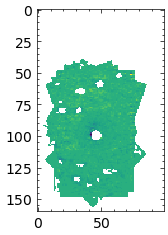

In [506]:
plt.imshow(np.nanmean(Lya_SB["Q1623-KP77"][0],axis=0))

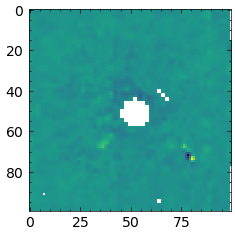

In [531]:
plt.imshow(stackcube[4,:])

In [530]:
np.nanmedian(stackcube[4,:])

0.011677835274023097

In [552]:
sigma_clipped_stats(img_to_stack,maxiters=1)

(-0.0028204059, 0.0, 0.0059842276)

In [579]:
from scipy import interpolate
tab=QSOtab#qsos[(qsos['contam']=="False")&(qsos['Field']!="Q1623")]
stackx = np.arange(0,15, 0.15)
stacky = np.arange(0,15,0.15)
vstack1 = np.arange(-4000,3000,50)
rbin1=17
rbin2=18
#vlow=-2000
#vup=-670
nboot=None
vlow=-2000
vup=0
dospec=False
doimg=True
stackcube=np.zeros((len(tab), len(stacky), len(stackx)))
spec_to_stack=np.zeros((rbin2-rbin1,len(vstack1)))
stackspec=np.zeros((len(tab), len(vstack1)))
for ind,sourcename in enumerate(Lya_SB.keys()):#enumerate(['Q1623-KP77']):
    #if "Q1623" in sourcename:
    #    print("skipping",sourcename)
    #    continue
    wcssub=Lya_SB[sourcename][2]
    pixel_scale=wcssub.pixel_scale_matrix[1,1]*3600
    vc=Lya_SB[sourcename][3]
    sentry=QSOtab[QSOtab["Name"]==sourcename]
    xpix = sentry["x"].value[0]
    ypix = sentry["y"].value[0]
    xoff=(xpix-np.mean(stackx/pixel_scale))*pixel_scale
    yoff=(ypix-np.mean(stacky/pixel_scale))*pixel_scale
    if dospec:
        for sind,item in enumerate(annulus_value[sourcename][0][rbin1:rbin2]):
            interpfunc_spec=interpolate.CubicSpline(vc,np.nanmean(item,axis=(1,2)))
            spec_to_stack[sind,:] = interpfunc_spec(vstack1)
        stackspec[ind,:] = np.nanmean(spec_to_stack,axis=0)
    if doimg:
        
        vindex=(vlow<vc)&(vup>vc)
        img_to_stack=np.nansum(Lya_SB[sourcename][0][vindex,:,:],axis=0)
        xshape, yshape=img_to_stack.shape
        xstack = np.linspace(1,xshape,xshape)*pixel_scale
        ystack = np.linspace(1,yshape,yshape)*pixel_scale
        interpfunc = interpolate.interp2d(ystack,xstack , np.nan_to_num(img_to_stack), kind='linear')
        cube2d_new = interpfunc( stackx+xoff,stacky+yoff)
        cube2d_new[cube2d_new<1e-5]=np.nan
        #print("renormalizing with a factor of:",np.abs(std))
        stackcube[ind, :, :] = cube2d_new
        

stackfunc=np.nanmean
    #Lya_mflux=
if doimg:
    cspace_stack = np.nanmean(stackcube,axis=0)
    if nboot is not None:
        bootcube = np.zeros((nboot, len(stackx), len(stacky)))
        for i in range(nboot):
            rand = np.random.randint(0, len(tab)-1, size=len(tab))
            stackcube_rearrange = stackcube[rand, :, :]
            bootcube[i, :, :] = stackfunc(stackcube_rearrange, axis=0)
        
        imgerr = np.nanstd(bootcube, axis=0)






if dospec:
    cspace_specstack = np.nanmean(stackspec,axis=0)
    if nboot is not None:
        bootcube = np.zeros((nboot, len(vstack1)))
        for i in range(nboot):
            rand = np.random.randint(0, len(tab)-1, size=len(tab))
            stackcube_rearrange = stackspec[rand, :]
            bootcube[i, :] = stackfunc(stackcube_rearrange, axis=0)
        
        specerr = np.nanstd(bootcube, axis=0)



/disk/bifrost/yuanze/anaconda3/envs/kcwidrp/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice


In [401]:
sourcename

(100, 100)

###  plot the stacked image

In [585]:
std

1.5916023942743711

In [565]:
np.nanmin(cspace_stack*100)

-47.066142638662235

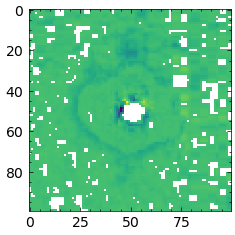

In [560]:
plt.imshow(cube2d_new)

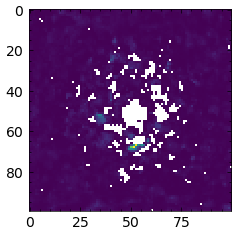

In [580]:
plt.imshow(cspace_stack)

/disk/bifrost/yuanze/anaconda3/envs/kcwidrp/lib/python3.7/site-packages/ipykernel_launcher.py:125: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


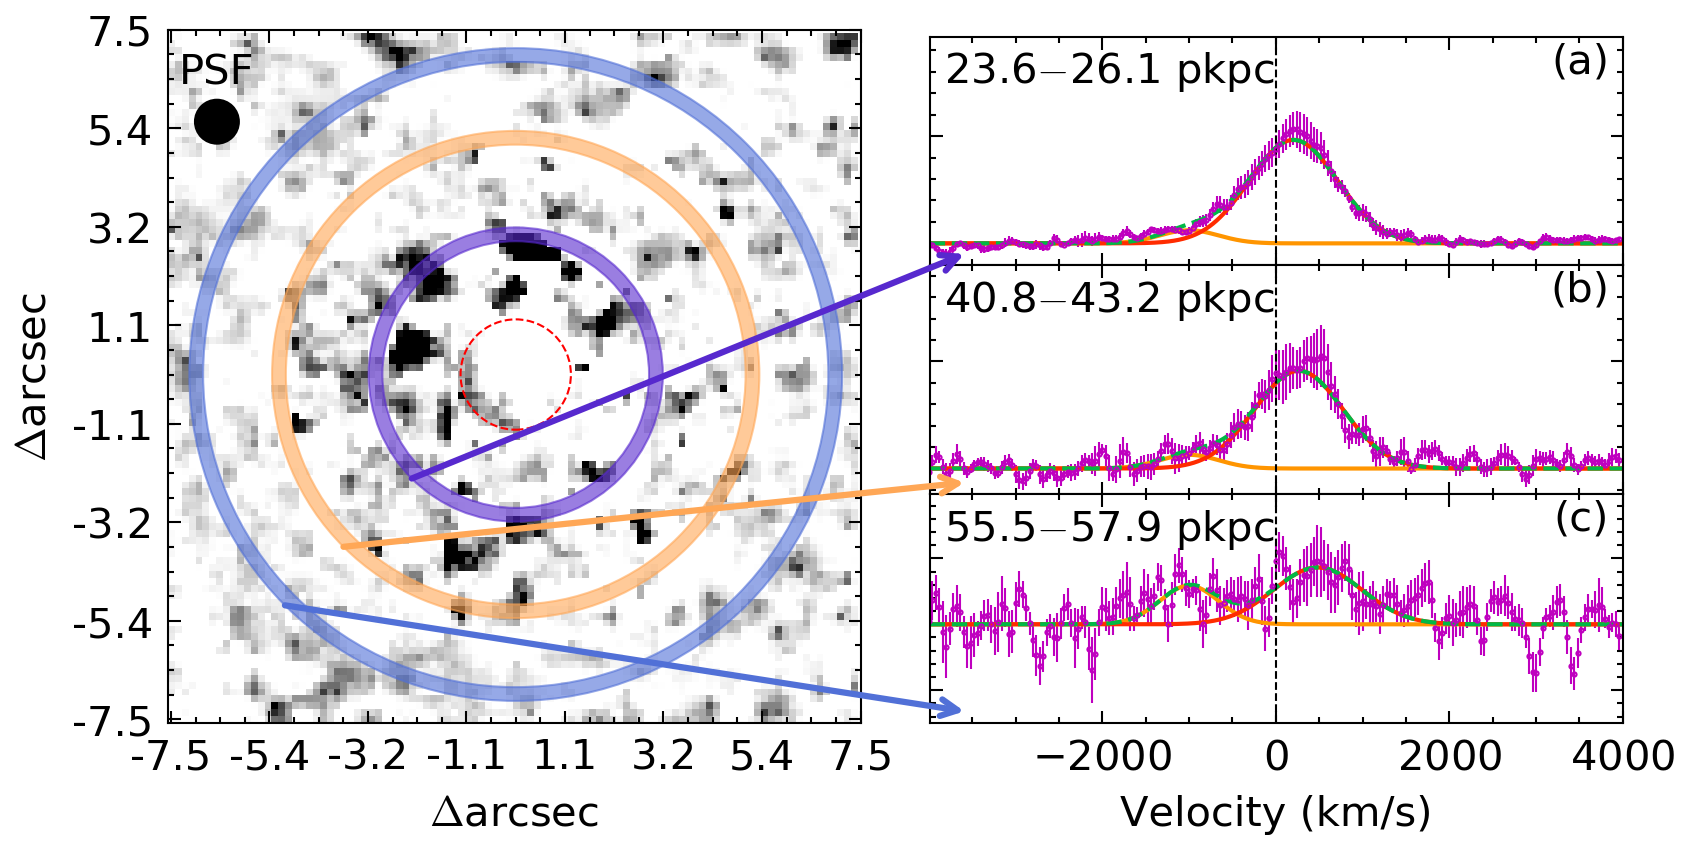

In [590]:
from matplotlib.patches import Circle, Wedge, Rectangle,ConnectionPatch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":10,
"legend.fancybox":True})
Lyau = r"SB$_{\rm Ly\alpha}\,\rm (10^{-18}~erg~s^{-1}~arcsec^{-2}~cm^{-2})$"

_, med, std = sigma_clipped_stats(cspace_stack*100,maxiters=2)
pix_scale=[0.15,0.15]
fig, ax = imshow_ifu(cspace_stack*100,figsize = (3,3),dpi=300,pix_scale=pix_scale,stretch = vis.LinearStretch()\
                     , cblabel = Lyau, colorbar=False, vrange = (0, 8*med),cmap = matplotlib.cm.binary)


inner=4.2
outer=6.2
#region_annulus_pix = CircleAnnulusPixelRegion(center=PixCoord(x=cspace_stack.shape[0]/2,y=cspace_stack.shape[1]/2),inner_radius=inner/pix_scale[0],outer_radius=outer/pix_scale[0])
#region_annulus_pix = CircleAnnulusPixelRegion(center=PixCoord(x=cspace_stack.shape[0]/2,y=cspace_stack.shape[1]/2),inner_radius=rbin[rbin1]/pix_scale[0],outer_radius=rbin[rbin2]/pix_scale[0])
#ax.add_artist(region_annulus_pix.as_artist(facecolor='none', edgecolor='green'))
#print("highlighting annulus region in:",rbin[rbin1],rbin[rbin2],"arcsec")
# North arrow goes upward in y-direction (positive Dec)
#ax.quiver(x0, y0, 0, arrow_length, angles='xy', scale_units='xy', scale=1, color='black', label='North')
#ax.text(x0+1, y0+1, 'N', color='black', ha='center', va='bottom')
# East arrow goes to the right in x-direction (negative RA)
#ax.quiver(x0, y0, -arrow_length, 0, angles='xy', scale_units='xy', scale=1, color='black', label='East')
#ax.text(x0-1, y0-1, 'E', color='black', ha='center', va='top')


#-------------------Reference scale setting----------------#
"""
dT = 10  # kpc distance
delta_theta_deg = dT/Planck18.kpc_proper_per_arcmin(redshift).value/60
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
start_x = x_lim[0] + 0.10 * (x_lim[1] - x_lim[0])
start_y = y_lim[0] + 0.10 * (y_lim[1] - y_lim[0])
start_coord = wcssub.pixel_to_world(start_x, start_y)
end_coord = wcssub.pixel_to_world(start_x + 1, start_y)  # arbitrary +1 in pixel to get RA difference for 1 pixel

delta_ra_per_pixel = start_coord.ra.degree - end_coord.ra.degree
length_in_pixels = delta_theta_deg / delta_ra_per_pixel

radii = np.linspace(10, 40, 5)
"""
center=(cspace_stack.shape[0]/2,cspace_stack.shape[1]/2)
#for r in ynew:
circ = Circle(center, 1.2/pix_scale[0], edgecolor='red', facecolor='none', lw=0.5,ls="--")
ax.add_patch(circ)

#ax.scatter(center[0],center[1],marker="+",s=10,color="red",lw=1)

circ = Circle((1./pix_scale[0],13/pix_scale[0]),0.5/pix_scale[0], edgecolor='none', facecolor='Black')
ax.add_patch(circ)
ax.text(1./pix_scale[0],14.5/pix_scale[0],"PSF"\
         ,verticalalignment='top',horizontalalignment='center')
# Define the specific annulus for extraction (e.g., between 20 and 30 pixels)

xindes=[5,12,18]
annuli = [(ynew[xindes[0]], ynew[xindes[0]+1]), (ynew[xindes[1]], ynew[xindes[1]+1]), (ynew[xindes[2]], ynew[xindes[2]+1])]
labels=["(a)","(b)","(c)"]
color=["xkcd:blue purple","xkcd:pale orange","xkcd:cornflower blue"]
#vgrid = np.arange(-3000, 3001, 1)
ax_insets=[]
vgrid = np.arange(-5500, 5501, 1)

for i, (r_in, r_out) in enumerate(annuli):
    inner_radius = r_in/pix_scale[0]
    outer_radius = r_out/pix_scale[0]

# Highlight the annulus using a Wedge (full circle with a given width)
    annulus = Wedge(center, outer_radius, 0, 360, width=(outer_radius - inner_radius),
                    edgecolor=color[i], facecolor=color[i],alpha=0.6, lw=0.5)
    ax.add_patch(annulus)

    rect_x = center[0] - outer_radius
    rect_y = center[1] - outer_radius
    rect_width = 2 * outer_radius
    rect_height = 2 * outer_radius
    #bbox = Rectangle((rect_x, rect_y), rect_width, rect_height,
    #                 linewidth=1.5, edgecolor='none', facecolor='none', ls='--')
    #ax.add_patch(bbox)
    ax_insets.append(ax.inset_axes([1.1,0.66-i*0.33,1.0,0.33]))
    ax_inset=ax_insets[-1]
    if i != 2:
        ax_inset.set_yticklabels([])
        ax_inset.set_xticklabels([])
        xlabel=""
    else:
        ax_inset.set_yticklabels([])
        xlabel="Velocity (km/s)"
    ax_inset.text(0.98,0.98,labels[i],transform=ax_inset.transAxes\
         ,verticalalignment='top',horizontalalignment='right')
    plot1Dspec(result,xnew,ynew,xindes[i],vgrid,xlim=[-3990,4000],fixFWHM=True,ax=ax_inset,efactor=100,xlabel=xlabel,ylabel="",plotmodel=plotmodel,plotQSO=plotQSO,normalize=normalize)

    # Lower left corner of extraction_box in main data coordinates:
    main_ll = (center[0] - outer_radius/np.sqrt(2), center[1] - outer_radius/np.sqrt(2))
    # Upper left corner of extraction_box:
    main_ul = (center[0] - outer_radius/np.sqrt(2), center[1] + outer_radius/np.sqrt(2))

    # For the inset box, choose corresponding points in axes-fraction coordinates:
    inset_ll = (0.05, 0.05)  # lower left of inset_box
    inset_ul = (0.05, 0.45)  # upper left of inset_box

    # Create connection patches
    con_ll = ConnectionPatch(xyA=inset_ll, coordsA=ax_inset.transAxes,
                             xyB=main_ll, coordsB=ax.transData,
                             arrowstyle="<-",ls="-", color=color[i], lw=1.5)
    #con_ul = ConnectionPatch(xyA=inset_ul, coordsA=ax_inset.transAxes,
    #                         xyB=main_ul, coordsB=ax.transData,
    #                         arrowstyle="->",ls="-", color=color[i], lw=1.5)
    fig.add_artist(con_ll)
    #fig.add_artist(con_ul)



# Add an inset axis to show the extracted 1D spectrum

#ax_inset.plot(velocity, spectrum, color='blue')
#ax_inset.set_title("1D Spectrum", fontsize=10)
#ax_inset.set_xlabel("Velocity (km/s)", fontsize=8)
#ax_inset.set_ylabel("Intensity", fontsize=8)
#ax_inset.tick_params(labelsize=8)
plt.tight_layout()

#ax.plot([start_x, start_x + length_in_pixels], [start_y, start_y], color='red', lw=2)
#ax.text(start_x + length_in_pixels / 2, start_y+1, '{} kpc'.format(dT), color='red', ha='center', va='bottom')

#ax.set_xlabel("R.A.")
#ax.set_ylabel("Dec.")
fig.savefig(KBSSpath+"/stacked_img_blue_withspec1d_v2.pdf")
#ax.set_title(r"Integrated KCWI slice around {}$\rm\,\AA\,$ ({} to {} km/s)".format(1216,vlow,vup))

In [116]:
std

2.6538272185047815

<function lya_model_2 at 0x7f1dc1fc38c0>
highlighting annulus region in: 5.3999999999999995 5.699999999999999 arcsec


(-0.3, 1)

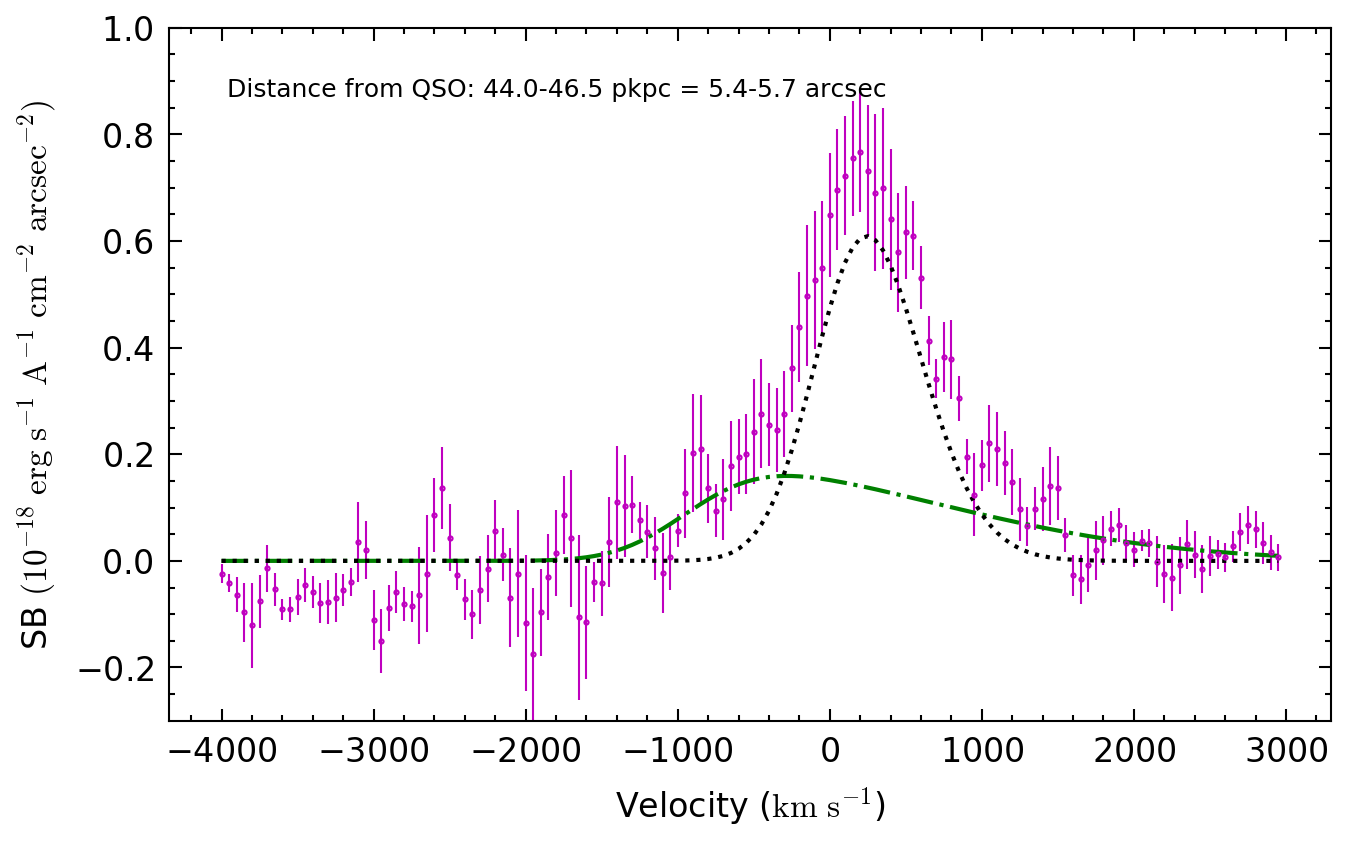

In [83]:
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})
kpc_per_arcsec=Planck18.kpc_proper_per_arcmin(2.65).value/60
fig, ax = plt.subplots(figsize=(5,3),dpi=300)
p0,p0sig=common_tools_yd.fit_lya_2(vstack1,cspace_specstack*100,specerr*100,absolute_sigma=False, all_p=True)

fitmodel0, lyamodel0, ndim0, p0, pcov0=common_tools_yd.lya_bestmod(vstack1,cspace_specstack*100,specerr*100, plot=False)

#ax.plot(vstack1,mod,"--C1",label="Full model")
ax.errorbar(vstack1,cspace_specstack*100,yerr=specerr*100,fmt="o",mfc='none',ms=0.5,color="m",ecolor="m",lw=0.5)
mod = lyamodel0(vstack1, *p0)
print(lyamodel0)
mod1 = common_tools_yd.skew_gauss(vstack1,*p0[:4])
mod2 = common_tools_yd.skew_gauss(vstack1, *p0[4:])
ax.plot(vstack1,mod1,"g",ls="-.")
ax.plot(vstack1,mod2,"k",ls=":")

ax.text(0.05,0.9,f"Distance from QSO: {rbin[rbin1]*kpc_per_arcsec:.1f}-{rbin[rbin2]*kpc_per_arcsec:.1f} pkpc = {rbin[rbin1]:.1f}-{rbin[rbin2]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)

#mod = common_tools_yd.skew_gauss(vstack1, *p0)
#ax.plot(vstack1,mod,"m",ls="--")
#ax.axhline(y=0,c="r")
#for sind in range(stackspec.shape[0]):
    #ax.errorbar(vstack1,stackspec[sind,:]*100,fmt="-o",mfc='none',ms=0.5,color="C{}".format(sind),ecolor="m",lw=0.5)
#ax.legend(loc="right")
ax.set_xlabel(r"Velocity ($\rm km~s^{-1}$)")
ax.set_ylabel(r"SB $\rm (10^{-18}~erg~s^{-1}~A^{-1}~cm^{-2}~arcsec^{-2})$")
print("highlighting annulus region in:",rbin[rbin1],rbin[rbin2],"arcsec")
#ax.set_xlim([-3000,3000])
ax.set_ylim([-0.3,1])
#ax.text(0.05,0.85,string,transform=ax.transAxes,color="k",fontsize=6)
#ax.text(0.05,0.75,f"Distance from QSO: {ynew[xind]*kpc_per_arcsec:.1f} pkpc = {ynew[xind]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)

In [53]:
plt.style.use(["science","no-latex"])
plt.rcParams.update({
    "font.family": "dejavu sans",   # specify font family here
    "font.serif": ["Times"],  # specify font here
    "font.size":8,
"legend.fancybox":True})



kpc_per_arcsec=Planck18.kpc_proper_per_arcmin(2.65).value/60

spec
fig, ax = plt.subplots(figsize=(5,3),dpi=300)

p0,p0sig=common_tools_yd.fit_lya_2(vstack1,cspace_specstack*100,specerr*100,absolute_sigma=False, all_p=True)

fitmodel0, lyamodel0, ndim0, p0, pcov0=common_tools_yd.lya_bestmod(vstack1,cspace_specstack*100,specerr*100, plot=False)

#ax.plot(vstack1,mod,"--C1",label="Full model")
ax.errorbar(vstack1,cspace_specstack*100,yerr=specerr*100,fmt="o",mfc='none',ms=0.5,color="m",ecolor="m",lw=0.5)
mod = lyamodel0(vstack1, *p0)
print(lyamodel0)
mod1 = common_tools_yd.skew_gauss(vstack1,*p0[:4])
mod2 = common_tools_yd.skew_gauss(vstack1, *p0[4:])
ax.plot(vstack1,mod1,"g",ls="-.")
ax.plot(vstack1,mod2,"k",ls=":")

ax.text(0.05,0.9,f"Distance from QSO: {rbin[rbin1]*kpc_per_arcsec:.1f}-{rbin[rbin2]*kpc_per_arcsec:.1f} pkpc = {rbin[rbin1]:.1f}-{rbin[rbin2]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)

#mod = common_tools_yd.skew_gauss(vstack1, *p0)
#ax.plot(vstack1,mod,"m",ls="--")
#ax.axhline(y=0,c="r")
#for sind in range(stackspec.shape[0]):
    #ax.errorbar(vstack1,stackspec[sind,:]*100,fmt="-o",mfc='none',ms=0.5,color="C{}".format(sind),ecolor="m",lw=0.5)
#ax.legend(loc="right")
ax.set_xlabel(r"Velocity ($\rm km~s^{-1}$)")
ax.set_ylabel(r"SB $\rm (10^{-18}~erg~s^{-1}~A^{-1}~cm^{-2}~arcsec^{-2})$")
print("highlighting annulus region in:",rbin[rbin1],rbin[rbin2],"arcsec")
#ax.set_xlim([-3000,3000])
ax.set_ylim([-0.3,1])
#ax.text(0.05,0.85,string,transform=ax.transAxes,color="k",fontsize=6)
#ax.text(0.05,0.75,f"Distance from QSO: {ynew[xind]*kpc_per_arcsec:.1f} pkpc = {ynew[xind]:.1f} arcsec",transform=ax.transAxes,color="k",fontsize=6)

(<function common_tools_yd.fit_lya_05(vel, spec, spec_sig, all_p=False, absolute_sigma=False)>,
 <function common_tools_yd.sym_gauss(vel, v0, sigv, height, a0=None, a1=None, a2=None, a3=None, a4=None)>,
 3,
 array([ 2.03367047e+02,  5.02556733e+02,  0.00000000e+00,  2.49927911e+00,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03, -9.99900000e+03]),
 array([[ 5.82481825e+02, -1.00709144e+02, -9.99900000e+03,
         -5.24139126e-01, -9.99900000e+03, -9.99900000e+03,
         -9.99900000e+03, -9.99900000e+03],
        [-1.00709144e+02,  5.55820427e+02, -9.99900000e+03,
         -2.13547336e+00, -9.99900000e+03, -9.99900000e+03,
         -9.99900000e+03, -9.99900000e+03],
        [-9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
         -9.99900000e+03, -9.99900000e+03, -9.99900000e+03,
         -9.99900000e+03, -9.99900000e+03],
        [-5.24139126e-01, -2.13547336e+00, -9.99900000e+03,
          1.98062229e-02, -9.99900000e+03, -9.99900000e+03,
         -9.99900000e+03, -

## Plot 2D image of the Nebulae and indicate the kind of line profile we get

In [431]:
2.*np.max(cspace_specstack)

0.021221714813292224

In [318]:
rbin

array([0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. , 3.3, 3.6, 3.9,
       4.2, 4.5, 4.8, 5.1, 5.4, 5.7, 6. , 6.3])

In [319]:
region_annulus_sky = CircleAnnulusSkyRegion(center=sc,
                                            inner_radius=0.3 * u.arcsec,
                                            outer_radius=0.6 * u.arcsec)
region_annulus_pix = region_annulus_sky.to_pixel(wcssub)

In [325]:
wcssub.pixel_scale_matrix*3600

array([[-0.2,  0. ],
       [ 0. ,  0.2]])

In [348]:
wcsinfo.pixel_scale_matrix[1,1]*3600

0.200000000000016

In [349]:
pixel_scale

-0.200000000000016